<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Umicore/Umicore_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UMI.BR"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02   7.03   7.44   6.95   7.44       4.26   603806
2009-01-05   7.49   7.62   7.41   7.61       4.36   898240
2009-01-06   7.60   7.97   7.41   7.97       4.56  1768962
2009-01-07   8.00   8.00   7.57   7.67       4.39  1631304
2009-01-08   7.61   7.61   7.37   7.57       4.33  1598838
...           ...    ...    ...    ...        ...      ...
2018-12-21  34.27  34.48  33.55  34.17      33.31  1479492
2018-12-24  33.63  35.00  33.55  34.78      33.90   209675
2018-12-27  35.40  35.54  34.15  34.42      33.55   770386
2018-12-28  34.63  35.36  34.52  34.68      33.81   762591
2018-12-31  34.92  35.13  34.50  34.86      33.98   172188

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     21.430477    21.679362    21.176193    21.432152    17.942954  9.747165e+05
std      10.030314    10.118951     9.916874    10.015215    10.944641  5.111359e+05
min       5.960000     6.140000     5.820000     5.940000     3.400000  4.523200e+04
25%      16.257500    16.425000    16.075000    16.257500    12.157500  6.405240e+05
50%      18.580000    18.810000    18.370000    18.580000    14.110000  8.613980e+05
75%      23.382500    23.622500    23.197500    23.477500    21.237500  1.166162e+06
max      53.600000    53.960000    52.700000    53.140000    51.420000  5.078146e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13   6.80   6.93   6.43   6.48       3.71  1693962   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   6.448800   6.492769   5.916375   6.447791   6.412975   6.212124       6.330        6.43   5.982816   6.36500   6.577497   6.3230   6.420000   6.36500   6.556667   6.473049                6.850901                  6.36500                5.879099                7.093852                  6.36500                5.636148                7.336802                  6.36500                5.393198                7.579753                  6.36500                5.150247   6.412975   6.501960   6.420577                6.898876                 6.412975                5.927073                7.141826                 6.412975                5.684123                7.384777                 6.412975                5.441172                7.627728                 6.412975   
2009-03-16   6.61   6.82   6.49   6.57       3.76  1242332   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   6.454860   6.491821   5.977193   6.502089   6.447869   6.214050       6.330        6.43   6.058591   6.36250   6.618063   6.3970   6.465556   6.36250   6.525000   6.455405                6.843930                  6.36250                5.881070                7.084645                  6.36250                5.640355                7.325360                  6.36250                5.399640                7.566075                  6.36250                5.158925   6.447869   6.550944   6.411083                6.929299                 6.447869                5.966439                7.170014                 6.447869                5.725724                7.410729                 6.447869                5.485009                7.651445                 6.447869   
2009-03-17   6.51   6.72   6.42   6.47       

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     21.719409    21.969669    21.464397    21.721137    18.221616  9.596659e+05    15.774142     1.998404   186.245810      30.462889      0.032721        0.027933        0.009976          0.007981     6.625698     2.540702    27.029928     1.998404      2.012769    27.029928    21.664686    21.571503     0.905167    21.721693    21.681370    21.637334    21.675545    21.661504    21.575361    21.681679    21.721122    21.681716    21.694864    21.681679    21.710160    21.600154               22.446160                21.681679               20.917198               22.828400                21.681679               20.534958               23.210640                21.681679               20.152718               23.592881                21.681679               19.770477    21.681370    21.711828    21.612587               22.445851                21.681370               20.916890               22.828091                21.681370               20.534649               23.210332   
std       9.916638    10.006052     9.800697     9.900951    10.872104  5.003799e+05     8.732031     1.408556   103.650851       0.785865      0.177942        0.164814        0.099401          0.088996     3.396541     1.106387    14.824654     1.408556      1.412461    14.824654     9.851290     9.821639    23.794347     9.905623     9.888571     9.876716     9.900168     9.893938     9.928526     9.894208     9.903348     9.896740     9.894421     9.894208     9.895715     9.880107               10.216705                 9.894208                9.594194               10.385735                 9.894208                9.453294               10.559624                 9.894208                9.318835               10.738136                 9.894208                9.191101     9.888571     9.895790     9.882699               10.211850                 9.888571                9.587736               10.381258                 9.888571                9.446412               10.555513   
min       6.510000     6.670000     6.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.006158  0.005498  0.003446  0.000857   0.000419  1693962   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000206  0.572638  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000055  0.000829  0.000000  0.000000  0.000055  0.001359  0.000800                0.003750                 0.000055                0.000000                0.007281                 0.000055                0.000000                0.010640                 0.000055                0.001617                0.013423                 0.000055                0.009736  0.000000  0.000655  0.000275                0.005681                 0.000000                0.000000                0.009185                 0.000000                0.000000                0.012428                 0.000000                0.000000                0.015110                 0.000000   
2009-03-16  0.002124  0.003172  0.004738  0.002784   0.001467  1242332   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000132  0.000185  0.573220  0.001171  0.000763  0.000043    0.000000    0.000000  0.001579  0.000000  0.001702  0.001621  0.000994  0.000000  0.000679  0.000406                0.003601                 0.000000                0.000044                0.007089                 0.000000                0.000094                0.010407                 0.000000                0.001761                0.013159                 0.000000                0.009930  0.000763  0.001708  0.000064                0.006328                 0.000763                0.000881                0.009773                 0.000763                0.000938                0.012953                 0.000763                0.000994                0.015566                 0.000763   
2009-03-17  0.000000  0.001057  0.003231  0.000642  

140178

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsr5n4db2
  JVM stdout: /tmp/tmpsr5n4db2/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpsr5n4db2/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_yytbnw
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5   0.693052                   0.5  0.499952  0.249952
1  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865
2  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  16.099748                   0.5  0.682741  0.466135
3  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865
4  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865
5  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865
6  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865
7  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5   0.702897                   0.5  0.504837  0.254860
8              DeepLearning_1_AutoML_20190825_160830  0.5  16.099748                   0.5  0.682741  0.466135
9  DeepLearning_grid_1_AutoML_20190825_160830_mod...  0.5  18.439028                   0.5  0.730660  0.533865

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.002740
1                  CDLLONGLINE             0.656631           0.656631    0.001799
2                 STOCHF_fastk             0.638943           0.638943    0.001751
3                  CDLBELTHOLD             0.598682           0.598682    0.001641
4               STOCHRSI_fastk             0.592100           0.592100    0.001623
...                        ...                  ...                ...         ...
1037                    T3_8_7             0.313503           0.313503    0.000859
1038                    MAX_20             0.313229           0.313229    0.000858
1039                   MA_30_7             0.313068           0.313068    0.000858
1040  BBANDS_middleband_20_1_2             0.311545           0.311545    0.000854
1041                   KAMA_24             0.304418           0.304418    0.000834

[1042 rows x 4 columns]

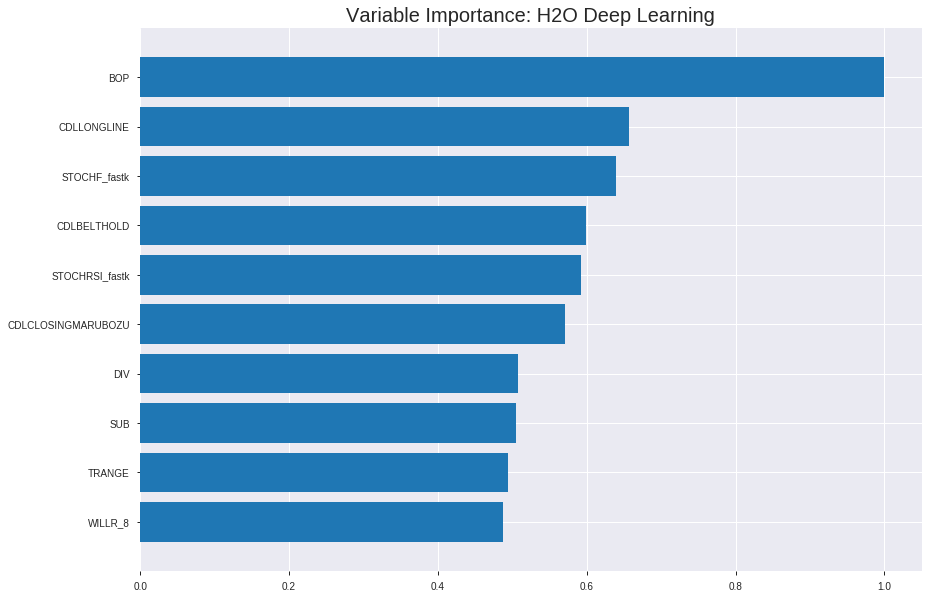

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_160830_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2467852565466087
RMSE: 0.496774854986249
LogLoss: 0.6866440316489026
Mean Per-Class Error: 0.434403870503822
AUC: 0.50925028528552
pr_auc: 0.567739352733506
Gini: 0.01850057057103993
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4992902853923902: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   841   0.9871   (841.0/852.0)
1      2    899   0.0022   (2.0/901.0)
Total  13   1740  0.4809   (843.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49929      0.680803  386
max f2                       0.497156     0.841436  390
max f0point5                 0.49929      0.57181   386
max accuracy                 0.502368     0.555619  242
max precision                0.67593      1         0
max recall                   0.479773     1         397
max specificity              0.67593      1         0
max absolute_mcc             0.502368     0.186283  242
max min_per_class_accuracy   0.499302     0.347392  385
max mean_per_class_accuracy  0.502368     0.565596  242

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.617575           1.62135   1.62135            0.833333         0.636197  0.833333                    0.636197            0.0166482       0.0166482                  62.1347   62.1347
    2        0.0205362                   0.593932           1.72944   1.67539            0.888889         0.604905  0.861111                    0.620551            0.017758        0.0344062                  72.9436   67.5392
    3        0.0302339                   0.579259           1.71672   1.68865            0.882353         0.585467  0.867925                    0.609298            0.0166482       0.0510544                  71.672    68.8648
    4        0.040502                    0.566011           1.51326   1.64418            0.777778         0.573124  0.84507                     0.600127            0.0155383       0.0665927                  51.3257   64.4183
    5        0.0501997                   0.552292           1.25893   1.56976            0.647059         0.557484  0.806818                    0.591889            0.0122087       0.0788013                  25.8928   56.9758
    6        0.100399                    0.517856           1.30445   1.4371             0.670455         0.533603  0.738636                    0.562746            0.0654828       0.144284                   30.4447   43.7103
    7        0.150029                    0.502039           1.31944   1.39818            0.678161         0.508807  0.718631                    0.544903            0.0654828       0.209767                   31.9441   39.818
    8        0.200228                    0.500785           0.420076  1.15296            0.215909         0.501264  0.592593                    0.533962            0.0210877       0.230855                   -57.9924  15.2958
    9        0.300057                    0.499781           0.567008  0.958012           0.291429         0.50023   0.492395                    0.522739            0.0566038       0.287458                   -43.2992  -4.19876
    10       0.992584                    0.49929            1.0257    1.00523            0.527183         0.499311  0.516667                    0.506393            0.710322        0.99778                    2.56954   0.523492
    11       1                           0.465497           0.299326  1                  0.153846         0.489247  0.513976                    0.506266            0.00221976      1                          -70.0674  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24951443897851006
RMSE: 0.4995142029797652
LogLoss: 0.6921708518538908
Mean Per-Class Error: 0.48821879834966475
AUC: 0.4895081227436823
pr_auc: 0.5065709681824099
Gini: -0.020983754512635455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49929028328587305: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    277  0        (0.0/277.0)
Total  0    501  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.49929      0.712082   25
max f2                       0.49929      0.860783   25
max f0point5                 0.49929      0.60719    25
max accuracy                 0.49929      0.552894   25
max precision                0.568776     1          0
max recall                   0.49929      1          25
max specificity              0.568776     1          0
max absolute_mcc             0.560407     0.0806744  3
max min_per_class_accuracy   0.499419     0.0397112  19
max mean_per_class_accuracy  0.505039     0.511781   10

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.556328           1.50722   1.50722            0.833333         0.561808  0.833333                    0.561808            0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.505039           1.44693   1.47982            0.8              0.516986  0.818182                    0.541434            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.499853           0.361733  1.13042            0.2              0.500487  0.625                       0.528638            0.00361011      0.0361011                  -63.8267  13.0415
    4        0.0419162                   0.499414           0.361733  0.947396           0.2              0.499557  0.52381                     0.521714            0.00361011      0.0397112                  -63.8267  -5.26044
    5        1                           0.49929            1.0023    1                  0.554167         0.499291  0.552894                    0.500231            0.960289        1                          0.230144  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:25:21  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:25:24  3 min 39.649 sec  286 obs/sec       0.35482   1             622        0.683337         2.31363             -0.86926       0.464619        0.472348           1.0809           0.486024                         0.667174           11.5052               -0.800636        0.476615          0.189696             0.998606           0.44511
    2019-08-25 16:25:49  4 min  4.741 sec  349 obs/sec       4.94695   14            8672       0.496775         0.686644            0.0120871      0.50925         0.567739           1.62135          0.48089                          0.499514           0.692171              -0.00935362      0.489508          0.506571             1.50722            0.447106
    2019-08-25 16:26:13  4 min 29.018 sec  386 obs/sec       10.3063   29            18067      0.484861         0.661697            0.0589031      0.712856        0.719939           1.72944          0.365659                         0.596019           5.52007               -0.437036        0.54449           0.618992             1.20578            0.447106
    2019-08-25 16:26:38  4 min 53.722 sec  398 obs/sec       15.6566   44            27446      0.46952          0.630677            0.117514       0.766565        0.775079           1.94562          0.305762                         0.661753           9.04434               -0.771493        0.551662          0.637843             1.50722            0.447106
    2019-08-25 16:27:03  5 min 19.276 sec  406 obs/sec       21.3639   60            37451      0.451876         0.592255            0.182593       0.774553        0.776772           1.94562          0.306332                         0.656832           7.70335               -0.745245        0.548745          0.627661             1.20578            0.447106
    2019-08-25 16:27:29  5 min 44.551 sec  419 obs/sec       27.4324   77            48089      0.459762         0.608291            0.153815       0.77476         0.790109           1.94562          0.309184                         0.622893           6.56142               -0.569549        0.55814           0.637309             1.50722            0.447106
    2019-08-25 16:27:54  6 min 10.501 sec  419 obs/sec       33.0217   93            57887      0.437792         0.562202            0.232752       0.796758        0.801543           1.94562          0.288078                         0.670189           9.80382               -0.816945        0.544844          0.630144             1.80866            0.447106
    2019-08-25 16:27:57  6 min 13.015 sec  419 obs/sec       33.0217   93            57887      0.496775         0.686644            0.0120871      0.50925         0.567739           1.62135          0.48089                          0.499514           0.692171              -0.00935362      0.489508          0.506571             1.50722            0.447106

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0027402575381678886
CDLLONGLINE               0.6566310524940491     0.6566310524940491   0.0017993381913919324
STOCHF_fastk              0.6389433741569519     0.6389433741569519   0.001750869397496013
CDLBELTHOLD               0.5986822843551636     0.5986822843551636   0.0016405436426718083
STOCHRSI_fastk            0.5920995473861694     0.5920995473861694   0.0016225052480707458
---                       ---                    ---                  ---
T3_8_7                    0.31350305676460266    0.31350305676460266  0.0008590791145378779
MAX_20                    0.31322911381721497    0.31322911381721497  0.0008583284403112708
MA_30_7                   0.3130683898925781     0.3130683898925781   0.0008578880153652208
BBANDS_middleband_20_1_2  0.3115452229976654     0.3115452229976654   0.0008537141457995484
KAMA_24                   0.3044181168079376     0.3044181168079376   0.0008341840393378239


See the whole table with table.as_data_frame()


('accuracy', 0.46613545816733065)

('F1', 0.6358695652173912)

('auc', 0.5)

('logloss', 0.6930520509666045)

('mean_per_class_error', 0.5)

('rmse', 0.49995243297248204)

('mse', 0.24995243523510413)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


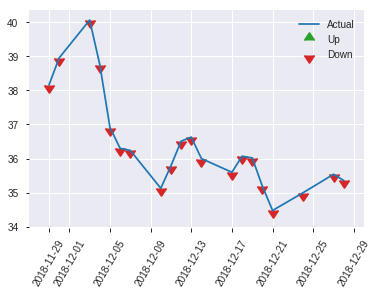


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24995243523510413
RMSE: 0.49995243297248204
LogLoss: 0.6930520509666045
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49929028328587305: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    134  1        (134.0/134.0)
1      0    117  0        (0.0/117.0)
Total  0    251  0.5339   (134.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49929      0.63587   0
max f2                       0.49929      0.81363   0
max f0point5                 0.49929      0.521855  0
max accuracy                 0.49929      0.466135  0
max precision                0.49929      0.466135  0
max recall                   0.49929      1         0
max specificity              0.49929      0         0
max absolute_mcc             0.49929      0         0
max min_per_class_accuracy   0.49929      0         0
max mean_per_class_accuracy  0.49929      0.5       0

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.49929            1       1                  0.466135         0.49929  0.466135                    0.49929             1               1                          0       0

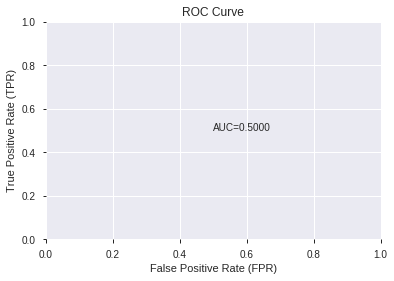

This function is available for GLM models only


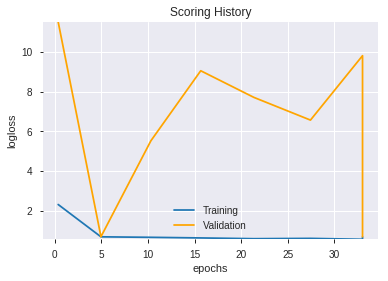

--2019-08-25 16:33:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.4MB/s    in 10s     

2019-08-25 16:33:30 (33.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_160830_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_160830_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_163342_model_6  0.707871  0.636688              0.343953  0.472718  0.223462
1  DeepLearning_grid_1_AutoML_20190825_163342_model_9  0.694413  0.630012              0.334386  0.469773  0.220686
2  DeepLearning_grid_1_AutoML_20190825_163342_model_8  0.691574  0.644029              0.350874  0.474050  0.224723
3               DeepLearning_1_AutoML_20190825_163342  0.675724  0.768881              0.392397  0.514132  0.264332
4  DeepLearning_grid_1_AutoML_20190825_163342_model_5  0.669282  0.754405              0.389272  0.505482  0.255512
5  DeepLearning_grid_1_AutoML_20190825_163342_model_2  0.644406  2.093741              0.363758  0.622408  0.387392
6  DeepLearning_grid_1_AutoML_20190825_163342_model_3  0.635668  2.234357              0.400466  0.639509  0.408971
7  DeepLearning_grid_1_AutoML_20190825_163342_model_7  0.632861  0.942478              0.391376  0.540175  0.291789
8  DeepLearning_grid_1_AutoML_20190825_163342_model_4  0.621125  1.464340              0.398361  0.612841  0.375574
9  DeepLearning_grid_1_AutoML_20190825_163342_model_1  0.621061  3.798354              0.413159  0.666071  0.443651

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.034090
1            CDLLONGLINE             0.732770           0.732770    0.024980
2     CDLCLOSINGMARUBOZU             0.725457           0.725457    0.024731
3                    SUB             0.678329           0.678329    0.023124
4                    COS             0.655473           0.655473    0.022345
5           CDLENGULFING             0.643536           0.643536    0.021938
6           CDLSHORTLINE             0.617957           0.617957    0.021066
7           STOCHF_fastk             0.614620           0.614620    0.020952
8                 TRANGE             0.609357           0.609357    0.020773
9         STOCHRSI_fastd             0.597897           0.597897    0.020382
10           STOCH_slowd             0.596114           0.596114    0.020321
11        CDLRICKSHAWMAN             0.595766           0.595766    0.020310
12        STOCHRSI_fastk             0.593919           0.593919    0.020247
13                   OBV             0.593763           0.593763    0.020241
14           CDLMARUBOZU             0.592427           0.592427    0.020196
15                   DIV             0.584911           0.584911    0.019940
16           CDLBELTHOLD             0.583667           0.583667    0.019897
17               BETA_30             0.583104           0.583104    0.019878
18                   day             0.576962           0.576962    0.019669
19               BETA_20             0.576440           0.576440    0.019651
20                 ADOSC             0.574730           0.574730    0.019593
21     CDLLONGLEGGEDDOJI             0.574217           0.574217    0.019575
22             STDDEV_30             0.573551           0.573551    0.019552
23         days_in_month             0.572430           0.572430    0.019514
24             dayofyear             0.570539           0.570539    0.019450
25            PLUS_DI_24             0.570168           0.570168    0.019437
26                 CMO_8             0.570130           0.570130    0.019436
27              STDDEV_8             0.569412           0.569412    0.019411
28            PLUS_DM_14             0.567124           0.567124    0.019333
29             CDLHAMMER             0.566413           0.566413    0.019309
30                ADX_12             0.562189           0.562189    0.019165
31                ULTOSC             0.561933           0.561933    0.019156
32     HT_PHASOR_inphase             0.553780           0.553780    0.018878
33                Volume             0.551670           0.551670    0.018806
34               CDLDOJI             0.550191           0.550191    0.018756
35             CORREL_14             0.549290           0.549290    0.018725
36                 RSI_8             0.548598           0.548598    0.018702
37     MACDFIX_signal_12             0.547866           0.547866    0.018677
38               WILLR_8             0.547695           0.547695    0.018671
39             CORREL_30             0.545649           0.545649    0.018601
40              WILLR_14             0.545142           0.545142    0.018584
41  HT_PHASOR_quadrature             0.542266           0.542266    0.018486
42          weekday_name             0.541076           0.541076    0.018445
43              WILLR_12             0.540229           0.540229    0.018416
44                MFI_24             0.536992           0.536992    0.018306
45            PLUS_DM_30             0.535161           0.535161    0.018244
46           HT_DCPERIOD             0.533700           0.533700    0.018194
47                 month             0.532749           0.532749    0.018161
48                 DX_12             0.531359           0.531359    0.018114
49        is_month_start             0.515476           0.515476    0.017573

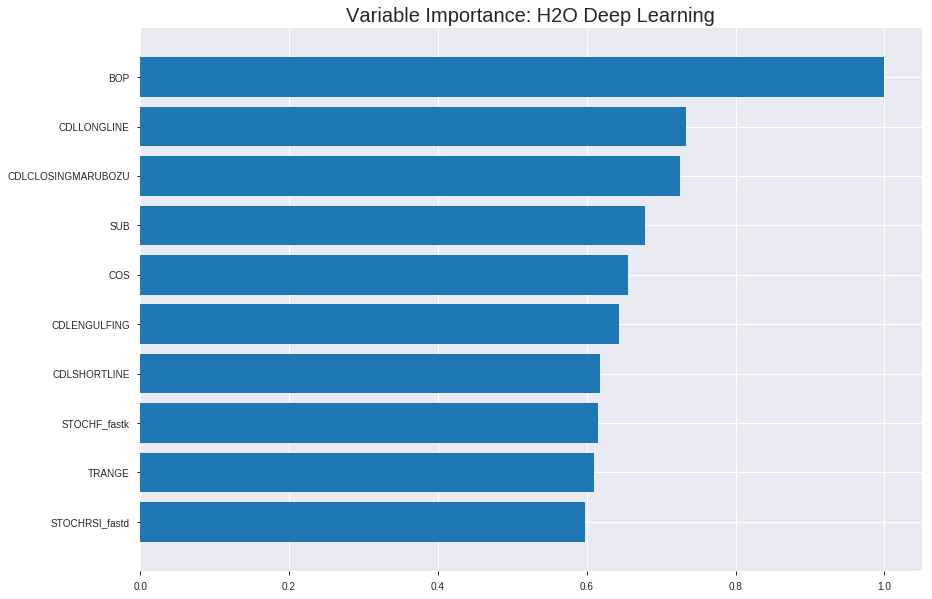

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_163342_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19577407728167442
RMSE: 0.4424636451525418
LogLoss: 0.5714752099175567
Mean Per-Class Error: 0.2992384570091656
AUC: 0.7759499095944516
pr_auc: 0.7788424671557016
Gini: 0.5518998191889033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46671193970369806: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      413  439   0.5153   (439.0/852.0)
1      105  796   0.1165   (105.0/901.0)
Total  518  1235  0.3103   (544.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466712     0.745318  244
max f2                       0.270479     0.855926  326
max f0point5                 0.548388     0.71676   179
max accuracy                 0.526711     0.699943  196
max precision                0.987185     1         0
max recall                   0.0935586    1         379
max specificity              0.987185     1         0
max absolute_mcc             0.48571      0.407461  231
max min_per_class_accuracy   0.520212     0.695893  202
max mean_per_class_accuracy  0.526711     0.700762  196

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.947729           1.94562   1.94562            1                0.965607  1                           0.965607            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.923059           1.83753   1.89157            0.944444         0.936677  0.972222                    0.951142            0.0188679       0.0388457                  83.7526   89.1571
    3        0.0302339                   0.904374           1.60227   1.79878            0.823529         0.912986  0.924528                    0.938903            0.0155383       0.054384                   60.2272   79.8777
    4        0.040502                    0.893622           1.83753   1.8086             0.944444         0.898777  0.929577                    0.928731            0.0188679       0.0732519                  83.7526   80.8601
    5        0.0501997                   0.875787           1.83117   1.81296            0.941176         0.885252  0.931818                    0.920331            0.017758        0.09101                    83.1168   81.296
    6        0.100399                    0.787805           1.6803    1.74663            0.863636         0.831298  0.897727                    0.875815            0.0843507       0.175361                   68.0305   74.6633
    7        0.150029                    0.724621           1.52071   1.6719             0.781609         0.757749  0.859316                    0.836759            0.0754717       0.250832                   52.0711   67.1898
    8        0.200228                    0.675096           1.48132   1.62412            0.761364         0.69922   0.834758                    0.802276            0.0743618       0.325194                   48.1321   62.4118
    9        0.300057                    0.591741           1.35637   1.53504            0.697143         0.629093  0.788973                    0.744658            0.135405        0.460599                   35.6372   53.5039
    10       0.399886                    0.548911           1.26743   1.46823            0.651429         0.569161  0.754636                    0.700846            0.126526        0.587125                   26.743    46.8232
    11       0.500285                    0.520434           1.03914   1.38212            0.534091         0.533941  0.710376                    0.667351            0.104329        0.691454                   3.91358   38.2119
    12       0.600114                    0.501884           0.945013  1.30941            0.485714         0.51178   0.673004                    0.641472            0.0943396       0.785794                   -5.49865  30.9407
    13       0.699943                    0.467123           0.933896  1.25585            0.48             0.486641  0.645477                    0.619389            0.0932297       0.879023                   -6.61043  25.585
    14       0.799772                    0.397638           0.55589   1.16848            0.285714         0.438564  0.600571                    0.596818            0.0554939       0.934517                   -44.411   16.848
    15       0.899601                    0.248795           0.478066  1.09186            0.245714         0.322827  0.561192                    0.566414            0.0477248       0.982242                   -52.1934  9.18644
    16       1                           0.00851901         0.176874  1                  0.0909091        0.146107  0.513976                    0.524215            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20796398462061627
RMSE: 0.456030683858681
LogLoss: 0.6024117274876838
Mean Per-Class Error: 0.3055295899948427
AUC: 0.7409344378545643
pr_auc: 0.7510138401209319
Gini: 0.4818688757091285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4476730755082341: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  111  0.4955   (111.0/224.0)
1      32   245  0.1155   (32.0/277.0)
Total  145  356  0.2854   (143.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447673     0.774092  269
max f2                       0.125836     0.868883  384
max f0point5                 0.447673     0.720165  269
max accuracy                 0.447673     0.714571  269
max precision                0.974746     1         0
max recall                   0.125836     1         384
max specificity              0.974746     1         0
max absolute_mcc             0.447673     0.426421  269
max min_per_class_accuracy   0.503132     0.67148   206
max mean_per_class_accuracy  0.447673     0.69447   269

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.932651           1.50722   1.50722            0.833333         0.955552  0.833333                    0.955552            0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.914355           1.44693   1.47982            0.8              0.920824  0.818182                    0.939767            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.890387           1.80866   1.58258            1                0.90123   0.875                       0.927724            0.0180505       0.0505415                  80.8664   58.2581
    4        0.0419162                   0.851612           1.80866   1.63641            1                0.860612  0.904762                    0.911745            0.0180505       0.0685921                  80.8664   63.6411
    5        0.0518962                   0.833646           1.44693   1.59997            0.8              0.844607  0.884615                    0.898834            0.0144404       0.0830325                  44.6931   59.9972
    6        0.101796                    0.722246           1.51928   1.56042            0.84             0.767684  0.862745                    0.834544            0.0758123       0.158845                   51.9278   56.0416
    7        0.151697                    0.668667           1.37458   1.49929            0.76             0.690868  0.828947                    0.787283            0.0685921       0.227437                   37.4585   49.9287
    8        0.201597                    0.627446           1.22989   1.43261            0.68             0.644287  0.792079                    0.751888            0.0613718       0.288809                   22.9892   43.2605
    9        0.301397                    0.573911           1.26606   1.37746            0.7              0.595336  0.761589                    0.70005             0.126354        0.415162                   26.6065   37.746
    10       0.401198                    0.530699           1.19372   1.33175            0.66             0.548239  0.736318                    0.662286            0.119134        0.534296                   19.3718   33.1753
    11       0.500998                    0.506912           1.22989   1.31146            0.68             0.516032  0.7251                      0.633152            0.122744        0.65704                    22.9892   31.1462
    12       0.600798                    0.479491           0.976679  1.25585            0.54             0.495277  0.694352                    0.610249            0.0974729       0.754513                   -2.33213  25.585
    13       0.700599                    0.449376           1.15755   1.24185            0.64             0.463519  0.68661                     0.589347            0.115523        0.870036                   15.7545   24.1846
    14       0.800399                    0.38891            0.614946  1.16368            0.34             0.426333  0.643392                    0.569021            0.0613718       0.931408                   -38.5054  16.3679
    15       0.9002                      0.255421           0.361733  1.07477            0.2              0.332548  0.594235                    0.542805            0.0361011       0.967509                   -63.8267  7.47717
    16       1                           0.0057386          0.32556   1                  0.18             0.171326  0.552894                    0.505731            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:38:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:38:09  2 min 18.940 sec  996 obs/sec       1.4227    1             2494       0.475842         0.670848            0.0935912      0.72698         0.727449           1.72944          0.367941                         0.477402           0.677392              0.0780311        0.711441          0.72078              1.50722            0.323353
    2019-08-25 16:38:15  2 min 24.653 sec  1916 obs/sec      8.43868   6             14793      0.442464         0.571475            0.216291       0.77595         0.778842           1.94562          0.310325                         0.456031           0.602412              0.158729         0.740934          0.751014             1.50722            0.285429
    2019-08-25 16:38:20  2 min 29.739 sec  2410 obs/sec      16.9019   12            29629      0.436818         0.557948            0.236164       0.787576        0.791495           1.94562          0.312037                         0.479633           0.662181              0.069393         0.728178          0.729716             1.20578            0.315369
    2019-08-25 16:38:26  2 min 35.535 sec  2669 obs/sec      26.729    19            46856      0.422268         0.527292            0.286202       0.81056         0.8161             1.94562          0.294353                         0.454802           0.60848               0.163255         0.746898          0.74573              1.20578            0.303393
    2019-08-25 16:38:31  2 min 41.122 sec  2832 obs/sec      36.6149   26            64186      0.421596         0.524165            0.288471       0.821076        0.82941            1.94562          0.270964                         0.458863           0.617782              0.148246         0.721901          0.721796             1.20578            0.333333
    2019-08-25 16:38:37  2 min 46.446 sec  2967 obs/sec      46.5727   33            81642      0.410914         0.50163             0.324072       0.838878        0.842186           1.94562          0.256132                         0.462424           0.629767              0.134975         0.714882          0.721155             1.50722            0.311377
    2019-08-25 16:38:42  2 min 51.700 sec  3063 obs/sec      56.4478   40            98953      0.397768         0.474992            0.366627       0.854184        0.861618           1.94562          0.255562                         0.464586           0.631527              0.12687          0.721587          0.725756             1.50722            0.315369
    2019-08-25 16:38:42  2 min 52.212 sec  3061 obs/sec      56.4478   40            98953      0.442464         0.571475            0.216291       0.77595         0.778842           1.94562          0.310325                         0.456031           0.602412              0.158729         0.740934          0.751014             1.50722            0.285429

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03408990961866775
CDLLONGLINE         0.7327702045440674     0.7327702045440674   0.024980070044159936
CDLCLOSINGMARUBOZU  0.7254565954208374     0.7254565954208374   0.024730749770162763
SUB                 0.6783294677734375     0.6783294677734375   0.02312419024807548
COS                 0.6554729342460632     0.6554729342460632   0.02234501308593124
---                 ---                    ---                  ---
PLUS_DM_30          0.5351608991622925     0.5351608991622925   0.018243586683887515
HT_DCPERIOD         0.5337004065513611     0.5337004065513611   0.018193798622782132
month               0.5327488780021667     0.5327488780021667   0.018161361100540514
DX_12               0.5313591361045837     0.5313591361045837   0.018113984924858634
is_month_start      0.5154764652252197     0.5154764652252197   0.01757254611007807


See the whole table with table.as_data_frame()


('accuracy', 0.6653386454183267)

('F1', 0.6938775510204083)

('auc', 0.7078709019007526)

('logloss', 0.6366883872939623)

('mean_per_class_error', 0.332408470468172)

('rmse', 0.47271801043494976)

('mse', 0.22346231738957725)

deeplearning prediction progress: |███████████████████████████████████████| 100%


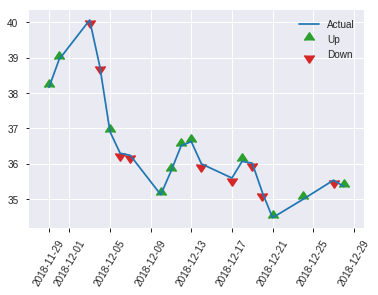


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22346231738957725
RMSE: 0.47271801043494976
LogLoss: 0.6366883872939623
Mean Per-Class Error: 0.332408470468172
AUC: 0.7078709019007526
pr_auc: 0.6286735947445479
Gini: 0.41574180380150527
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3138323812497517: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   75   0.5597   (75.0/134.0)
1      15   102  0.1282   (15.0/117.0)
Total  74   177  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313832     0.693878  176
max f2                       0.121323     0.827389  232
max f0point5                 0.470461     0.643564  96
max accuracy                 0.470461     0.665339  96
max precision                0.776625     1         0
max recall                   0.0586809    1         245
max specificity              0.776625     1         0
max absolute_mcc             0.345386     0.344371  168
max min_per_class_accuracy   0.444346     0.649573  119
max mean_per_class_accuracy  0.42205      0.667592  130

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 38.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.639542           0.7151    0.7151             0.333333         0.690088   0.333333                    0.690088            0.00854701      0.00854701                 -28.49    -28.49
    2        0.0239044                   0.614094           1.4302    1.07265            0.666667         0.62413    0.5                         0.657109            0.017094        0.025641                   43.0199   7.26496
    3        0.0318725                   0.597765           2.1453    1.34081            1                0.602643   0.625                       0.643493            0.017094        0.042735                   114.53    34.0812
    4        0.0438247                   0.588594           2.1453    1.56022            1                0.593131   0.727273                    0.629758            0.025641        0.0683761                  114.53    56.0218
    5        0.0517928                   0.584057           2.1453    1.65023            1                0.58447    0.769231                    0.622791            0.017094        0.0854701                  114.53    65.023
    6        0.103586                    0.545407           1.32018   1.48521            0.615385         0.561199   0.692308                    0.591995            0.0683761       0.153846                   32.0184   48.5207
    7        0.151394                    0.530021           1.25142   1.41138            0.583333         0.537543   0.657895                    0.574799            0.0598291       0.213675                   25.1425   41.1381
    8        0.203187                    0.515432           1.81525   1.51433            0.846154         0.52183    0.705882                    0.561298            0.0940171       0.307692                   81.5253   51.4329
    9        0.302789                    0.485211           1.28718   1.43961            0.6              0.498737   0.671053                    0.540718            0.128205        0.435897                   28.7179   43.9609
    10       0.40239                     0.465615           1.28718   1.40188            0.6              0.475879   0.653465                    0.524669            0.128205        0.564103                   28.7179   40.1879
    11       0.501992                    0.434574           1.02974   1.32804            0.48             0.452126   0.619048                    0.510276            0.102564        0.666667                   2.97436   32.8042
    12       0.601594                    0.39095            1.02974   1.27866            0.48             0.408922   0.596026                    0.493495            0.102564        0.769231                   2.97436   27.8655
    13       0.701195                    0.316662           0.943932  1.23111            0.44             0.360324   0.573864                    0.474579            0.0940171       0.863248                   -5.60684  23.1109
    14       0.800797                    0.234311           0.257436  1.11001            0.12             0.267225   0.517413                    0.448789            0.025641        0.888889                   -74.2564  11.0006
    15       0.900398                    0.168052           0.772308  1.07265            0.36             0.199281   0.5                         0.421188            0.0769231       0.965812                   -22.7692  7.26496
    16       1                           0.0183907          0.343248  1                  0.16             0.0908275  0.466135                    0

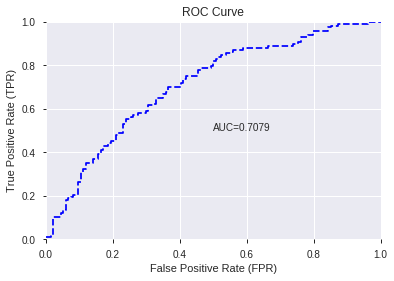

This function is available for GLM models only


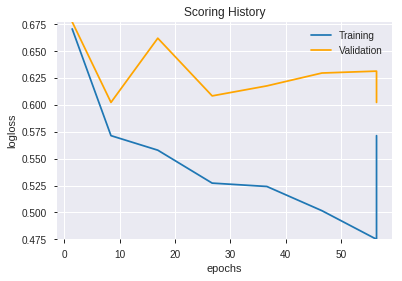

--2019-08-25 16:41:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_163342_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_163342_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'COS',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'CDLRICKSHAWMAN',
 'STOCHRSI_fastk',
 'OBV',
 'CDLMARUBOZU',
 'DIV',
 'CDLBELTHOLD',
 'BETA_30',
 'day',
 'BETA_20',
 'ADOSC',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_30',
 'days_in_month',
 'dayofyear',
 'PLUS_DI_24',
 'CMO_8',
 'STDDEV_8',
 'PLUS_DM_14',
 'CDLHAMMER',
 'ADX_12',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'Volume',
 'CDLDOJI',
 'CORREL_14',
 'RSI_8',
 'MACDFIX_signal_12',
 'WILLR_8',
 'CORREL_30',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'weekday_name',
 'WILLR_12',
 'MFI_24',
 'PLUS_DM_30',
 'HT_DCPERIOD',
 'month',
 'DX_12',
 'is_month_start']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_164151_model_1  0.709019  0.678117              0.359963  0.479138  0.229573

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.466383           1.000000    0.119900
1                    SUB             0.251152           0.538510    0.064567
2     CDLCLOSINGMARUBOZU             0.195580           0.419356    0.050281
3           STOCHF_fastk             0.192593           0.412950    0.049513
4         STOCHRSI_fastd             0.175943           0.377251    0.045232
5               STDDEV_8             0.174976           0.375176    0.044984
6              CDLHAMMER             0.150740           0.323210    0.038753
7                 ULTOSC             0.150476           0.322645    0.038685
8            STOCH_slowd             0.132308           0.283690    0.034015
9             PLUS_DI_24             0.131659           0.282298    0.033848
10          CDLENGULFING             0.123603           0.265024    0.031776
11           CDLLONGLINE             0.110591           0.237125    0.028431
12            PLUS_DM_14             0.105224           0.225618    0.027052
13                TRANGE             0.104959           0.225050    0.026984
14                 DX_12             0.100241           0.214933    0.025770
15               WILLR_8             0.099392           0.213112    0.025552
16             STDDEV_30             0.084441           0.181055    0.021709
17        STOCHRSI_fastk             0.083995           0.180098    0.021594
18           CDLMARUBOZU             0.067368           0.144449    0.017319
19  HT_PHASOR_quadrature             0.065845           0.141183    0.016928
20                MFI_24             0.063751           0.136693    0.016390
21                   DIV             0.062604           0.134232    0.016094
22             CORREL_30             0.061314           0.131468    0.015763
23               BETA_20             0.056648           0.121462    0.014563
24                   COS             0.054561           0.116988    0.014027
25                 CMO_8             0.042336           0.090775    0.010884
26         days_in_month             0.041832           0.089694    0.010754
27                 RSI_8             0.041710           0.089433    0.010723
28     HT_PHASOR_inphase             0.039161           0.083968    0.010068
29                 ADOSC             0.038499           0.082548    0.009898
30               BETA_30             0.035112           0.075287    0.009027
31        CDLRICKSHAWMAN             0.034724           0.074454    0.008927
32          weekday_name             0.034639           0.074272    0.008905
33              WILLR_14             0.032665           0.070038    0.008398
34               CDLDOJI             0.027758           0.059517    0.007136
35     CDLLONGLEGGEDDOJI             0.027757           0.059515    0.007136
36     MACDFIX_signal_12             0.027095           0.058097    0.006966
37          CDLSHORTLINE             0.026023           0.055797    0.006690
38           CDLBELTHOLD             0.023311           0.049982    0.005993
39                Volume             0.023231           0.049810    0.005972
40           HT_DCPERIOD             0.022945           0.049197    0.005899
41                   OBV             0.020740           0.044470    0.005332
42              WILLR_12             0.019751           0.042350    0.005078
43                   day             0.016468           0.035310    0.004234
44             CORREL_14             0.011198           0.024010    0.002879
45                ADX_12             0.010500           0.022514    0.002699
46            PLUS_DM_30             0.010136           0.021734    0.002606
47        is_month_start             0.007894           0.016926    0.002029
48             dayofyear             0.004767           0.010221    0.001226
49                 month             0.003160           0.006775    0.000812

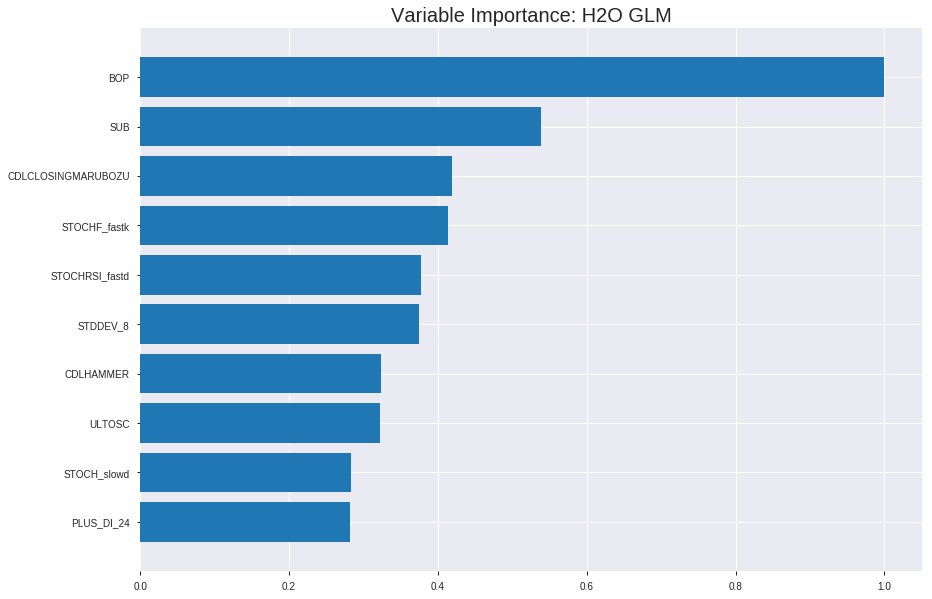

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_164151_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19562645247831853
RMSE: 0.44229679229937735
LogLoss: 0.5747395335031517
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.80418460647
Residual deviance: 2015.0368044620498
AIC: 2117.03680446205
AUC: 0.7713280236357098
pr_auc: 0.7630666383382573
Gini: 0.5426560472714197
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3542036911235481: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      351  501   0.588    (501.0/852.0)
1      77   824   0.0855   (77.0/901.0)
Total  428  1325  0.3297   (578.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354204     0.740341  282
max f2                       0.220036     0.852901  337
max f0point5                 0.555537     0.714786  178
max accuracy                 0.530023     0.702795  193
max precision                0.933198     1         0
max recall                   0.0883804    1         386
max specificity              0.933198     1         0
max absolute_mcc             0.555537     0.405875  178
max min_per_class_accuracy   0.542922     0.699223  185
max mean_per_class_accuracy  0.555537     0.702886  178

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.881003           1.62135   1.62135            0.833333         0.900066  0.833333                    0.900066            0.0166482       0.0166482                  62.1347   62.1347
    2        0.0205362                   0.861302           1.62135   1.62135            0.833333         0.86717   0.833333                    0.883618            0.0166482       0.0332963                  62.1347   62.1347
    3        0.0302339                   0.846146           1.83117   1.68865            0.941176         0.853445  0.867925                    0.87394             0.017758        0.0510544                  83.1168   68.8648
    4        0.040502                    0.832976           1.72944   1.69899            0.888889         0.837662  0.873239                    0.864743            0.017758        0.0688124                  72.9436   69.8989
    5        0.0501997                   0.820804           1.60227   1.6803             0.823529         0.826168  0.863636                    0.857291            0.0155383       0.0843507                  60.2272   68.0305
    6        0.100399                    0.769889           1.76874   1.72452            0.909091         0.794378  0.886364                    0.825834            0.0887902       0.173141                   76.8742   72.4523
    7        0.150029                    0.73557            1.65489   1.70149            0.850575         0.750947  0.874525                    0.801062            0.082131        0.255272                   65.4892   70.1489
    8        0.200228                    0.701059           1.34867   1.61303            0.693182         0.718916  0.82906                     0.780467            0.0677026       0.322974                   34.8666   61.3032
    9        0.300057                    0.648766           1.42308   1.54983            0.731429         0.673287  0.796578                    0.744808            0.142064        0.465039                   42.3079   54.9835
    10       0.399886                    0.599678           1.13402   1.44603            0.582857         0.626317  0.743224                    0.715227            0.113208        0.578246                   13.4016   44.6028
    11       0.500285                    0.544788           1.16074   1.38877            0.596591         0.572077  0.713797                    0.6865              0.116537        0.694784                   16.0737   38.8775
    12       0.600114                    0.478173           0.933896  1.31311            0.48             0.511438  0.674905                    0.657378            0.0932297       0.788013                   -6.61043  31.3106
    13       0.699943                    0.39794            0.756011  1.23365            0.388571         0.439838  0.634067                    0.626351            0.0754717       0.863485                   -24.3989  23.3651
    14       0.799772                    0.313374           0.744893  1.17264            0.382857         0.358291  0.60271                     0.592892            0.0743618       0.937847                   -25.5107  17.2643
    15       0.899601                    0.203867           0.389123  1.0857             0.2              0.257729  0.558022                    0.555699            0.0388457       0.976693                   -61.0877  8.56957
    16       1                           0.0443081          0.232147  1                  0.119318         0.140133  0.513976                    0.513976         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1998079331565867
RMSE: 0.44699880666125574
LogLoss: 0.5827291664013277
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.9613759565244
Residual deviance: 583.8946247341303
AIC: 685.8946247341303
AUC: 0.7576956549767921
pr_auc: 0.7798243756206806
Gini: 0.5153913099535843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33469493066216943: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  121  0.5402   (121.0/224.0)
1      30   247  0.1083   (30.0/277.0)
Total  133  368  0.3014   (151.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334695     0.765891  284
max f2                       0.148074     0.873016  367
max f0point5                 0.450825     0.728088  227
max accuracy                 0.371057     0.706587  267
max precision                0.896718     1         0
max recall                   0.074656     1         390
max specificity              0.896718     1         0
max absolute_mcc             0.371057     0.405071  267
max min_per_class_accuracy   0.528255     0.68231   198
max mean_per_class_accuracy  0.450825     0.697831  227

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.879317           1.80866   1.80866            1                0.888085  1                           0.888085            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.856899           1.44693   1.64424            0.8              0.863338  0.909091                    0.876837            0.0144404       0.0361011                  44.6931   64.424
    3        0.0319361                   0.850004           1.80866   1.69562            1                0.852539  0.9375                      0.869243            0.0180505       0.0541516                  80.8664   69.5623
    4        0.0419162                   0.831687           1.80866   1.72254            1                0.837978  0.952381                    0.861799            0.0180505       0.0722022                  80.8664   72.2537
    5        0.0518962                   0.824109           1.80866   1.7391             1                0.827351  0.961538                    0.855175            0.0180505       0.0902527                  80.8664   73.91
    6        0.101796                    0.786581           1.59162   1.66681            0.88             0.806832  0.921569                    0.831477            0.0794224       0.169675                   59.1625   66.6808
    7        0.151697                    0.749784           1.37458   1.57068            0.76             0.766814  0.868421                    0.810207            0.0685921       0.238267                   37.4585   57.0682
    8        0.201597                    0.716305           1.30224   1.50424            0.72             0.730229  0.831683                    0.79041             0.0649819       0.303249                   30.2238   50.4236
    9        0.301397                    0.648032           1.26606   1.42537            0.7              0.68355   0.788079                    0.755026            0.126354        0.429603                   26.6065   42.5371
    10       0.401198                    0.596823           1.22989   1.37674            0.68             0.620582  0.761194                    0.721582            0.122744        0.552347                   22.9892   37.6744
    11       0.500998                    0.536445           1.12137   1.32587            0.62             0.566128  0.733068                    0.690615            0.111913        0.66426                    12.1372   32.5873
    12       0.600798                    0.443857           1.04903   1.27989            0.58             0.487352  0.707641                    0.656851            0.104693        0.768953                   4.90253   27.9885
    13       0.700599                    0.362345           0.868159  1.22123            0.48             0.399578  0.675214                    0.620202            0.0866426       0.855596                   -13.1841  22.1235
    14       0.800399                    0.289277           0.723466  1.15917            0.4              0.323025  0.640898                    0.583148            0.0722022       0.927798                   -27.6534  15.9169
    15       0.9002                      0.176295           0.506426  1.0868             0.28             0.231319  0.600887                    0.544142            0.0505415       0.978339                   -49.3574  8.68027
    16       1                           0.0187674          0.21704   1                  0.12             0.112653  0.552894                    0.501079            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:41:52  0.000 sec   2            20        49            1.36816           1.36113
    2019-08-25 16:41:52  0.071 sec   4            12        50            1.35919           1.35086
    2019-08-25 16:41:52  0.136 sec   6            7.6       50            1.34667           1.33664
    2019-08-25 16:41:52  0.207 sec   8            4.7       50            1.33019           1.31819
    2019-08-25 16:41:52  0.273 sec   10           2.9       50            1.30993           1.29603
    2019-08-25 16:41:52  0.340 sec   12           1.8       51            1.28679           1.2716
    2019-08-25 16:41:52  0.405 sec   14           1.1       51            1.26239           1.2471
    2019-08-25 16:41:52  0.473 sec   16           0.7       51            1.23847           1.22445
    2019-08-25 16:41:52  0.541 sec   18           0.43      51            1.21656           1.20508
    2019-08-25 16:41:52  0.592 sec   20           0.27      51            1.19749           1.18952
    2019-08-25 16:41:52  0.616 sec   22           0.17      51            1.18147           1.17788
    2019-08-25 16:41:52  0.635 sec   24           0.1       51            1.16831           1.1701
    2019-08-25 16:41:52  0.666 sec   26           0.065     51            1.15774           1.16607
    2019-08-25 16:41:52  0.695 sec   28           0.04      51            1.14948           1.16546
    2019-08-25 16:41:52  0.719 sec   30           0.025     51            1.14325           1.16743
    2019-08-25 16:41:52  0.744 sec   32           0.015     51            1.13868           1.17096
    2019-08-25 16:41:52  0.770 sec   34           0.0096    51            1.13539           1.17509
    2019-08-25 16:41:52  0.805 sec   36           0.006     51            1.1331            1.17917
    2019-08-25 16:41:52  0.831 sec   38           0.0037    51            1.13161           1.18283

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6653386454183267)

('F1', 0.6802721088435374)

('auc', 0.7090190075264703)

('logloss', 0.6781172171683314)

('mean_per_class_error', 0.33872305140961856)

('rmse', 0.4791375701663168)

('mse', 0.22957281114488215)

glm prediction progress: |████████████████████████████████████████████████| 100%


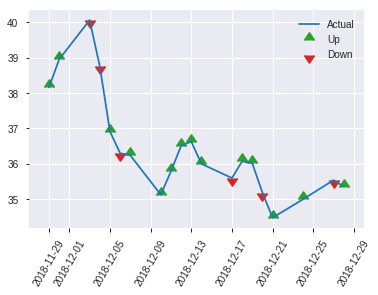


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22957281114488215
RMSE: 0.4791375701663168
LogLoss: 0.6781172171683314
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.1066907598522
Residual deviance: 340.4148430185024
AIC: 442.4148430185024
AUC: 0.7090190075264703
pr_auc: 0.6687944101355574
Gini: 0.4180380150529406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17338337238961793: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   77   0.5746   (77.0/134.0)
1      17   100  0.1453   (17.0/117.0)
Total  74   177  0.3745   (94.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.173383     0.680272  176
max f2                       0.0384265    0.820368  238
max f0point5                 0.455333     0.642994  100
max accuracy                 0.455333     0.665339  100
max precision                0.788956     0.916667  11
max recall                   0.0168053    1         247
max specificity              0.906744     0.992537  0
max absolute_mcc             0.246547     0.329237  151
max min_per_class_accuracy   0.401655     0.656716  122
max mean_per_class_accuracy  0.246547     0.661277  151

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 36.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862308           1.4302    1.4302             0.666667         0.880552   0.666667                    0.880552            0.017094        0.017094                   43.0199   43.0199
    2        0.0239044                   0.819848           2.1453    1.78775            1                0.838756   0.833333                    0.859654            0.025641        0.042735                   114.53    78.7749
    3        0.0318725                   0.812973           2.1453    1.87714            1                0.814582   0.875                       0.848386            0.017094        0.0598291                  114.53    87.7137
    4        0.0438247                   0.794145           2.1453    1.95027            1                0.80048    0.909091                    0.835321            0.025641        0.0854701                  114.53    95.0272
    5        0.0517928                   0.776198           1.07265   1.81525            0.5              0.782957   0.846154                    0.827265            0.00854701      0.0940171                  7.26496   81.5253
    6        0.103586                    0.694523           1.65023   1.73274            0.769231         0.737723   0.807692                    0.782494            0.0854701       0.179487                   65.023    73.2742
    7        0.151394                    0.638636           1.4302    1.6372             0.666667         0.665176   0.763158                    0.745446            0.0683761       0.247863                   43.0199   63.7202
    8        0.203187                    0.586557           1.32018   1.55639            0.615385         0.611614   0.72549                     0.711332            0.0683761       0.316239                   32.0184   55.6393
    9        0.302789                    0.529847           1.28718   1.46784            0.6              0.559518   0.684211                    0.661393            0.128205        0.444444                   28.7179   46.7836
    10       0.40239                     0.455333           1.28718   1.42312            0.6              0.491257   0.663366                    0.61928             0.128205        0.57265                    28.7179   42.3119
    11       0.501992                    0.394222           0.85812   1.31102            0.4              0.428569   0.611111                    0.581441            0.0854701       0.65812                    -14.188   31.1016
    12       0.601594                    0.249721           1.11556   1.27866            0.52             0.316815   0.596026                    0.537629            0.111111        0.769231                   11.5556   27.8655
    13       0.701195                    0.173516           0.772308  1.20673            0.36             0.204681   0.5625                      0.490335            0.0769231       0.846154                   -22.7692  20.6731
    14       0.800797                    0.111185           0.600684  1.13135            0.28             0.142589   0.527363                    0.447083            0.0598291       0.905983                   -39.9316  13.1352
    15       0.900398                    0.0576139          0.42906   1.05366            0.2              0.0819799  0.49115                     0.406695            0.042735        0.948718                   -57.094   5.36646
    16       1                           0.000130157        0.514872  1                  0.24             0.0339651  0.466135                   

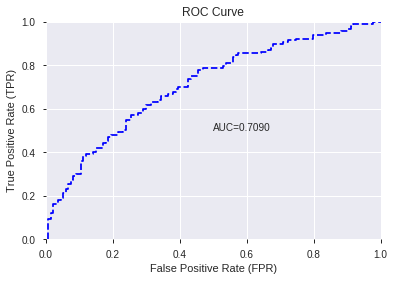

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


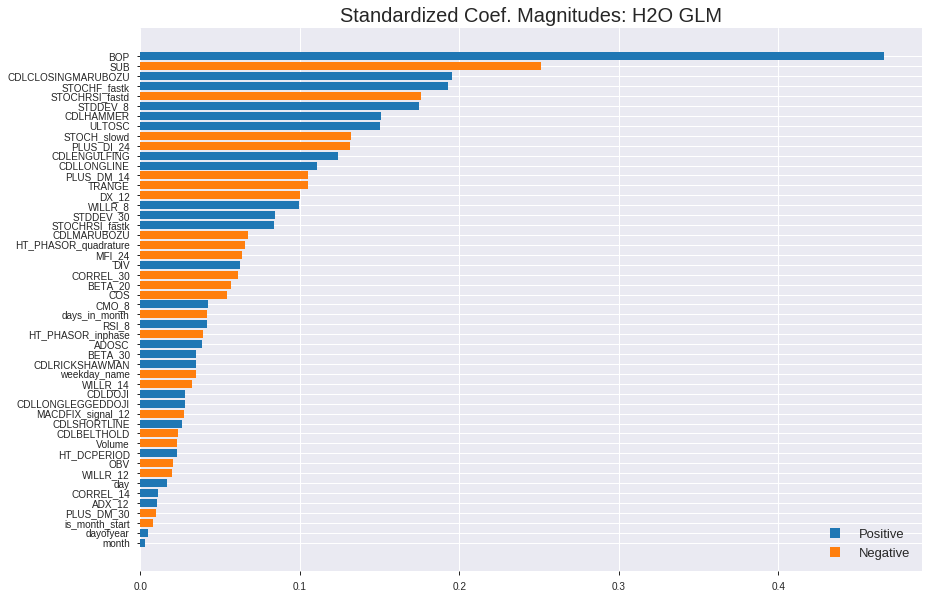

'log_likelihood'
--2019-08-25 16:41:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_164151_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_164151_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'CDLHAMMER',
 'ULTOSC',
 'STOCH_slowd',
 'PLUS_DI_24',
 'CDLENGULFING',
 'CDLLONGLINE',
 'PLUS_DM_14',
 'TRANGE',
 'DX_12',
 'WILLR_8',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'HT_PHASOR_quadrature',
 'MFI_24',
 'DIV',
 'CORREL_30',
 'BETA_20',
 'COS',
 'CMO_8',
 'days_in_month',
 'RSI_8',
 'HT_PHASOR_inphase',
 'ADOSC',
 'BETA_30',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'WILLR_14',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MACDFIX_signal_12',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'Volume',
 'HT_DCPERIOD',
 'OBV',
 'WILLR_12',
 'day',
 'CORREL_14',
 'ADX_12',
 'PLUS_DM_30',
 'is_month_start',
 'dayofyear',
 'month']

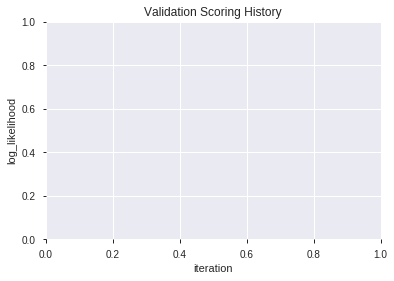

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_164206_model_6  0.742633  0.607564              0.318854  0.459592  0.211225
1  XGBoost_grid_1_AutoML_20190825_164206_model_4  0.736829  0.605552              0.333238  0.458127  0.209880
2               XGBoost_2_AutoML_20190825_164206  0.735744  0.601604              0.310913  0.456396  0.208297
3  XGBoost_grid_1_AutoML_20190825_164206_model_2  0.727708  0.611410              0.293883  0.460640  0.212189
4  XGBoost_grid_1_AutoML_20190825_164206_model_7  0.722988  0.610801              0.316686  0.462162  0.213594
5               XGBoost_1_AutoML_20190825_164206  0.721776  0.613260              0.302909  0.463074  0.214438
6  XGBoost_grid_1_AutoML_20190825_164206_model_1  0.720819  0.610838              0.287441  0.461498  0.212980
7               XGBoost_3_AutoML_20190825_164206  0.719480  0.613887              0.276247  0.463592  0.214917
8  XGBoost_grid_1_AutoML_20190825_164206_model_3  0.719224  0.609708              0.310850  0.460990  0.212512
9  XGBoost_grid_1_AutoML_20190825_164206_model_5  0.715844  0.610974              0.323128  0.461163  0.212671

variable  relative_importance  scaled_importance  percentage
0                    BOP          2065.654541           1.000000    0.207259
1                    SUB           461.812225           0.223567    0.046336
2           STOCHF_fastk           412.753540           0.199817    0.041414
3                 Volume           409.262512           0.198127    0.041064
4         STOCHRSI_fastd           371.524567           0.179858    0.037277
5             PLUS_DI_24           339.377960           0.164296    0.034052
6               STDDEV_8           319.019135           0.154440    0.032009
7                 TRANGE           306.041992           0.148157    0.030707
8                    COS           269.494080           0.130464    0.027040
9      HT_PHASOR_inphase           255.835480           0.123852    0.025669
10                MFI_24           234.330521           0.113441    0.023512
11                 CMO_8           220.585068           0.106787    0.022133
12               BETA_20           212.600082           0.102921    0.021331
13             CORREL_30           207.394547           0.100401    0.020809
14                ULTOSC           206.621552           0.100027    0.020732
15                 ADOSC           203.624023           0.098576    0.020431
16     MACDFIX_signal_12           202.193634           0.097884    0.020287
17            PLUS_DM_14           199.231583           0.096450    0.019990
18              WILLR_14           179.668777           0.086979    0.018027
19               BETA_30           179.451050           0.086874    0.018005
20           STOCH_slowd           179.092484           0.086700    0.017969
21             dayofyear           176.476044           0.085433    0.017707
22                   OBV           176.185608           0.085293    0.017678
23           HT_DCPERIOD           172.642075           0.083577    0.017322
24                ADX_12           171.763657           0.083152    0.017234
25               WILLR_8           171.049255           0.082806    0.017162
26                   day           170.984833           0.082775    0.017156
27            PLUS_DM_30           168.168961           0.081412    0.016873
28             CORREL_14           167.980667           0.081321    0.016854
29  HT_PHASOR_quadrature           162.129410           0.078488    0.016267
30                 DX_12           152.252106           0.073706    0.015276
31              WILLR_12           150.125900           0.072677    0.015063
32                   DIV           144.325256           0.069869    0.014481
33             STDDEV_30           139.319794           0.067446    0.013979
34    CDLCLOSINGMARUBOZU           105.912354           0.051273    0.010627
35        STOCHRSI_fastk           100.219109           0.048517    0.010056
36             CDLHAMMER            63.228027           0.030609    0.006344
37          weekday_name            59.120453           0.028621    0.005932
38           CDLLONGLINE            31.454754           0.015227    0.003156
39                 month            12.891476           0.006241    0.001293
40           CDLBELTHOLD             9.678763           0.004686    0.000971
41          CDLSHORTLINE             8.072783           0.003908    0.000810
42                 RSI_8             6.788175           0.003286    0.000681
43         days_in_month             5.922711           0.002867    0.000594
44          CDLENGULFING             4.285488           0.002075    0.000430

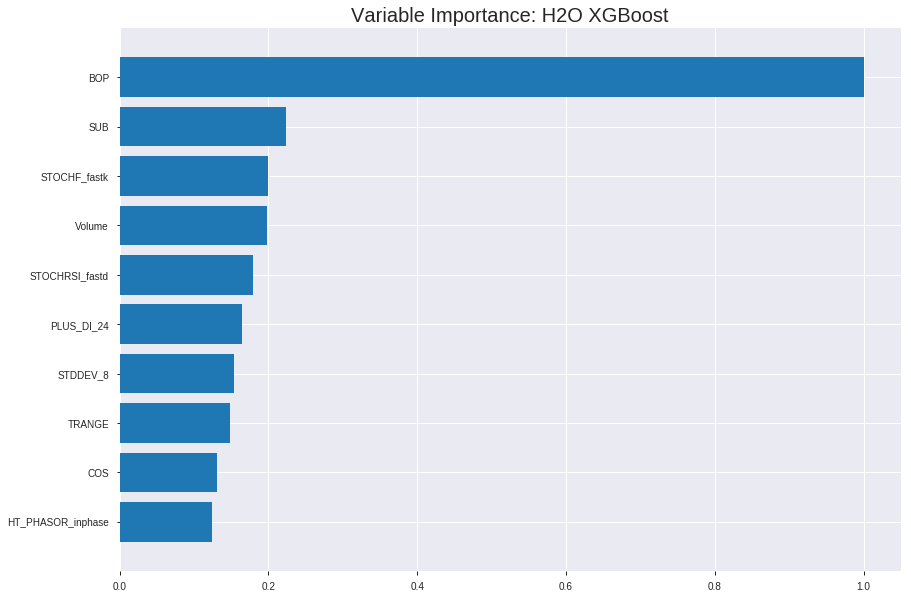

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_164206_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1366183915356283
RMSE: 0.3696192521171324
LogLoss: 0.4401128597922029
Mean Per-Class Error: 0.14346344437323166
AUC: 0.9290915675332051
pr_auc: 0.9371323270891418
Gini: 0.8581831350664102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5191391905148824: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  152  0.1784   (152.0/852.0)
1      105  796  0.1165   (105.0/901.0)
Total  805  948  0.1466   (257.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519139     0.861006  203
max f2                       0.462282     0.892972  230
max f0point5                 0.597542     0.886534  162
max accuracy                 0.555749     0.855676  182
max precision                0.930038     1         0
max recall                   0.193275     1         342
max specificity              0.930038     1         0
max absolute_mcc             0.57707      0.715375  172
max min_per_class_accuracy   0.537651     0.850166  192
max mean_per_class_accuracy  0.555749     0.856537  182

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.896856           1.94562   1.94562            1                0.909787  1                           0.909787            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.883133           1.94562   1.94562            1                0.891079  1                           0.900433            0.0199778       0.0399556                  94.5616   94.5616
    3        0.0302339                   0.872676           1.94562   1.94562            1                0.877831  1                           0.893183            0.0188679       0.0588235                  94.5616   94.5616
    4        0.040502                    0.862081           1.94562   1.94562            1                0.866417  1                           0.886397            0.0199778       0.0788013                  94.5616   94.5616
    5        0.0501997                   0.846828           1.94562   1.94562            1                0.853527  1                           0.880047            0.0188679       0.0976693                  94.5616   94.5616
    6        0.100399                    0.803393           1.94562   1.94562            1                0.823726  1                           0.851886            0.0976693       0.195339                   94.5616   94.5616
    7        0.150029                    0.758179           1.92325   1.93822            0.988506         0.781102  0.996198                    0.828471            0.0954495       0.290788                   92.3253   93.8218
    8        0.200228                    0.720036           1.87929   1.92344            0.965909         0.737742  0.988604                    0.805724            0.0943396       0.385128                   87.9288   92.3444
    9        0.300057                    0.66137            1.77885   1.87534            0.914286         0.688527  0.963878                    0.766733            0.17758         0.562708                   77.8849   87.5337
    10       0.399886                    0.608323           1.60096   1.80684            0.822857         0.634601  0.928673                    0.733747            0.159822        0.722531                   60.0964   80.6842
    11       0.500285                    0.541072           1.21601   1.68827            0.625            0.576739  0.867731                    0.702238            0.122087        0.844617                   21.601    68.8271
    12       0.600114                    0.471205           0.744893  1.53134            0.382857         0.509385  0.787072                    0.670157            0.0743618       0.918979                   -25.5107  53.134
    13       0.699943                    0.395062           0.300181  1.35575            0.154286         0.433366  0.696822                    0.636385            0.0299667       0.948946                   -69.9819  35.5747
    14       0.799772                    0.283376           0.366888  1.23232            0.188571         0.340348  0.633381                    0.599433            0.036626        0.985572                   -63.3112  23.2316
    15       0.899601                    0.156984           0.144531  1.1116             0.0742857        0.216164  0.571338                    0.556902            0.0144284       1                          -85.5469  11.1604
    16       1                           0.0602378          0         1                  0                0.118756  0.513976                    0.512912          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20374276234614086
RMSE: 0.45137873492904035
LogLoss: 0.5932762097466365
Mean Per-Class Error: 0.30216928829293455
AUC: 0.7478162068076327
pr_auc: 0.7605913152364331
Gini: 0.49563241361526544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34898513555526733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   129  0.5759   (129.0/224.0)
1      28   249  0.1011   (28.0/277.0)
Total  123  378  0.3134   (157.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348985     0.760305  290
max f2                       0.162369     0.870804  372
max f0point5                 0.451161     0.728088  221
max accuracy                 0.451161     0.704591  221
max precision                0.916651     1         0
max recall                   0.0988362    1         394
max specificity              0.916651     1         0
max absolute_mcc             0.451161     0.399229  221
max min_per_class_accuracy   0.504623     0.67509   195
max mean_per_class_accuracy  0.451161     0.697831  221

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.888818           1.80866   1.80866            1                0.904383  1                           0.904383            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.867489           1.80866   1.80866            1                0.874933  1                           0.890997            0.0180505       0.0397112                  80.8664   80.8664
    3        0.0319361                   0.849446           1.80866   1.80866            1                0.857775  1                           0.880615            0.0180505       0.0577617                  80.8664   80.8664
    4        0.0419162                   0.835223           1.0852    1.63641            0.6              0.839084  0.904762                    0.870727            0.0108303       0.0685921                  8.51986   63.6411
    5        0.0518962                   0.82879            1.44693   1.59997            0.8              0.832445  0.884615                    0.863365            0.0144404       0.0830325                  44.6931   59.9972
    6        0.101796                    0.788106           1.44693   1.52495            0.8              0.808306  0.843137                    0.836375            0.0722022       0.155235                   44.6931   52.4952
    7        0.151697                    0.73632            1.37458   1.47549            0.76             0.757376  0.815789                    0.810389            0.0685921       0.223827                   37.4585   47.5489
    8        0.201597                    0.711311           1.44693   1.46842            0.8              0.724749  0.811881                    0.789191            0.0722022       0.296029                   44.6931   46.842
    9        0.301397                    0.639587           1.41076   1.44933            0.78             0.675149  0.801325                    0.751429            0.140794        0.436823                   41.0758   44.9327
    10       0.401198                    0.590604           1.0852    1.35875            0.6              0.610448  0.751244                    0.716359            0.108303        0.545126                   8.51986   35.8748
    11       0.500998                    0.514009           1.04903   1.29705            0.58             0.549833  0.717131                    0.683186            0.104693        0.649819                   4.90253   29.705
    12       0.600798                    0.44504            1.22989   1.28589            0.68             0.476816  0.710963                    0.648906            0.122744        0.772563                   22.9892   28.5894
    13       0.700599                    0.384765           0.795812  1.21608            0.44             0.419895  0.672365                    0.616283            0.0794224       0.851986                   -20.4188  21.6082
    14       0.800399                    0.293313           0.759639  1.15917            0.42             0.346472  0.640898                    0.582641            0.0758123       0.927798                   -24.0361  15.9169
    15       0.9002                      0.199746           0.434079  1.07878            0.24             0.252576  0.596452                    0.546048            0.0433213       0.971119                   -56.5921  7.8782
    16       1                           0.0825403          0.289386  1                  0.16             0.148085  0.552894                    0.506331            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:42:28  6.996 sec   0                  0.5              0.693147            0.5             0                  1                0.486024                         0.5                0.693147              0.5               0                    1                  0.447106
    2019-08-25 16:42:28  7.054 sec   5                  0.472904         0.640078            0.837091        0.845354           1.94562          0.247576                         0.482703           0.658939              0.731498          0.73851              1.50722            0.303393
    2019-08-25 16:42:28  7.091 sec   10                 0.452113         0.600121            0.85253         0.856054           1.94562          0.229892                         0.472894           0.639594              0.73622           0.736314             1.50722            0.317365
    2019-08-25 16:42:28  7.131 sec   15                 0.436213         0.569351            0.866001        0.871208           1.94562          0.225898                         0.463516           0.620805              0.74224           0.749828             1.80866            0.329341
    2019-08-25 16:42:28  7.177 sec   20                 0.423582         0.544949            0.878875        0.883976           1.94562          0.207644                         0.459118           0.611557              0.743489          0.755981             1.50722            0.327345
    2019-08-25 16:42:28  7.219 sec   25                 0.412681         0.523464            0.88803         0.894353           1.94562          0.201369                         0.456281           0.605258              0.743441          0.757839             1.80866            0.327345
    2019-08-25 16:42:28  7.259 sec   30                 0.404777         0.507936            0.895685        0.904042           1.94562          0.186537                         0.454828           0.602064              0.743134          0.754735             1.80866            0.321357
    2019-08-25 16:42:28  7.302 sec   35                 0.398367         0.494975            0.901557        0.910244           1.94562          0.174558                         0.453498           0.599071              0.744988          0.754591             1.80866            0.305389
    2019-08-25 16:42:28  7.347 sec   40                 0.392459         0.48297             0.905615        0.913037           1.94562          0.175699                         0.45202            0.595788              0.747067          0.759114             1.80866            0.295409
    2019-08-25 16:42:28  7.395 sec   45                 0.385925         0.470539            0.911436        0.920066           1.94562          0.175699                         0.451586           0.594493              0.747131          0.758822             1.80866            0.303393
    2019-08-25 16:42:28  7.449 sec   50                 0.379583         0.458893            0.919157        0.927656           1.94562          0.156874                         0.452614           0.596289              0.745141          0.759186             1.80866            0.307385
    2019-08-25 16:42:28  7.491 sec   55                 0.375929         0.451487            0.922353        0.930479           1.94562          0.153451                         0.45174            0.594253              0.745673          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2065.654541015625      1.0                    0.20725879679778736
SUB             461.8122253417969      0.223567017704101      0.0463362310930216
STOCHF_fastk    412.7535400390625      0.1998173130324701     0.04141389587847659
Volume          409.26251220703125     0.19812727834239321    0.04106362132206473
STOCHRSI_fastd  371.5245666503906      0.17985803495860558    0.037277159919934966
---             ---                    ---                    ---
CDLBELTHOLD     9.678763389587402      0.004685567309250376   0.0009711250428302789
CDLSHORTLINE    8.072782516479492      0.0039080990340767865  0.0008099879035693497
RSI_8           6.788174629211426      0.0032862100096727057  0.0006810959326296102
days_in_month   5.922711372375488      0.0028672322766339505  0.0005942591117949331
CDLENGULFING    4.285488128662109      0.002074639318225522   0.0004299872488848035


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7181208053691276)

('auc', 0.7426329889016456)

('logloss', 0.6075641081362004)

('mean_per_class_error', 0.2955096313305269)

('rmse', 0.4595917872100297)

('mse', 0.2112246108709092)

xgboost prediction progress: |████████████████████████████████████████████| 100%


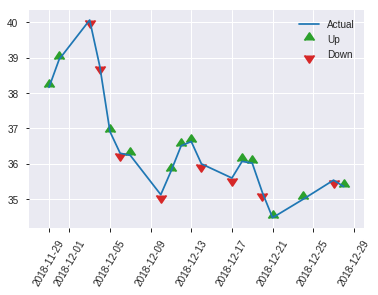


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2112246108709092
RMSE: 0.4595917872100297
LogLoss: 0.6075641081362004
Mean Per-Class Error: 0.2955096313305269
AUC: 0.7426329889016456
pr_auc: 0.6762976008837202
Gini: 0.4852659778032913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26777589321136475: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   74   0.5522   (74.0/134.0)
1      10   107  0.0855   (10.0/117.0)
Total  70   181  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267776     0.718121  180
max f2                       0.168242     0.845376  223
max f0point5                 0.358173     0.667145  144
max accuracy                 0.358173     0.697211  144
max precision                0.81055      1         0
max recall                   0.168242     1         223
max specificity              0.81055      1         0
max absolute_mcc             0.35108      0.415389  148
max min_per_class_accuracy   0.394684     0.671642  122
max mean_per_class_accuracy  0.35108      0.70449   148

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 39.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.77712            2.1453    2.1453             1                0.792751  1                           0.792751            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.754649           1.4302    1.78775            0.666667         0.764262  0.833333                    0.778506            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.742813           1.07265   1.60897            0.5              0.747657  0.75                        0.770794            0.00854701      0.0512821                  7.26496   60.8974
    4        0.0438247                   0.731625           1.4302    1.56022            0.666667         0.734357  0.727273                    0.760857            0.017094        0.0683761                  43.0199   56.0218
    5        0.0517928                   0.700058           2.1453    1.65023            1                0.709925  0.769231                    0.753021            0.017094        0.0854701                  114.53    65.023
    6        0.103586                    0.635451           1.65023   1.65023            0.769231         0.672798  0.769231                    0.71291             0.0854701       0.17094                    65.023    65.023
    7        0.151394                    0.57727            1.60897   1.6372             0.75             0.610382  0.763158                    0.680532            0.0769231       0.247863                   60.8974   63.7202
    8        0.203187                    0.548674           1.48521   1.59846            0.692308         0.563324  0.745098                    0.650656            0.0769231       0.324786                   48.5207   59.8458
    9        0.302789                    0.497864           1.20137   1.46784            0.56             0.521687  0.684211                    0.608232            0.119658        0.444444                   20.1368   46.7836
    10       0.40239                     0.443401           1.20137   1.40188            0.56             0.468174  0.653465                    0.573564            0.119658        0.564103                   20.1368   40.1879
    11       0.501992                    0.389201           1.28718   1.37912            0.6              0.417116  0.642857                    0.542523            0.128205        0.692308                   28.7179   37.9121
    12       0.601594                    0.345564           1.20137   1.34969            0.56             0.368749  0.629139                    0.513752            0.119658        0.811966                   20.1368   34.9692
    13       0.701195                    0.287218           0.686496  1.25549            0.32             0.313472  0.585227                    0.485303            0.0683761       0.880342                   -31.3504  25.5488
    14       0.800797                    0.215649           0.42906   1.1527             0.2              0.243415  0.537313                    0.455218            0.042735        0.923077                   -57.094   15.2698
    15       0.900398                    0.16271            0.772308  1.11062            0.36             0.187994  0.517699                    0.425657            0.0769231       1                          -22.7692  11.0619
    16       1                           0.0964378          0         1                  0                0.13491   0.466135                    0.396699            

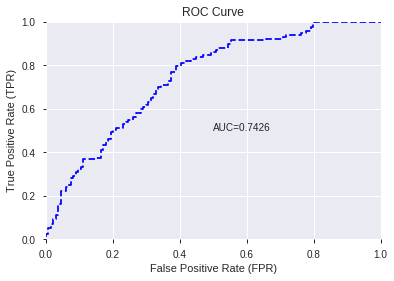

This function is available for GLM models only


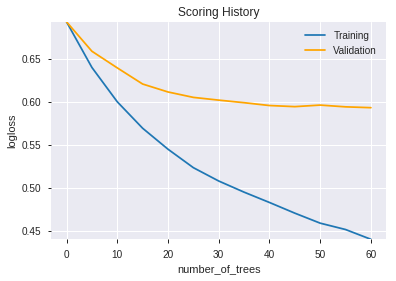

--2019-08-25 16:42:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_164206_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_164206_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'STOCHF_fastk',
 'Volume',
 'STOCHRSI_fastd',
 'PLUS_DI_24',
 'STDDEV_8',
 'TRANGE',
 'COS',
 'HT_PHASOR_inphase',
 'MFI_24',
 'CMO_8',
 'BETA_20',
 'CORREL_30',
 'ULTOSC',
 'ADOSC',
 'MACDFIX_signal_12',
 'PLUS_DM_14',
 'WILLR_14',
 'BETA_30',
 'STOCH_slowd',
 'dayofyear',
 'OBV',
 'HT_DCPERIOD',
 'ADX_12',
 'WILLR_8',
 'day',
 'PLUS_DM_30',
 'CORREL_14',
 'HT_PHASOR_quadrature',
 'DX_12',
 'WILLR_12',
 'DIV',
 'STDDEV_30',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'weekday_name',
 'CDLLONGLINE',
 'month',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'RSI_8',
 'days_in_month',
 'CDLENGULFING']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_164244_model_1  0.5  16.099748                   0.5  0.682741  0.466135

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.009319           1.000000    0.025708
1                CDLLONGLINE             0.006551           0.702989    0.018072
2         CDLCLOSINGMARUBOZU             0.005912           0.634405    0.016309
3               STOCHF_fastk             0.005868           0.629717    0.016189
4             STOCHRSI_fastk             0.005335           0.572539    0.014719
...                      ...                  ...                ...         ...
1037             MIDPOINT_12             0.000004           0.000383    0.000010
1038                  VAR_14             0.000002           0.000244    0.000006
1039  LINEARREG_INTERCEPT_24             0.000001           0.000148    0.000004
1040                MAVP_8_2             0.000001           0.000138    0.000004
1041           CDLHIKKAKEMOD             0.000000           0.000000    0.000000

[1042 rows x 4 columns]

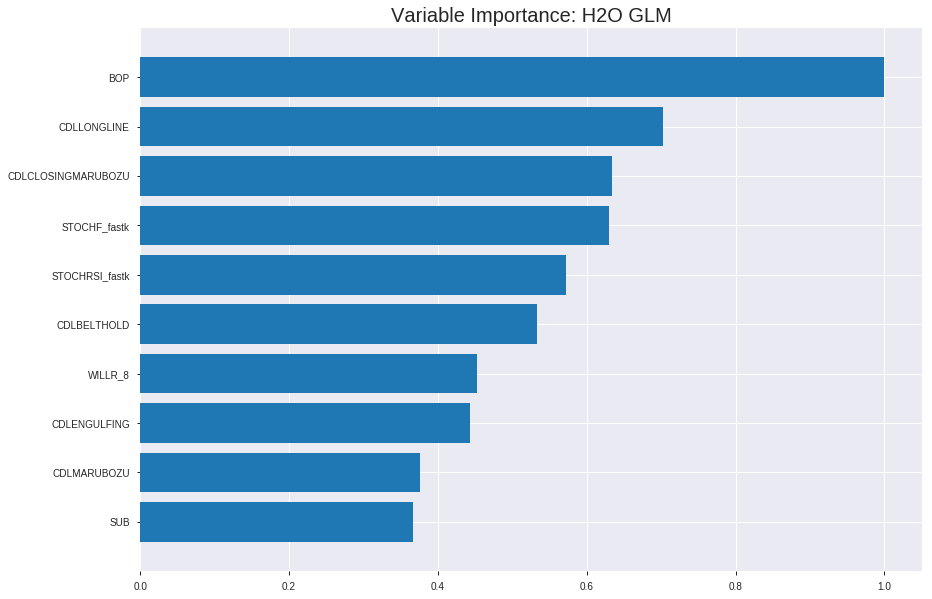

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_164244_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24322036724427865
RMSE: 0.4931737698258887
LogLoss: 0.6795472872825652
Null degrees of freedom: 1752
Residual degrees of freedom: 711
Null deviance: 2428.80418460647
Residual deviance: 2382.492789212673
AIC: 4466.4927892126725
AUC: 0.6419777451240928
pr_auc: 0.6090127424975705
Gini: 0.28395549024818556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4714189803194624: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      127  725   0.8509   (725.0/852.0)
1      39   862   0.0433   (39.0/901.0)
Total  166  1587  0.4358   (764.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471419     0.692926  345
max f2                       0.450154     0.843328  385
max f0point5                 0.498188     0.637098  259
max accuracy                 0.498188     0.629207  259
max precision                0.627902     1         0
max recall                   0.438675     1         394
max specificity              0.627902     1         0
max absolute_mcc             0.498188     0.260224  259
max min_per_class_accuracy   0.508381     0.611502  224
max mean_per_class_accuracy  0.498188     0.625662  259

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.606361           1.0809    1.0809             0.555556         0.613091  0.555556                    0.613091            0.0110988       0.0110988                  8.08978   8.08978
    2        0.0205362                   0.599918           1.18899   1.13494            0.611111         0.602884  0.583333                    0.607987            0.0122087       0.0233074                  18.8988   13.4943
    3        0.0302339                   0.592585           1.25893   1.17471            0.647059         0.595575  0.603774                    0.604006            0.0122087       0.0355161                  25.8928   17.4712
    4        0.040502                    0.589711           1.0809    1.15093            0.555556         0.591344  0.591549                    0.600796            0.0110988       0.0466149                  8.08978   15.0928
    5        0.0501997                   0.585088           1.25893   1.17179            0.647059         0.587725  0.602273                    0.598271            0.0122087       0.0588235                  25.8928   17.1791
    6        0.100399                    0.570811           1.23812   1.20496            0.636364         0.577417  0.619318                    0.587844            0.0621532       0.120977                   23.8119   20.4955
    7        0.150029                    0.555822           1.25235   1.22063            0.643678         0.563024  0.627376                    0.579634            0.0621532       0.18313                    25.2351   22.0634
    8        0.200228                    0.541708           1.10546   1.19176            0.568182         0.547988  0.612536                    0.5717              0.0554939       0.238624                   10.5464   19.1759
    9        0.300057                    0.526016           1.34525   1.24283            0.691429         0.53313   0.638783                    0.558868            0.134295        0.372919                   34.5254   24.2827
    10       0.399886                    0.517256           1.18961   1.22954            0.611429         0.521517  0.631954                    0.549543            0.118757        0.491676                   18.9605   22.954
    11       0.500285                    0.508658           1.16074   1.21573            0.596591         0.512758  0.624857                    0.542161            0.116537        0.608213                   16.0737   21.5733
    12       0.600114                    0.500438           1.08954   1.19474            0.56             0.504377  0.614068                    0.535876            0.108768        0.716981                   8.9545    19.4741
    13       0.699943                    0.493427           0.922778  1.15595            0.474286         0.496689  0.594132                    0.530287            0.0921199       0.809101                   -7.72221  15.5953
    14       0.799772                    0.484233           0.678186  1.09632            0.348571         0.488763  0.563481                    0.525104            0.0677026       0.876804                   -32.1814  9.63171
    15       0.899601                    0.472307           0.733775  1.05609            0.377143         0.478485  0.542803                    0.51993             0.0732519       0.950055                   -26.6225  5.60858
    16       1                           0.429096           0.497459  1                  0.255682         0.460621  0.513976                    0.513976          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.37946155891961075
RMSE: 0.6160045120935486
LogLoss: 6.2914326392017665
Null degrees of freedom: 500
Residual degrees of freedom: -541
Null deviance: 691.9613759565244
Residual deviance: 77102.35842757877
AIC: 79186.35842757877
AUC: 0.5370036101083032
pr_auc: 0.6090868167907655
Gini: 0.07400722021660644
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.3496448325728774e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    277  0        (0.0/277.0)
Total  0    501  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.34964e-48  0.712082  388
max f2                       4.34964e-48  0.860783  388
max f0point5                 4.34964e-48  0.60719   388
max accuracy                 4.34964e-48  0.552894  388
max precision                0.530918     1         0
max recall                   4.34964e-48  1         388
max specificity              0.530918     1         0
max absolute_mcc             0.470473     0.132161  64
max min_per_class_accuracy   0.243909     0.512635  250
max mean_per_class_accuracy  0.470473     0.544659  64

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 22.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.517058           1.50722   1.50722            0.833333         0.523682     0.833333                    0.523682            0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.507738           1.44693   1.47982            0.8              0.511869     0.818182                    0.518313            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.504692           1.0852    1.3565             0.6              0.505655     0.75                        0.514357            0.0108303       0.0433213                  8.51986   35.6498
    4        0.0419162                   0.498005           1.44693   1.37803            0.8              0.500846     0.761905                    0.51114             0.0144404       0.0577617                  44.6931   37.803
    5        0.0518962                   0.494366           1.44693   1.39128            0.8              0.495722     0.769231                    0.508175            0.0144404       0.0722022                  44.6931   39.128
    6        0.101796                    0.478997           1.0852    1.24124            0.6              0.484872     0.686275                    0.496752            0.0541516       0.126354                   8.51986   24.124
    7        0.151697                    0.465654           1.0852    1.18991            0.6              0.471175     0.657895                    0.488338            0.0541516       0.180505                   8.51986   18.9911
    8        0.201597                    0.452106           1.15755   1.1819             0.64             0.458874     0.653465                    0.481045            0.0577617       0.238267                   15.7545   18.1899
    9        0.301397                    0.396749           0.940505  1.10197            0.52             0.42616      0.609272                    0.462871            0.0938628       0.33213                    -5.94946  10.1968
    10       0.401198                    0.314542           0.904332  1.0528             0.5              0.360298     0.58209                     0.437355            0.0902527       0.422383                   -9.56679  5.28046
    11       0.500998                    0.243909           0.904332  1.02323            0.5              0.279186     0.565737                    0.405848            0.0902527       0.512635                   -9.56679  2.32284
    12       0.600798                    0.147598           1.12137   1.03953            0.62             0.197711     0.574751                    0.371273            0.111913        0.624549                   12.1372   3.95313
    13       0.700599                    2.80389e-09        0.831986  1.00997            0.46             0.0483614    0.558405                    0.325275            0.0830325       0.707581                   -16.8014  0.996637
    14       0.800399                    5.84397e-91        0.904332  0.996795           0.5              2.59265e-11  0.551122                    0.284717            0.0902527       0.797834                   -9.56679  -0.320498
    15       1                           0                  1.01285   1                  0.56             1.07102e-94  0.552894                    0.227887            0.202166        1                          1.2852    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:42:47  0.000 sec   2            20        1042          1.35909           153.897
    2019-08-25 16:42:49  2.074 sec   4            14        1042          1.35231           162.158
    2019-08-25 16:42:53  5.346 sec   6            10        1042          1.34374           168.841
    2019-08-25 16:42:55  7.373 sec   8            7.6       1043          1.33322           175.008
    2019-08-25 16:42:57  9.429 sec   10           5.5       1043          1.32058           181.238

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.46613545816733065)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6358695652173912)

('auc', 0.5)

('logloss', 16.099748359380666)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.6827411355465046)

('mse', 0.46613545816733065)

glm prediction progress: |████████████████████████████████████████████████| 100%


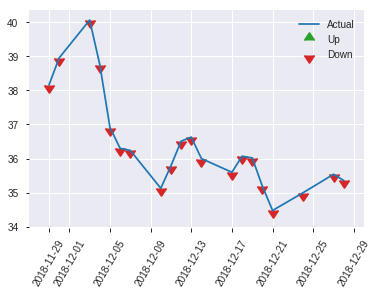


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.46613545816733065
RMSE: 0.6827411355465046
LogLoss: 16.099748359380666
Null degrees of freedom: 250
Residual degrees of freedom: -791
Null deviance: 349.1066907598522
Residual deviance: 165764.76193654977
AIC: 167848.76193654977
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    134  1        (134.0/134.0)
1      0    117  0        (0.0/117.0)
Total  0    251  0.5339   (134.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.63587   0
max f2                       0            0.81363   0
max f0point5                 0            0.521855  0
max accuracy                 0            0.466135  0
max precision                0            0.466135  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 46.61 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.466135         0        0.466135                    0                   1               1                          0       0

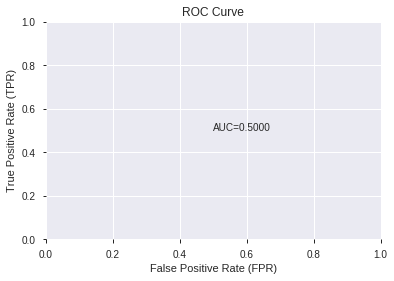

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


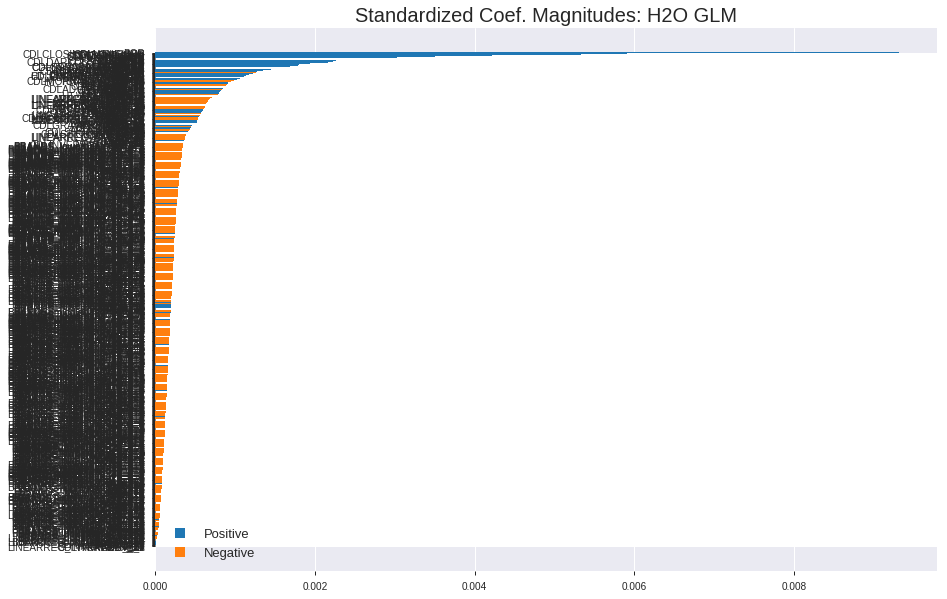

'log_likelihood'
--2019-08-25 16:43:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_164244_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_164244_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

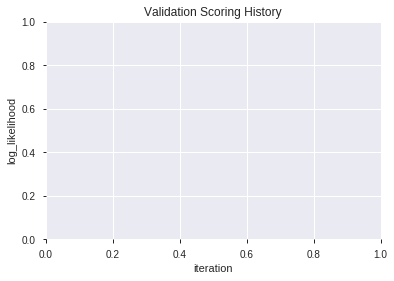

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190825_164325  0.746460  0.613416              0.323128  0.462435  0.213846
1  XGBoost_grid_1_AutoML_20190825_164325_model_3  0.744164  0.637841              0.295988  0.475436  0.226039
2  XGBoost_grid_1_AutoML_20190825_164325_model_4  0.742442  0.613326              0.312412  0.463012  0.214380
3               XGBoost_2_AutoML_20190825_164325  0.739954  0.613122              0.306640  0.462951  0.214323
4               XGBoost_3_AutoML_20190825_164325  0.734851  0.629766              0.301346  0.471599  0.222406
5  XGBoost_grid_1_AutoML_20190825_164325_model_2  0.728983  0.619330              0.290694  0.465462  0.216655
6  XGBoost_grid_1_AutoML_20190825_164325_model_6  0.723370  0.622218              0.323670  0.466687  0.217796
7  XGBoost_grid_1_AutoML_20190825_164325_model_7  0.721776  0.652651              0.302972  0.481186  0.231540
8  XGBoost_grid_1_AutoML_20190825_164325_model_1  0.714568  0.632523              0.310850  0.473470  0.224174
9  XGBoost_grid_1_AutoML_20190825_164325_model_5  0.694094  0.654793              0.373198  0.482348  0.232660

variable  relative_importance  scaled_importance  percentage
0                        BOP          1658.174438           1.000000    0.150198
1               STOCHF_fastk           498.920837           0.300886    0.045192
2                        SUB           350.880859           0.211607    0.031783
3                     TRANGE           213.403137           0.128698    0.019330
4                   CORREL_8           159.245407           0.096037    0.014424
..                       ...                  ...                ...         ...
389  BBANDS_upperband_12_4_3             0.449818           0.000271    0.000041
390                MACDFIX_8             0.398874           0.000241    0.000036
391  BBANDS_upperband_30_2_2             0.355106           0.000214    0.000032
392  BBANDS_upperband_24_7_5             0.310476           0.000187    0.000028
393   BBANDS_upperband_8_7_2             0.175562           0.000106    0.000016

[394 rows x 4 columns]

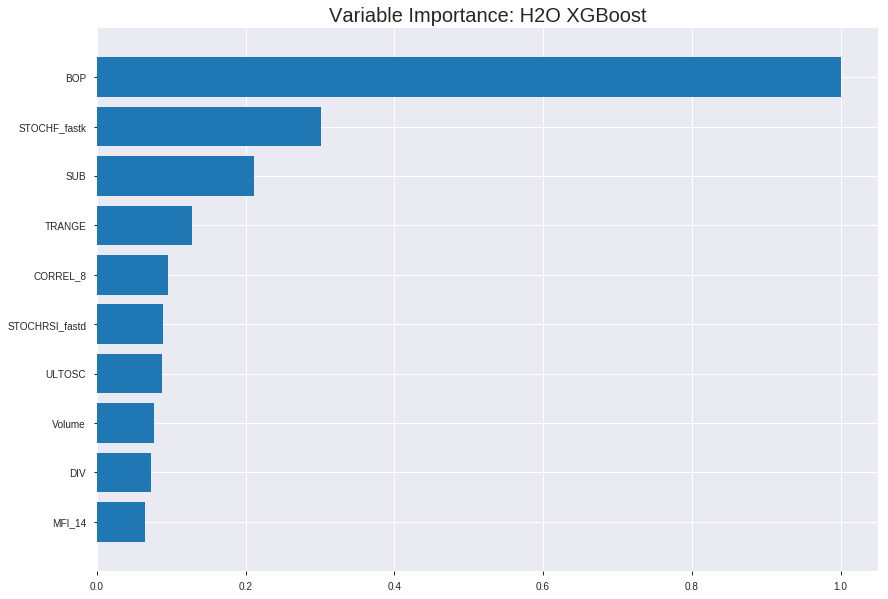

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190825_164325


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10075423697909595
RMSE: 0.31741807916231857
LogLoss: 0.35903385927589826
Mean Per-Class Error: 0.07158191472177489
AUC: 0.9761995018576125
pr_auc: 0.9790792657529884
Gini: 0.952399003715225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5337634384632111: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      800  52   0.061    (52.0/852.0)
1      74   827  0.0821   (74.0/901.0)
Total  874  879  0.0719   (126.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.533763     0.929213  186
max f2                       0.418688     0.93797   234
max f0point5                 0.58714      0.944295  165
max accuracy                 0.533763     0.928123  186
max precision                0.936445     1         0
max recall                   0.211026     1         332
max specificity              0.936445     1         0
max absolute_mcc             0.533763     0.856505  186
max min_per_class_accuracy   0.522521     0.922309  191
max mean_per_class_accuracy  0.533763     0.928418  186

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.901603           1.94562    1.94562            1                0.910407  1                           0.910407            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.889686           1.94562    1.94562            1                0.89416   1                           0.902283            0.0199778       0.0399556                  94.5616   94.5616
    3        0.0302339                   0.880099           1.94562    1.94562            1                0.885028  1                           0.896749            0.0188679       0.0588235                  94.5616   94.5616
    4        0.040502                    0.873648           1.94562    1.94562            1                0.876831  1                           0.891699            0.0199778       0.0788013                  94.5616   94.5616
    5        0.0501997                   0.864733           1.94562    1.94562            1                0.868706  1                           0.887257            0.0188679       0.0976693                  94.5616   94.5616
    6        0.100399                    0.833963           1.94562    1.94562            1                0.84995   1                           0.868603            0.0976693       0.195339                   94.5616   94.5616
    7        0.150029                    0.805276           1.94562    1.94562            1                0.819411  1                           0.852331            0.0965594       0.291898                   94.5616   94.5616
    8        0.200228                    0.779735           1.94562    1.94562            1                0.792303  1                           0.837281            0.0976693       0.389567                   94.5616   94.5616
    9        0.300057                    0.718021           1.92338    1.93822            0.988571         0.751682  0.996198                    0.808802            0.192009        0.581576                   92.338    93.8218
    10       0.399886                    0.640115           1.87891    1.92341            0.965714         0.682159  0.988588                    0.777187            0.187569        0.769145                   87.8909   92.3412
    11       0.500285                    0.534159           1.47027    1.83247            0.755682         0.588999  0.941847                    0.73942             0.147614        0.916759                   47.0267   83.2473
    12       0.600114                    0.418584           0.511419   1.61272            0.262857         0.47834   0.828897                    0.69599             0.0510544       0.967814                   -48.8581  61.2716
    13       0.699943                    0.324155           0.189003   1.40966            0.0971429        0.372599  0.724531                    0.649866            0.0188679       0.986681                   -81.0997  40.966
    14       0.799772                    0.235783           0.111178   1.24758            0.0571429        0.279822  0.641227                    0.603677            0.0110988       0.99778                    -88.8822  24.7581
    15       0.899601                    0.153995           0.0222356  1.1116             0.0114286        0.192323  0.571338                    0.558029            0.00221976      1                          -97.7764  11.1604
    16       1                           0.0533082          0          1                  0                0.117229  0.513976                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2120676167493444
RMSE: 0.4605079985726029
LogLoss: 0.6107548488078182
Mean Per-Class Error: 0.2960369391438886
AUC: 0.7521032104177411
pr_auc: 0.7642059790277085
Gini: 0.5042064208354822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29042908549308777: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      96   128  0.5714   (128.0/224.0)
1      22   255  0.0794   (22.0/277.0)
Total  118  383  0.2994   (150.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290429     0.772727  304
max f2                       0.189104     0.871648  364
max f0point5                 0.360639     0.730301  253
max accuracy                 0.360639     0.716567  253
max precision                0.864559     1         0
max recall                   0.141485     1         385
max specificity              0.864559     1         0
max absolute_mcc             0.346031     0.423873  261
max min_per_class_accuracy   0.430169     0.66065   201
max mean_per_class_accuracy  0.360639     0.703963  253

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 45.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.820394           1.80866   1.80866            1                0.84056   1                           0.84056             0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.80288            1.44693   1.64424            0.8              0.808816  0.909091                    0.826131            0.0144404       0.0361011                  44.6931   64.424
    3        0.0319361                   0.789632           1.80866   1.69562            1                0.794491  0.9375                      0.816244            0.0180505       0.0541516                  80.8664   69.5623
    4        0.0419162                   0.778371           1.80866   1.72254            1                0.783807  0.952381                    0.80852             0.0180505       0.0722022                  80.8664   72.2537
    5        0.0518962                   0.762504           1.44693   1.66954            0.8              0.768713  0.923077                    0.800865            0.0144404       0.0866426                  44.6931   66.9536
    6        0.101796                    0.718478           1.22989   1.45402            0.68             0.737845  0.803922                    0.769973            0.0613718       0.148014                   22.9892   45.4024
    7        0.151697                    0.679737           1.66397   1.52309            0.92             0.698592  0.842105                    0.746493            0.0830325       0.231047                   66.3971   52.3086
    8        0.201597                    0.64644            1.51928   1.52214            0.84             0.663803  0.841584                    0.726025            0.0758123       0.306859                   51.9278   52.2143
    9        0.301397                    0.565924           1.22989   1.42537            0.68             0.603336  0.788079                    0.685399            0.122744        0.429603                   22.9892   42.5371
    10       0.401198                    0.497631           1.12137   1.34975            0.62             0.529345  0.746269                    0.64658             0.111913        0.541516                   12.1372   34.9749
    11       0.500998                    0.435272           1.01285   1.28264            0.56             0.460999  0.709163                    0.609611            0.101083        0.642599                   1.2852    28.2638
    12       0.600798                    0.383666           1.33841   1.2919             0.74             0.410185  0.714286                    0.576484            0.133574        0.776173                   33.8412   29.1903
    13       0.700599                    0.323391           0.831986  1.22639            0.46             0.352518  0.678063                    0.54458             0.0830325       0.859206                   -16.8014  22.6388
    14       0.800399                    0.270671           0.687292  1.15917            0.38             0.299799  0.640898                    0.514059            0.0685921       0.927798                   -31.2708  15.9169
    15       0.9002                      0.195316           0.470253  1.08279            0.26             0.233482  0.59867                     0.482953            0.0469314       0.974729                   -52.9747  8.27924
    16       1                           0.0826744          0.253213  1                  0.14             0.1545    0.552894                    0.450173          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:43:26  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.486024                         0.5                0.693147              0.5               0                    1                  0.447106
    2019-08-25 16:43:27  0.896 sec   5                  0.469697         0.634014            0.873344        0.880872           1.94562          0.211637                         0.487324           0.667995              0.721844          0.725939             1.2919             0.347305
    2019-08-25 16:43:27  1.198 sec   10                 0.444353         0.586117            0.902258        0.91266            1.94562          0.187678                         0.477493           0.648562              0.735922          0.749958             1.20578            0.323353
    2019-08-25 16:43:27  1.419 sec   15                 0.423177         0.546783            0.919099        0.927034           1.94562          0.163719                         0.471142           0.635722              0.745681          0.753129             1.50722            0.315369
    2019-08-25 16:43:27  1.638 sec   20                 0.405584         0.514464            0.931991        0.939933           1.94562          0.146606                         0.464474           0.622317              0.753771          0.763289             1.50722            0.301397
    2019-08-25 16:43:28  1.871 sec   25                 0.390787         0.487149            0.938874        0.946589           1.94562          0.135767                         0.4612             0.615149              0.754319          0.766051             1.80866            0.305389
    2019-08-25 16:43:28  2.087 sec   30                 0.378017         0.463951            0.946223        0.952854           1.94562          0.123217                         0.459056           0.610774              0.756737          0.770974             1.80866            0.317365
    2019-08-25 16:43:28  2.317 sec   35                 0.365571         0.441853            0.953769        0.958667           1.94562          0.115231                         0.459429           0.610658              0.756632          0.768107             1.80866            0.319361
    2019-08-25 16:43:28  2.556 sec   40                 0.354258         0.42186             0.959135        0.962774           1.94562          0.102111                         0.458222           0.607746              0.755544          0.768228             1.80866            0.307385
    2019-08-25 16:43:29  2.769 sec   45                 0.343881         0.403841            0.964787        0.967349           1.94562          0.0969766                        0.458559           0.608362              0.754593          0.768307             1.80866            0.283433
    2019-08-25 16:43:29  2.988 sec   50                 0.335007         0.388503            0.968755        0.97079            1.94562          0.0907017                        0.458433           0.607483              0.753554          0.765845             1.80866            0.303393
    2019-08-25 16:43:29  3.209 sec   55                 0.325851         0.373182            0.972843        0.975768           1.94562          0.081004                         0.459386           0.608823              0.754932          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1658.1744384765625     1.0                     0.15019757224255634
STOCHF_fastk             498.92083740234375     0.30088561602766245     0.045192289050060896
SUB                      350.880859375          0.2116067231728464      0.03178281609076422
TRANGE                   213.40313720703125     0.12869764016088323     0.01933007310551078
CORREL_8                 159.2454071044922      0.09603658300920254     0.014424461614452957
---                      ---                    ---                     ---
BBANDS_upperband_12_4_3  0.4498176574707031     0.0002712728209005383   4.074451911465064e-05
MACDFIX_8                0.39887428283691406    0.0002405502542925323   3.613006419706792e-05
BBANDS_upperband_30_2_2  0.3551063537597656     0.00021415500415385572  3.21655617075037e-05
BBANDS_upperband_24_7_5  0.31047630310058594    0.00018723983188755105  2.8122968176614556e-05
BBANDS_upperband_8_7_2   0.17556190490722656    0.00010587661999453023  1.590241128042614e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7138047138047139)

('auc', 0.7464600076540375)

('logloss', 0.6134157822276399)

('mean_per_class_error', 0.30140961857379767)

('rmse', 0.4624346221772206)

('mse', 0.21384577978818878)

xgboost prediction progress: |████████████████████████████████████████████| 100%


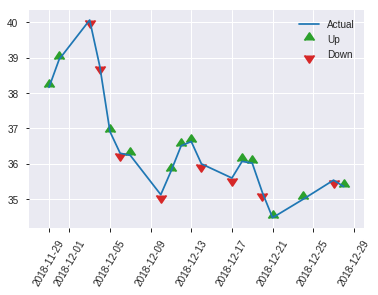


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21384577978818878
RMSE: 0.4624346221772206
LogLoss: 0.6134157822276399
Mean Per-Class Error: 0.30140961857379767
AUC: 0.7464600076540375
pr_auc: 0.6815391757273223
Gini: 0.49292001530807505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24681560695171356: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   74   0.5522   (74.0/134.0)
1      11   106  0.094    (11.0/117.0)
Total  71   180  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.246816     0.713805  179
max f2                       0.184899     0.83947   210
max f0point5                 0.395914     0.672566  111
max accuracy                 0.395914     0.693227  111
max precision                0.782603     1         0
max recall                   0.125807     1         245
max specificity              0.782603     1         0
max absolute_mcc             0.340507     0.399739  141
max min_per_class_accuracy   0.379129     0.686567  122
max mean_per_class_accuracy  0.340507     0.69859   141

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 37.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.736283           2.1453    2.1453             1                0.756914  1                           0.756914            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.719674           1.4302    1.78775            0.666667         0.72853   0.833333                    0.742722            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.683922           1.07265   1.60897            0.5              0.699402  0.75                        0.731892            0.00854701      0.0512821                  7.26496   60.8974
    4        0.0438247                   0.680205           2.1453    1.75524            1                0.681952  0.818182                    0.718272            0.025641        0.0769231                  114.53    75.5245
    5        0.0517928                   0.677605           1.07265   1.65023            0.5              0.67944   0.769231                    0.712298            0.00854701      0.0854701                  7.26496   65.023
    6        0.103586                    0.61366            1.81525   1.73274            0.846154         0.648302  0.807692                    0.6803              0.0940171       0.179487                   81.5253   73.2742
    7        0.151394                    0.566849           1.25142   1.58075            0.583333         0.58466   0.736842                    0.650098            0.0598291       0.239316                   25.1425   58.0747
    8        0.203187                    0.53999            1.32018   1.51433            0.615385         0.552042  0.705882                    0.625103            0.0683761       0.307692                   32.0184   51.4329
    9        0.302789                    0.4854             1.4588    1.49606            0.68             0.510011  0.697368                    0.587244            0.145299        0.452991                   45.8803   49.6064
    10       0.40239                     0.423217           1.20137   1.42312            0.56             0.450612  0.663366                    0.553424            0.119658        0.57265                    20.1368   42.3119
    11       0.501992                    0.375401           1.28718   1.39615            0.6              0.395432  0.650794                    0.522076            0.128205        0.700855                   28.7179   39.6147
    12       0.601594                    0.319998           0.943932  1.32128            0.44             0.34894   0.615894                    0.493411            0.0940171       0.794872                   -5.60684  32.1277
    13       0.701195                    0.26128            0.85812   1.25549            0.4              0.288363  0.585227                    0.464285            0.0854701       0.880342                   -14.188   25.5488
    14       0.800797                    0.209109           0.600684  1.17404            0.28             0.227806  0.547264                    0.434872            0.0598291       0.940171                   -39.9316  17.4044
    15       0.900398                    0.159921           0.42906   1.09163            0.2              0.181727  0.50885                     0.40687             0.042735        0.982906                   -57.094   9.16345
    16       1                           0.103043           0.171624  1                  0.08             0.135202  0.466135                    0.379811           

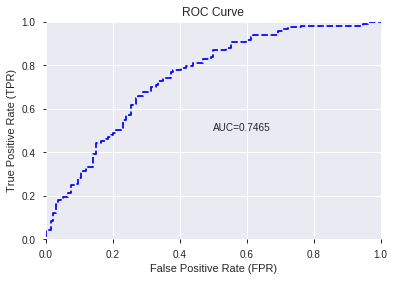

This function is available for GLM models only


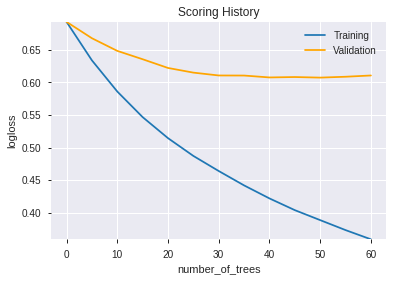

--2019-08-25 16:44:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190825_164325',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190825_164325',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b69b',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_164425_model_6  0.697984  0.706528              0.391855  0.497866  0.247870
1  DeepLearning_grid_1_AutoML_20190825_164425_model_9  0.692690  0.678450              0.371635  0.486978  0.237148
2  DeepLearning_grid_1_AutoML_20190825_164425_model_8  0.692435  0.767916              0.345038  0.491258  0.241335
3  DeepLearning_grid_1_AutoML_20190825_164425_model_5  0.685547  0.708185              0.366341  0.495695  0.245713
4  DeepLearning_grid_1_AutoML_20190825_164425_model_4  0.680253  1.448861              0.366278  0.609780  0.371832
5               DeepLearning_1_AutoML_20190825_164425  0.676872  0.711452              0.396670  0.495322  0.245344
6  DeepLearning_grid_1_AutoML_20190825_164425_model_7  0.650338  0.915011              0.372178  0.526854  0.277575
7  DeepLearning_grid_1_AutoML_20190825_164425_model_3  0.638347  2.004147              0.399381  0.628591  0.395126
8  DeepLearning_grid_1_AutoML_20190825_164425_model_2  0.636943  3.116943              0.404197  0.648768  0.420900
9  DeepLearning_grid_1_AutoML_20190825_164425_model_1  0.615129  3.979217              0.424895  0.661431  0.437491

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.034783
1     CDLCLOSINGMARUBOZU             0.871565           0.871565    0.030316
2            CDLLONGLINE             0.777688           0.777688    0.027050
3                    SUB             0.760441           0.760441    0.026450
4           CDLENGULFING             0.676813           0.676813    0.023542
5                    COS             0.624572           0.624572    0.021724
6           STOCHF_fastk             0.615507           0.615507    0.021409
7                    day             0.614500           0.614500    0.021374
8           CDLSHORTLINE             0.609484           0.609484    0.021200
9                 TRANGE             0.603656           0.603656    0.020997
10           CDLMARUBOZU             0.594041           0.594041    0.020662
11                MFI_24             0.586832           0.586832    0.020412
12              STDDEV_8             0.584530           0.584530    0.020332
13        STOCHRSI_fastk             0.584299           0.584299    0.020324
14                   OBV             0.582347           0.582347    0.020256
15            PLUS_DI_24             0.579966           0.579966    0.020173
16     CDLLONGLEGGEDDOJI             0.568078           0.568078    0.019759
17                   DIV             0.566047           0.566047    0.019689
18           STOCH_slowd             0.564700           0.564700    0.019642
19               BETA_30             0.561577           0.561577    0.019533
20                Volume             0.559585           0.559585    0.019464
21               CDLDOJI             0.557415           0.557415    0.019389
22        STOCHRSI_fastd             0.557282           0.557282    0.019384
23         days_in_month             0.554438           0.554438    0.019285
24                ULTOSC             0.550532           0.550532    0.019149
25     HT_PHASOR_inphase             0.548415           0.548415    0.019075
26           CDLBELTHOLD             0.548283           0.548283    0.019071
27               WILLR_8             0.543887           0.543887    0.018918
28            PLUS_DM_30             0.542835           0.542835    0.018881
29                 ADOSC             0.539376           0.539376    0.018761
30               BETA_20             0.533965           0.533965    0.018573
31                 CMO_8             0.533481           0.533481    0.018556
32        CDLRICKSHAWMAN             0.531023           0.531023    0.018471
33     MACDFIX_signal_12             0.530370           0.530370    0.018448
34             CDLHAMMER             0.529662           0.529662    0.018423
35          weekday_name             0.527054           0.527054    0.018333
36                 RSI_8             0.526659           0.526659    0.018319
37            PLUS_DM_14             0.525735           0.525735    0.018287
38  HT_PHASOR_quadrature             0.520283           0.520283    0.018097
39             dayofyear             0.519419           0.519419    0.018067
40           HT_DCPERIOD             0.517673           0.517673    0.018006
41                 DX_12             0.517482           0.517482    0.018000
42             STDDEV_30             0.515786           0.515786    0.017941
43             CORREL_14             0.510727           0.510727    0.017765
44                 month             0.506905           0.506905    0.017632
45             CORREL_30             0.505454           0.505454    0.017581
46              WILLR_14             0.502763           0.502763    0.017488
47                ADX_12             0.500263           0.500263    0.017401
48              WILLR_12             0.496817           0.496817    0.017281
49        is_month_start             0.469520           0.469520    0.016331

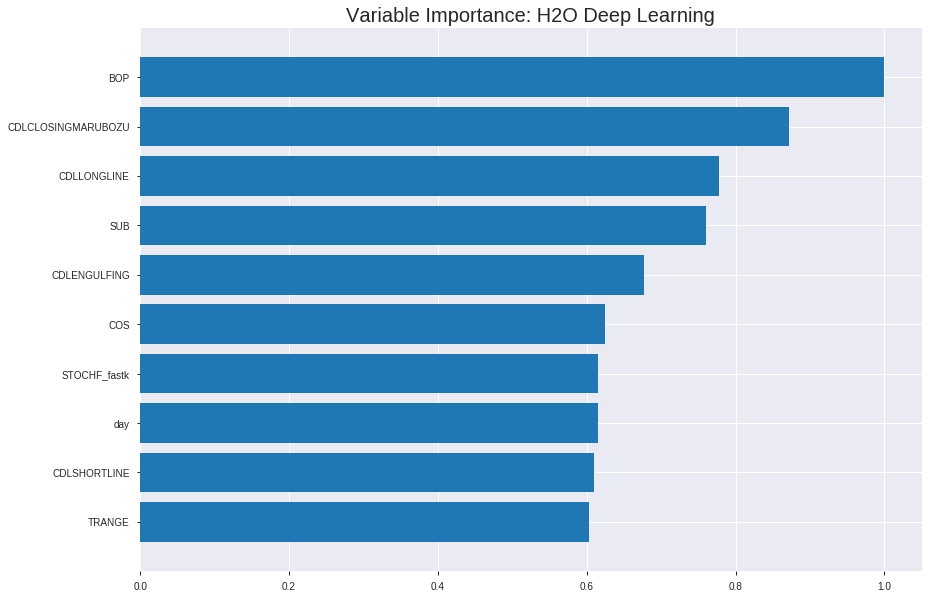

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_164425_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19039976365413475
RMSE: 0.4363482137629702
LogLoss: 0.5569917013433067
Mean Per-Class Error: 0.30215318920552536
AUC: 0.7804096126890832
pr_auc: 0.786332928557421
Gini: 0.5608192253781663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38836806631007875: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      405  447   0.5246   (447.0/852.0)
1      100  801   0.111    (100.0/901.0)
Total  505  1248  0.312    (547.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388368     0.745463  261
max f2                       0.220847     0.861062  330
max f0point5                 0.548876     0.721619  165
max accuracy                 0.490364     0.69652   197
max precision                0.995012     1         0
max recall                   0.0450729    1         386
max specificity              0.995012     1         0
max absolute_mcc             0.394805     0.405027  258
max min_per_class_accuracy   0.475725     0.693674  206
max mean_per_class_accuracy  0.490364     0.697847  197

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.977183           1.94562   1.94562            1                0.985443   1                           0.985443            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.964617           1.94562   1.94562            1                0.969085   1                           0.977264            0.0199778       0.0399556                  94.5616   94.5616
    3        0.0302339                   0.956199           1.48782   1.79878            0.764706         0.959487   0.924528                    0.971562            0.0144284       0.054384                   48.7824   79.8777
    4        0.040502                    0.935431           1.94562   1.836              1                0.945353   0.943662                    0.964917            0.0199778       0.0743618                  94.5616   83.6004
    5        0.0501997                   0.924649           1.83117   1.83507            0.941176         0.930314   0.943182                    0.958233            0.017758        0.0921199                  83.1168   83.507
    6        0.100399                    0.837691           1.72452   1.7798             0.886364         0.883284   0.914773                    0.920758            0.0865705       0.17869                    72.4523   77.9796
    7        0.150029                    0.762017           1.52071   1.69409            0.781609         0.803898   0.870722                    0.882101            0.0754717       0.254162                   52.0711   69.4091
    8        0.200228                    0.703805           1.63609   1.67955            0.840909         0.73141    0.863248                    0.844321            0.082131        0.336293                   63.6086   67.9549
    9        0.300057                    0.595743           1.40084   1.58682            0.72             0.641989   0.815589                    0.777005            0.139845        0.476138                   40.0844   58.6824
    10       0.399886                    0.517083           1.13402   1.47378            0.582857         0.55197    0.757489                    0.720827            0.113208        0.589345                   13.4016   47.3783
    11       0.500285                    0.476098           1.00597   1.3799             0.517045         0.49452    0.709236                    0.67541             0.100999        0.690344                   0.59719   37.9901
    12       0.600114                    0.43873            0.91166   1.30201            0.468571         0.45755    0.669202                    0.639169            0.09101         0.781354                   -8.83399  30.2009
    13       0.699943                    0.393084           0.978367  1.25585            0.502857         0.417655   0.645477                    0.607576            0.0976693       0.879023                   -2.16331  25.585
    14       0.799772                    0.319503           0.578126  1.17126            0.297143         0.360855   0.601997                    0.57678             0.0577137       0.936737                   -42.1874  17.1255
    15       0.899601                    0.175727           0.511419  1.09803            0.262857         0.25383    0.564363                    0.540942            0.0510544       0.987791                   -48.8581  9.80331
    16       1                           0.00437777         0.121601  1                  0.0625           0.0948512  0.513976                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21524275016919658
RMSE: 0.4639426151682949
LogLoss: 0.6167115790269164
Mean Per-Class Error: 0.32567528365136666
AUC: 0.7378400593089222
pr_auc: 0.7604760937811287
Gini: 0.4756801186178443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.283623180503478: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   135  0.6027   (135.0/224.0)
1      26   251  0.0939   (26.0/277.0)
Total  115  386  0.3214   (161.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283623     0.757164  304
max f2                       0.145176     0.871648  363
max f0point5                 0.509618     0.708775  160
max accuracy                 0.366777     0.686627  255
max precision                0.992078     1         0
max recall                   0.0765948    1         385
max specificity              0.992078     1         0
max absolute_mcc             0.353357     0.360114  264
max min_per_class_accuracy   0.433165     0.65704   210
max mean_per_class_accuracy  0.366777     0.674325  255

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 46.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.971182           1.80866   1.80866            1                0.97884    1                           0.97884             0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.960547           1.80866   1.80866            1                0.967566   1                           0.973715            0.0180505       0.0397112                  80.8664   80.8664
    3        0.0319361                   0.94021            1.44693   1.69562            0.8              0.947869   0.9375                      0.965638            0.0144404       0.0541516                  44.6931   69.5623
    4        0.0419162                   0.9216             1.44693   1.63641            0.8              0.928505   0.904762                    0.956797            0.0144404       0.0685921                  44.6931   63.6411
    5        0.0518962                   0.901634           1.0852    1.53041            0.6              0.912636   0.846154                    0.948304            0.0108303       0.0794224                  8.51986   53.0408
    6        0.101796                    0.794009           1.59162   1.56042            0.88             0.849004   0.862745                    0.899628            0.0794224       0.158845                   59.1625   56.0416
    7        0.151697                    0.734773           1.37458   1.49929            0.76             0.764137   0.828947                    0.855059            0.0685921       0.227437                   37.4585   49.9287
    8        0.201597                    0.65309            1.22989   1.43261            0.68             0.707058   0.792079                    0.818425            0.0613718       0.288809                   22.9892   43.2605
    9        0.301397                    0.563217           1.37458   1.41339            0.76             0.604415   0.781457                    0.747561            0.137184        0.425993                   37.4585   41.3393
    10       0.401198                    0.494483           1.19372   1.35875            0.66             0.532383   0.751244                    0.694034            0.119134        0.545126                   19.3718   35.8748
    11       0.500998                    0.439432           0.940505  1.27543            0.52             0.46648    0.705179                    0.648704            0.0938628       0.638989                   -5.94946  27.5433
    12       0.600798                    0.391669           1.12137   1.24984            0.62             0.41576    0.69103                     0.610009            0.111913        0.750903                   12.1372   24.9841
    13       0.700599                    0.323215           0.940505  1.20578            0.52             0.353861   0.666667                    0.573521            0.0938628       0.844765                   -5.94946  20.5776
    14       0.800399                    0.24426            0.759639  1.15015            0.42             0.290193   0.63591                     0.538193            0.0758123       0.920578                   -24.0361  15.0148
    15       0.9002                      0.155928           0.578773  1.0868             0.32             0.204121   0.600887                    0.501156            0.0577617       0.978339                   -42.1227  8.68027
    16       1                           0.00212897         0.21704   1                  0.12             0.0934413  0.552894                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:47:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:47:50  1 min 45.083 sec  902 obs/sec       1.4016    1             2457       0.530592         0.958037            -0.126993      0.682011        0.653634           1.94562          0.407872                         0.530422           0.917916              -0.138127        0.658063          0.680896             1.80866            0.38523
    2019-08-25 16:47:55  1 min 50.801 sec  1235 obs/sec      5.56475   4             9755       0.453009         0.59473             0.17849        0.744421        0.74347            1.83753          0.350827                         0.471623           0.63243               0.100219         0.69854           0.720345             1.80866            0.351297
    2019-08-25 16:48:01  1 min 56.622 sec  1835 obs/sec      13.8214   10            24229      0.436348         0.556992            0.237805       0.78041         0.786333           1.94562          0.312037                         0.463943           0.616712              0.129285         0.73784           0.760476             1.80866            0.321357
    2019-08-25 16:48:06  2 min  1.991 sec  2148 obs/sec      22.1495   16            38828      0.432503         0.548941            0.251181       0.799787        0.799602           1.94562          0.2915                           0.46246            0.623538              0.134841         0.728388          0.735028             1.20578            0.327345
    2019-08-25 16:48:12  2 min  7.159 sec  2352 obs/sec      30.4678   22            53410      0.4263           0.536428            0.272505       0.810814        0.812805           1.94562          0.289218                         0.464599           0.632527              0.126818         0.728049          0.732785             1.50722            0.339321
    2019-08-25 16:48:18  2 min 13.231 sec  2490 obs/sec      40.1198   29            70330      0.413677         0.509739            0.314948       0.824378        0.826543           1.94562          0.273816                         0.465882           0.646762              0.12199          0.734842          0.736582             1.50722            0.329341
    2019-08-25 16:48:24  2 min 19.164 sec  2599 obs/sec      49.9093   36            87491      0.401914         0.486061            0.353354       0.846915        0.854359           1.94562          0.256703                         0.466211           0.641026              0.120748         0.727493          0.73447              1.80866            0.323353
    2019-08-25 16:48:24  2 min 19.701 sec  2598 obs/sec      49.9093   36            87491      0.436348         0.556992            0.237805       0.78041         0.786333           1.94562          0.312037                         0.463943           0.616712              0.129285         0.73784           0.760476             1.80866            0.321357

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.034782935399778676
CDLCLOSINGMARUBOZU  0.8715649247169495     0.8715649247169495   0.030315586473142617
CDLLONGLINE         0.7776882648468018     0.7776882648468018   0.027050280677332273
SUB                 0.7604409456253052     0.7604409456253052   0.0264503682870316
CDLENGULFING        0.6768134832382202     0.6768134832382202   0.0235415596651742
---                 ---                    ---                  ---
CORREL_30           0.5054540634155273     0.5054540634155273   0.01758117603533792
WILLR_14            0.5027629733085632     0.5027629733085632   0.017487572021992404
ADX_12              0.5002628564834595     0.5002628564834595   0.01740061061997292
WILLR_12            0.4968172311782837     0.4968172311782837   0.01728076165757115
is_month_start      0.46951982378959656    0.46951982378959656  0.016331277699789003


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6613545816733067)

('F1', 0.6790123456790124)

('auc', 0.697984436790407)

('logloss', 0.7065278021724547)

('mean_per_class_error', 0.3403495343793852)

('rmse', 0.49786582318493977)

('mse', 0.24787037789561772)

deeplearning prediction progress: |███████████████████████████████████████| 100%


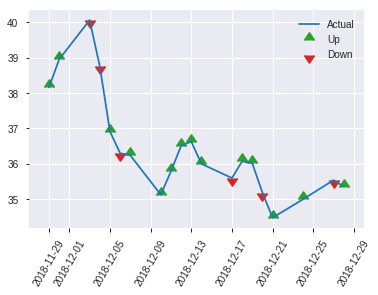


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24787037789561772
RMSE: 0.49786582318493977
LogLoss: 0.7065278021724547
Mean Per-Class Error: 0.3403495343793852
AUC: 0.697984436790407
pr_auc: 0.6351557156424747
Gini: 0.395968873580814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11530183511838414: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   97   0.7239   (97.0/134.0)
1      7    110  0.0598   (7.0/117.0)
Total  44   207  0.4143   (104.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.115302     0.679012  206
max f2                       0.0701958    0.827338  226
max f0point5                 0.313779     0.637343  109
max accuracy                 0.313779     0.661355  109
max precision                0.85943      1         0
max recall                   0.0229349    1         246
max specificity              0.85943      1         0
max absolute_mcc             0.241737     0.322905  145
max min_per_class_accuracy   0.301448     0.649573  121
max mean_per_class_accuracy  0.241737     0.65965   145

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 30.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.826887           1.4302    1.4302             0.666667         0.847551   0.666667                    0.847551            0.017094        0.017094                   43.0199   43.0199
    2        0.0239044                   0.7573             1.4302    1.4302             0.666667         0.783111   0.666667                    0.815331            0.017094        0.034188                   43.0199   43.0199
    3        0.0318725                   0.734687           2.1453    1.60897            1                0.74305    0.75                        0.797261            0.017094        0.0512821                  114.53    60.8974
    4        0.0438247                   0.708784           2.1453    1.75524            1                0.723729   0.818182                    0.777207            0.025641        0.0769231                  114.53    75.5245
    5        0.0517928                   0.695413           2.1453    1.81525            1                0.702932   0.846154                    0.76578             0.017094        0.0940171                  114.53    81.5253
    6        0.103586                    0.580188           1.48521   1.65023            0.692308         0.626558   0.769231                    0.696169            0.0769231       0.17094                    48.5207   65.023
    7        0.151394                    0.517002           0.893875  1.41138            0.416667         0.543075   0.657895                    0.647823            0.042735        0.213675                   -10.6125  41.1381
    8        0.203187                    0.465149           1.48521   1.4302             0.692308         0.489027   0.666667                    0.607346            0.0769231       0.290598                   48.5207   43.0199
    9        0.302789                    0.386941           1.37299   1.41138            0.64             0.418528   0.657895                    0.545235            0.136752        0.42735                    37.2991   41.1381
    10       0.40239                     0.330004           1.11556   1.33816            0.52             0.35706    0.623762                    0.498657            0.111111        0.538462                   11.5556   33.8157
    11       0.501992                    0.292366           1.20137   1.31102            0.56             0.311292   0.611111                    0.461481            0.119658        0.65812                    20.1368   31.1016
    12       0.601594                    0.229464           1.02974   1.26445            0.48             0.261399   0.589404                    0.428355            0.102564        0.760684                   2.97436   26.4448
    13       0.701195                    0.168635           0.772308  1.19454            0.36             0.201482   0.556818                    0.396129            0.0769231       0.837607                   -22.7692  19.4542
    14       0.800797                    0.122977           0.686496  1.13135            0.32             0.138108   0.527363                    0.364037            0.0683761       0.905983                   -31.3504  13.1352
    15       0.900398                    0.0723279          0.686496  1.08214            0.32             0.0999775  0.504425                    0.334827            0.0683761       0.974359                   -31.3504  8.2142
    16       1                           0.0101514          0.257436  1                  0.12             0.0420847  0.466135                    0

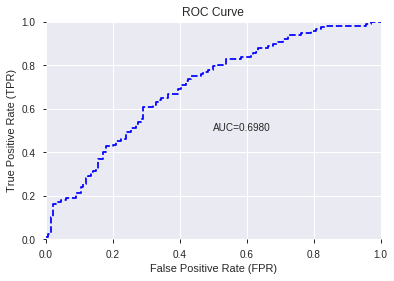

This function is available for GLM models only


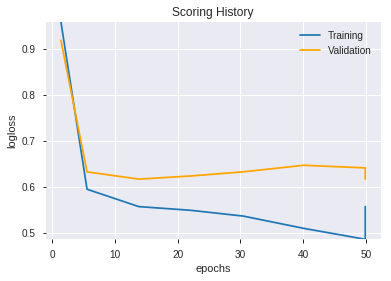

--2019-08-25 16:51:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_164425_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_164425_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'SUB',
 'CDLENGULFING',
 'COS',
 'STOCHF_fastk',
 'day',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLMARUBOZU',
 'MFI_24',
 'STDDEV_8',
 'STOCHRSI_fastk',
 'OBV',
 'PLUS_DI_24',
 'CDLLONGLEGGEDDOJI',
 'DIV',
 'STOCH_slowd',
 'BETA_30',
 'Volume',
 'CDLDOJI',
 'STOCHRSI_fastd',
 'days_in_month',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'CDLBELTHOLD',
 'WILLR_8',
 'PLUS_DM_30',
 'ADOSC',
 'BETA_20',
 'CMO_8',
 'CDLRICKSHAWMAN',
 'MACDFIX_signal_12',
 'CDLHAMMER',
 'weekday_name',
 'RSI_8',
 'PLUS_DM_14',
 'HT_PHASOR_quadrature',
 'dayofyear',
 'HT_DCPERIOD',
 'DX_12',
 'STDDEV_30',
 'CORREL_14',
 'month',
 'CORREL_30',
 'WILLR_14',
 'ADX_12',
 'WILLR_12',
 'is_month_start']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_165148_model_1  0.709019  0.678117              0.359963  0.479138  0.229573

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.466383           1.000000    0.119900
1                    SUB             0.251152           0.538510    0.064567
2     CDLCLOSINGMARUBOZU             0.195580           0.419356    0.050281
3           STOCHF_fastk             0.192593           0.412950    0.049513
4         STOCHRSI_fastd             0.175943           0.377251    0.045232
5               STDDEV_8             0.174976           0.375176    0.044984
6              CDLHAMMER             0.150740           0.323210    0.038753
7                 ULTOSC             0.150476           0.322645    0.038685
8            STOCH_slowd             0.132308           0.283690    0.034015
9             PLUS_DI_24             0.131659           0.282298    0.033848
10          CDLENGULFING             0.123603           0.265024    0.031776
11           CDLLONGLINE             0.110591           0.237125    0.028431
12            PLUS_DM_14             0.105224           0.225618    0.027052
13                TRANGE             0.104959           0.225050    0.026984
14                 DX_12             0.100241           0.214933    0.025770
15               WILLR_8             0.099392           0.213112    0.025552
16             STDDEV_30             0.084441           0.181055    0.021709
17        STOCHRSI_fastk             0.083995           0.180098    0.021594
18           CDLMARUBOZU             0.067368           0.144449    0.017319
19  HT_PHASOR_quadrature             0.065845           0.141183    0.016928
20                MFI_24             0.063751           0.136693    0.016390
21                   DIV             0.062604           0.134232    0.016094
22             CORREL_30             0.061314           0.131468    0.015763
23               BETA_20             0.056648           0.121462    0.014563
24                   COS             0.054561           0.116988    0.014027
25                 CMO_8             0.042336           0.090775    0.010884
26         days_in_month             0.041832           0.089694    0.010754
27                 RSI_8             0.041710           0.089433    0.010723
28     HT_PHASOR_inphase             0.039161           0.083968    0.010068
29                 ADOSC             0.038499           0.082548    0.009898
30               BETA_30             0.035112           0.075287    0.009027
31        CDLRICKSHAWMAN             0.034724           0.074454    0.008927
32          weekday_name             0.034639           0.074272    0.008905
33              WILLR_14             0.032665           0.070038    0.008398
34               CDLDOJI             0.027758           0.059517    0.007136
35     CDLLONGLEGGEDDOJI             0.027757           0.059515    0.007136
36     MACDFIX_signal_12             0.027095           0.058097    0.006966
37          CDLSHORTLINE             0.026023           0.055797    0.006690
38           CDLBELTHOLD             0.023311           0.049982    0.005993
39                Volume             0.023231           0.049810    0.005972
40           HT_DCPERIOD             0.022945           0.049197    0.005899
41                   OBV             0.020740           0.044470    0.005332
42              WILLR_12             0.019751           0.042350    0.005078
43                   day             0.016468           0.035310    0.004234
44             CORREL_14             0.011198           0.024010    0.002879
45                ADX_12             0.010500           0.022514    0.002699
46            PLUS_DM_30             0.010136           0.021734    0.002606
47        is_month_start             0.007894           0.016926    0.002029
48             dayofyear             0.004767           0.010221    0.001226
49                 month             0.003160           0.006775    0.000812

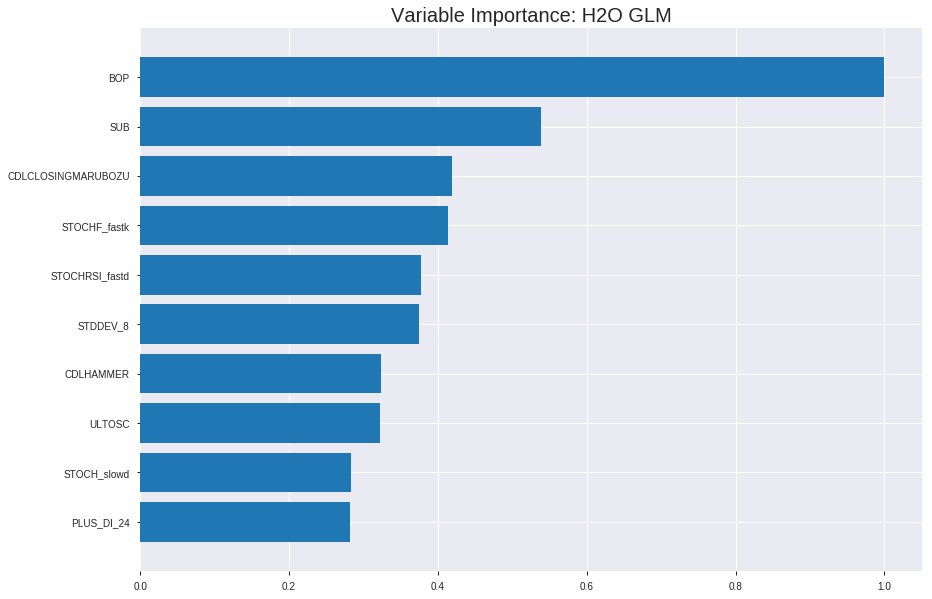

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_165148_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19562645247831853
RMSE: 0.44229679229937735
LogLoss: 0.5747395335031517
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.80418460647
Residual deviance: 2015.0368044620498
AIC: 2117.03680446205
AUC: 0.7713280236357098
pr_auc: 0.7630666383382573
Gini: 0.5426560472714197
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3542036911235481: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      351  501   0.588    (501.0/852.0)
1      77   824   0.0855   (77.0/901.0)
Total  428  1325  0.3297   (578.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354204     0.740341  282
max f2                       0.220036     0.852901  337
max f0point5                 0.555537     0.714786  178
max accuracy                 0.530023     0.702795  193
max precision                0.933198     1         0
max recall                   0.0883804    1         386
max specificity              0.933198     1         0
max absolute_mcc             0.555537     0.405875  178
max min_per_class_accuracy   0.542922     0.699223  185
max mean_per_class_accuracy  0.555537     0.702886  178

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.881003           1.62135   1.62135            0.833333         0.900066  0.833333                    0.900066            0.0166482       0.0166482                  62.1347   62.1347
    2        0.0205362                   0.861302           1.62135   1.62135            0.833333         0.86717   0.833333                    0.883618            0.0166482       0.0332963                  62.1347   62.1347
    3        0.0302339                   0.846146           1.83117   1.68865            0.941176         0.853445  0.867925                    0.87394             0.017758        0.0510544                  83.1168   68.8648
    4        0.040502                    0.832976           1.72944   1.69899            0.888889         0.837662  0.873239                    0.864743            0.017758        0.0688124                  72.9436   69.8989
    5        0.0501997                   0.820804           1.60227   1.6803             0.823529         0.826168  0.863636                    0.857291            0.0155383       0.0843507                  60.2272   68.0305
    6        0.100399                    0.769889           1.76874   1.72452            0.909091         0.794378  0.886364                    0.825834            0.0887902       0.173141                   76.8742   72.4523
    7        0.150029                    0.73557            1.65489   1.70149            0.850575         0.750947  0.874525                    0.801062            0.082131        0.255272                   65.4892   70.1489
    8        0.200228                    0.701059           1.34867   1.61303            0.693182         0.718916  0.82906                     0.780467            0.0677026       0.322974                   34.8666   61.3032
    9        0.300057                    0.648766           1.42308   1.54983            0.731429         0.673287  0.796578                    0.744808            0.142064        0.465039                   42.3079   54.9835
    10       0.399886                    0.599678           1.13402   1.44603            0.582857         0.626317  0.743224                    0.715227            0.113208        0.578246                   13.4016   44.6028
    11       0.500285                    0.544788           1.16074   1.38877            0.596591         0.572077  0.713797                    0.6865              0.116537        0.694784                   16.0737   38.8775
    12       0.600114                    0.478173           0.933896  1.31311            0.48             0.511438  0.674905                    0.657378            0.0932297       0.788013                   -6.61043  31.3106
    13       0.699943                    0.39794            0.756011  1.23365            0.388571         0.439838  0.634067                    0.626351            0.0754717       0.863485                   -24.3989  23.3651
    14       0.799772                    0.313374           0.744893  1.17264            0.382857         0.358291  0.60271                     0.592892            0.0743618       0.937847                   -25.5107  17.2643
    15       0.899601                    0.203867           0.389123  1.0857             0.2              0.257729  0.558022                    0.555699            0.0388457       0.976693                   -61.0877  8.56957
    16       1                           0.0443081          0.232147  1                  0.119318         0.140133  0.513976                    0.513976         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1998079331565867
RMSE: 0.44699880666125574
LogLoss: 0.5827291664013277
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.9613759565244
Residual deviance: 583.8946247341303
AIC: 685.8946247341303
AUC: 0.7576956549767921
pr_auc: 0.7798243756206806
Gini: 0.5153913099535843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33469493066216943: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  121  0.5402   (121.0/224.0)
1      30   247  0.1083   (30.0/277.0)
Total  133  368  0.3014   (151.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334695     0.765891  284
max f2                       0.148074     0.873016  367
max f0point5                 0.450825     0.728088  227
max accuracy                 0.371057     0.706587  267
max precision                0.896718     1         0
max recall                   0.074656     1         390
max specificity              0.896718     1         0
max absolute_mcc             0.371057     0.405071  267
max min_per_class_accuracy   0.528255     0.68231   198
max mean_per_class_accuracy  0.450825     0.697831  227

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.879317           1.80866   1.80866            1                0.888085  1                           0.888085            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.856899           1.44693   1.64424            0.8              0.863338  0.909091                    0.876837            0.0144404       0.0361011                  44.6931   64.424
    3        0.0319361                   0.850004           1.80866   1.69562            1                0.852539  0.9375                      0.869243            0.0180505       0.0541516                  80.8664   69.5623
    4        0.0419162                   0.831687           1.80866   1.72254            1                0.837978  0.952381                    0.861799            0.0180505       0.0722022                  80.8664   72.2537
    5        0.0518962                   0.824109           1.80866   1.7391             1                0.827351  0.961538                    0.855175            0.0180505       0.0902527                  80.8664   73.91
    6        0.101796                    0.786581           1.59162   1.66681            0.88             0.806832  0.921569                    0.831477            0.0794224       0.169675                   59.1625   66.6808
    7        0.151697                    0.749784           1.37458   1.57068            0.76             0.766814  0.868421                    0.810207            0.0685921       0.238267                   37.4585   57.0682
    8        0.201597                    0.716305           1.30224   1.50424            0.72             0.730229  0.831683                    0.79041             0.0649819       0.303249                   30.2238   50.4236
    9        0.301397                    0.648032           1.26606   1.42537            0.7              0.68355   0.788079                    0.755026            0.126354        0.429603                   26.6065   42.5371
    10       0.401198                    0.596823           1.22989   1.37674            0.68             0.620582  0.761194                    0.721582            0.122744        0.552347                   22.9892   37.6744
    11       0.500998                    0.536445           1.12137   1.32587            0.62             0.566128  0.733068                    0.690615            0.111913        0.66426                    12.1372   32.5873
    12       0.600798                    0.443857           1.04903   1.27989            0.58             0.487352  0.707641                    0.656851            0.104693        0.768953                   4.90253   27.9885
    13       0.700599                    0.362345           0.868159  1.22123            0.48             0.399578  0.675214                    0.620202            0.0866426       0.855596                   -13.1841  22.1235
    14       0.800399                    0.289277           0.723466  1.15917            0.4              0.323025  0.640898                    0.583148            0.0722022       0.927798                   -27.6534  15.9169
    15       0.9002                      0.176295           0.506426  1.0868             0.28             0.231319  0.600887                    0.544142            0.0505415       0.978339                   -49.3574  8.68027
    16       1                           0.0187674          0.21704   1                  0.12             0.112653  0.552894                    0.501079            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:51:48  0.000 sec   2            20        49            1.36816           1.36113
    2019-08-25 16:51:48  0.015 sec   4            12        50            1.35919           1.35086
    2019-08-25 16:51:48  0.030 sec   6            7.6       50            1.34667           1.33664
    2019-08-25 16:51:48  0.049 sec   8            4.7       50            1.33019           1.31819
    2019-08-25 16:51:48  0.064 sec   10           2.9       50            1.30993           1.29603
    2019-08-25 16:51:48  0.083 sec   12           1.8       51            1.28679           1.2716
    2019-08-25 16:51:48  0.104 sec   14           1.1       51            1.26239           1.2471
    2019-08-25 16:51:48  0.116 sec   16           0.7       51            1.23847           1.22445
    2019-08-25 16:51:48  0.127 sec   18           0.43      51            1.21656           1.20508
    2019-08-25 16:51:48  0.138 sec   20           0.27      51            1.19749           1.18952
    2019-08-25 16:51:48  0.159 sec   22           0.17      51            1.18147           1.17788
    2019-08-25 16:51:48  0.174 sec   24           0.1       51            1.16831           1.1701
    2019-08-25 16:51:48  0.193 sec   26           0.065     51            1.15774           1.16607
    2019-08-25 16:51:48  0.212 sec   28           0.04      51            1.14948           1.16546
    2019-08-25 16:51:48  0.231 sec   30           0.025     51            1.14325           1.16743
    2019-08-25 16:51:48  0.244 sec   32           0.015     51            1.13868           1.17096
    2019-08-25 16:51:48  0.255 sec   34           0.0096    51            1.13539           1.17509
    2019-08-25 16:51:48  0.269 sec   36           0.006     51            1.1331            1.17917
    2019-08-25 16:51:48  0.282 sec   38           0.0037    51            1.13161           1.18283

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6653386454183267)

('F1', 0.6802721088435374)

('auc', 0.7090190075264703)

('logloss', 0.6781172171683314)

('mean_per_class_error', 0.33872305140961856)

('rmse', 0.4791375701663168)

('mse', 0.22957281114488215)

glm prediction progress: |████████████████████████████████████████████████| 100%


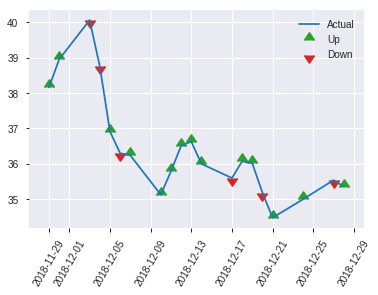


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22957281114488215
RMSE: 0.4791375701663168
LogLoss: 0.6781172171683314
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.1066907598522
Residual deviance: 340.4148430185024
AIC: 442.4148430185024
AUC: 0.7090190075264703
pr_auc: 0.6687944101355574
Gini: 0.4180380150529406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17338337238961793: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   77   0.5746   (77.0/134.0)
1      17   100  0.1453   (17.0/117.0)
Total  74   177  0.3745   (94.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.173383     0.680272  176
max f2                       0.0384265    0.820368  238
max f0point5                 0.455333     0.642994  100
max accuracy                 0.455333     0.665339  100
max precision                0.788956     0.916667  11
max recall                   0.0168053    1         247
max specificity              0.906744     0.992537  0
max absolute_mcc             0.246547     0.329237  151
max min_per_class_accuracy   0.401655     0.656716  122
max mean_per_class_accuracy  0.246547     0.661277  151

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 36.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862308           1.4302    1.4302             0.666667         0.880552   0.666667                    0.880552            0.017094        0.017094                   43.0199   43.0199
    2        0.0239044                   0.819848           2.1453    1.78775            1                0.838756   0.833333                    0.859654            0.025641        0.042735                   114.53    78.7749
    3        0.0318725                   0.812973           2.1453    1.87714            1                0.814582   0.875                       0.848386            0.017094        0.0598291                  114.53    87.7137
    4        0.0438247                   0.794145           2.1453    1.95027            1                0.80048    0.909091                    0.835321            0.025641        0.0854701                  114.53    95.0272
    5        0.0517928                   0.776198           1.07265   1.81525            0.5              0.782957   0.846154                    0.827265            0.00854701      0.0940171                  7.26496   81.5253
    6        0.103586                    0.694523           1.65023   1.73274            0.769231         0.737723   0.807692                    0.782494            0.0854701       0.179487                   65.023    73.2742
    7        0.151394                    0.638636           1.4302    1.6372             0.666667         0.665176   0.763158                    0.745446            0.0683761       0.247863                   43.0199   63.7202
    8        0.203187                    0.586557           1.32018   1.55639            0.615385         0.611614   0.72549                     0.711332            0.0683761       0.316239                   32.0184   55.6393
    9        0.302789                    0.529847           1.28718   1.46784            0.6              0.559518   0.684211                    0.661393            0.128205        0.444444                   28.7179   46.7836
    10       0.40239                     0.455333           1.28718   1.42312            0.6              0.491257   0.663366                    0.61928             0.128205        0.57265                    28.7179   42.3119
    11       0.501992                    0.394222           0.85812   1.31102            0.4              0.428569   0.611111                    0.581441            0.0854701       0.65812                    -14.188   31.1016
    12       0.601594                    0.249721           1.11556   1.27866            0.52             0.316815   0.596026                    0.537629            0.111111        0.769231                   11.5556   27.8655
    13       0.701195                    0.173516           0.772308  1.20673            0.36             0.204681   0.5625                      0.490335            0.0769231       0.846154                   -22.7692  20.6731
    14       0.800797                    0.111185           0.600684  1.13135            0.28             0.142589   0.527363                    0.447083            0.0598291       0.905983                   -39.9316  13.1352
    15       0.900398                    0.0576139          0.42906   1.05366            0.2              0.0819799  0.49115                     0.406695            0.042735        0.948718                   -57.094   5.36646
    16       1                           0.000130157        0.514872  1                  0.24             0.0339651  0.466135                   

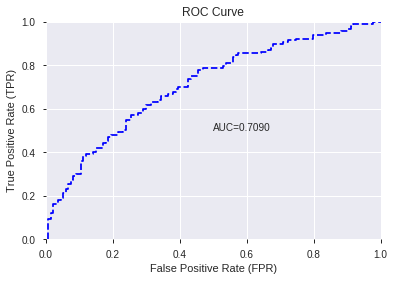

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


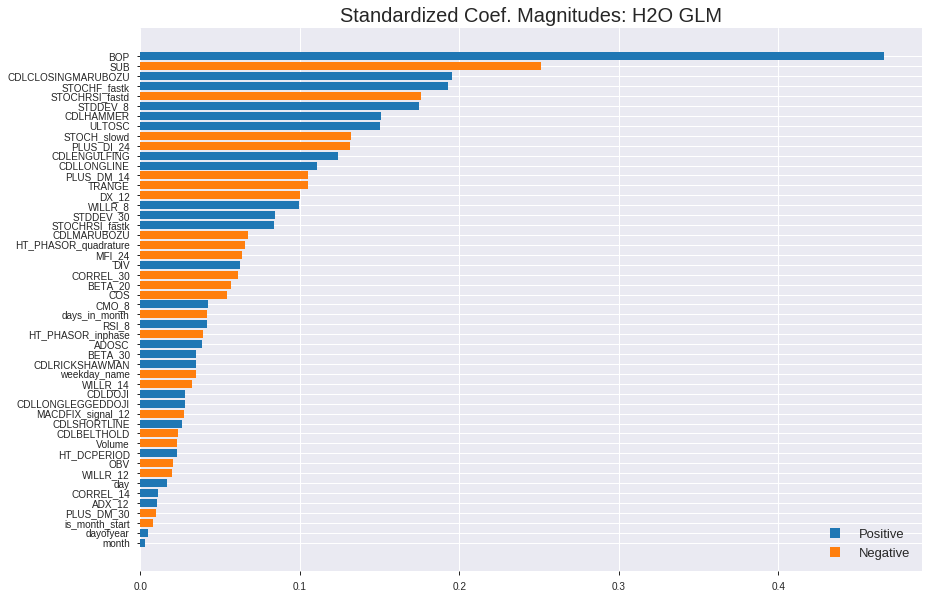

'log_likelihood'
--2019-08-25 16:51:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.89.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.89.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_165148_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_165148_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'STDDEV_8',
 'CDLHAMMER',
 'ULTOSC',
 'STOCH_slowd',
 'PLUS_DI_24',
 'CDLENGULFING',
 'CDLLONGLINE',
 'PLUS_DM_14',
 'TRANGE',
 'DX_12',
 'WILLR_8',
 'STDDEV_30',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'HT_PHASOR_quadrature',
 'MFI_24',
 'DIV',
 'CORREL_30',
 'BETA_20',
 'COS',
 'CMO_8',
 'days_in_month',
 'RSI_8',
 'HT_PHASOR_inphase',
 'ADOSC',
 'BETA_30',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'WILLR_14',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MACDFIX_signal_12',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'Volume',
 'HT_DCPERIOD',
 'OBV',
 'WILLR_12',
 'day',
 'CORREL_14',
 'ADX_12',
 'PLUS_DM_30',
 'is_month_start',
 'dayofyear',
 'month']

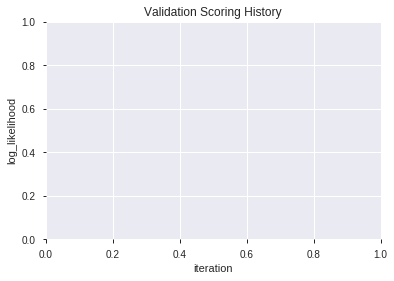

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_165201_model_6  0.742633  0.607564              0.318854  0.459592  0.211225
1  XGBoost_grid_1_AutoML_20190825_165201_model_4  0.736829  0.605552              0.333238  0.458127  0.209880
2               XGBoost_2_AutoML_20190825_165201  0.735744  0.601604              0.310913  0.456396  0.208297
3  XGBoost_grid_1_AutoML_20190825_165201_model_2  0.727708  0.611410              0.293883  0.460640  0.212189
4  XGBoost_grid_1_AutoML_20190825_165201_model_7  0.722988  0.610801              0.316686  0.462162  0.213594
5               XGBoost_1_AutoML_20190825_165201  0.721776  0.613260              0.302909  0.463074  0.214438
6  XGBoost_grid_1_AutoML_20190825_165201_model_1  0.720819  0.610838              0.287441  0.461498  0.212980
7               XGBoost_3_AutoML_20190825_165201  0.719480  0.613887              0.276247  0.463592  0.214917
8  XGBoost_grid_1_AutoML_20190825_165201_model_3  0.719224  0.609708              0.310850  0.460990  0.212512
9  XGBoost_grid_1_AutoML_20190825_165201_model_5  0.715844  0.610974              0.323128  0.461163  0.212671

variable  relative_importance  scaled_importance  percentage
0                    BOP          2065.654541           1.000000    0.207259
1                    SUB           461.812225           0.223567    0.046336
2           STOCHF_fastk           412.753540           0.199817    0.041414
3                 Volume           409.262512           0.198127    0.041064
4         STOCHRSI_fastd           371.524567           0.179858    0.037277
5             PLUS_DI_24           339.377960           0.164296    0.034052
6               STDDEV_8           319.019135           0.154440    0.032009
7                 TRANGE           306.041992           0.148157    0.030707
8                    COS           269.494080           0.130464    0.027040
9      HT_PHASOR_inphase           255.835480           0.123852    0.025669
10                MFI_24           234.330521           0.113441    0.023512
11                 CMO_8           220.585068           0.106787    0.022133
12               BETA_20           212.600082           0.102921    0.021331
13             CORREL_30           207.394547           0.100401    0.020809
14                ULTOSC           206.621552           0.100027    0.020732
15                 ADOSC           203.624023           0.098576    0.020431
16     MACDFIX_signal_12           202.193634           0.097884    0.020287
17            PLUS_DM_14           199.231583           0.096450    0.019990
18              WILLR_14           179.668777           0.086979    0.018027
19               BETA_30           179.451050           0.086874    0.018005
20           STOCH_slowd           179.092484           0.086700    0.017969
21             dayofyear           176.476044           0.085433    0.017707
22                   OBV           176.185608           0.085293    0.017678
23           HT_DCPERIOD           172.642075           0.083577    0.017322
24                ADX_12           171.763657           0.083152    0.017234
25               WILLR_8           171.049255           0.082806    0.017162
26                   day           170.984833           0.082775    0.017156
27            PLUS_DM_30           168.168961           0.081412    0.016873
28             CORREL_14           167.980667           0.081321    0.016854
29  HT_PHASOR_quadrature           162.129410           0.078488    0.016267
30                 DX_12           152.252106           0.073706    0.015276
31              WILLR_12           150.125900           0.072677    0.015063
32                   DIV           144.325256           0.069869    0.014481
33             STDDEV_30           139.319794           0.067446    0.013979
34    CDLCLOSINGMARUBOZU           105.912354           0.051273    0.010627
35        STOCHRSI_fastk           100.219109           0.048517    0.010056
36             CDLHAMMER            63.228027           0.030609    0.006344
37          weekday_name            59.120453           0.028621    0.005932
38           CDLLONGLINE            31.454754           0.015227    0.003156
39                 month            12.891476           0.006241    0.001293
40           CDLBELTHOLD             9.678763           0.004686    0.000971
41          CDLSHORTLINE             8.072783           0.003908    0.000810
42                 RSI_8             6.788175           0.003286    0.000681
43         days_in_month             5.922711           0.002867    0.000594
44          CDLENGULFING             4.285488           0.002075    0.000430

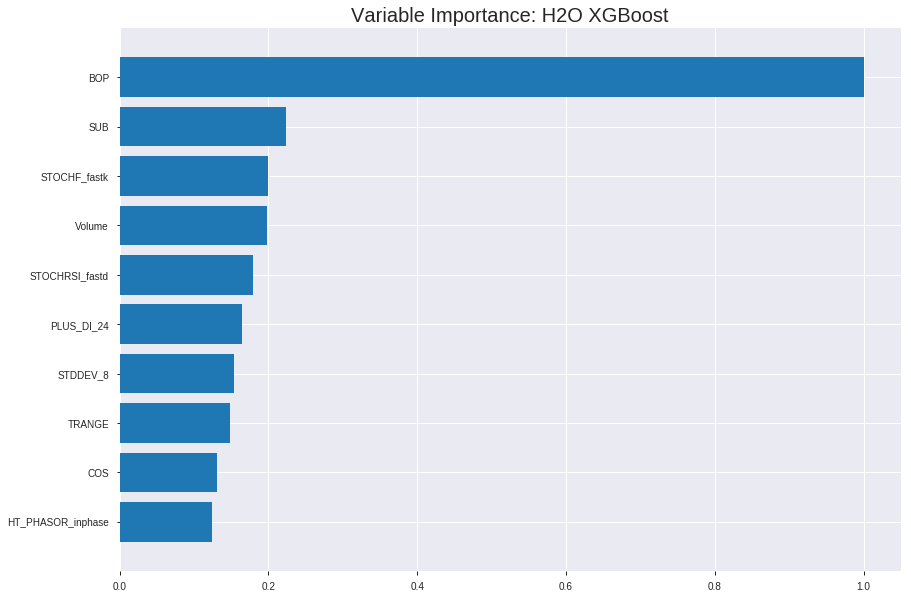

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_165201_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1366183915356283
RMSE: 0.3696192521171324
LogLoss: 0.4401128597922029
Mean Per-Class Error: 0.14346344437323166
AUC: 0.9290915675332051
pr_auc: 0.9371323270891418
Gini: 0.8581831350664102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5191391905148824: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  152  0.1784   (152.0/852.0)
1      105  796  0.1165   (105.0/901.0)
Total  805  948  0.1466   (257.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519139     0.861006  203
max f2                       0.462282     0.892972  230
max f0point5                 0.597542     0.886534  162
max accuracy                 0.555749     0.855676  182
max precision                0.930038     1         0
max recall                   0.193275     1         342
max specificity              0.930038     1         0
max absolute_mcc             0.57707      0.715375  172
max min_per_class_accuracy   0.537651     0.850166  192
max mean_per_class_accuracy  0.555749     0.856537  182

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.896856           1.94562   1.94562            1                0.909787  1                           0.909787            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.883133           1.94562   1.94562            1                0.891079  1                           0.900433            0.0199778       0.0399556                  94.5616   94.5616
    3        0.0302339                   0.872676           1.94562   1.94562            1                0.877831  1                           0.893183            0.0188679       0.0588235                  94.5616   94.5616
    4        0.040502                    0.862081           1.94562   1.94562            1                0.866417  1                           0.886397            0.0199778       0.0788013                  94.5616   94.5616
    5        0.0501997                   0.846828           1.94562   1.94562            1                0.853527  1                           0.880047            0.0188679       0.0976693                  94.5616   94.5616
    6        0.100399                    0.803393           1.94562   1.94562            1                0.823726  1                           0.851886            0.0976693       0.195339                   94.5616   94.5616
    7        0.150029                    0.758179           1.92325   1.93822            0.988506         0.781102  0.996198                    0.828471            0.0954495       0.290788                   92.3253   93.8218
    8        0.200228                    0.720036           1.87929   1.92344            0.965909         0.737742  0.988604                    0.805724            0.0943396       0.385128                   87.9288   92.3444
    9        0.300057                    0.66137            1.77885   1.87534            0.914286         0.688527  0.963878                    0.766733            0.17758         0.562708                   77.8849   87.5337
    10       0.399886                    0.608323           1.60096   1.80684            0.822857         0.634601  0.928673                    0.733747            0.159822        0.722531                   60.0964   80.6842
    11       0.500285                    0.541072           1.21601   1.68827            0.625            0.576739  0.867731                    0.702238            0.122087        0.844617                   21.601    68.8271
    12       0.600114                    0.471205           0.744893  1.53134            0.382857         0.509385  0.787072                    0.670157            0.0743618       0.918979                   -25.5107  53.134
    13       0.699943                    0.395062           0.300181  1.35575            0.154286         0.433366  0.696822                    0.636385            0.0299667       0.948946                   -69.9819  35.5747
    14       0.799772                    0.283376           0.366888  1.23232            0.188571         0.340348  0.633381                    0.599433            0.036626        0.985572                   -63.3112  23.2316
    15       0.899601                    0.156984           0.144531  1.1116             0.0742857        0.216164  0.571338                    0.556902            0.0144284       1                          -85.5469  11.1604
    16       1                           0.0602378          0         1                  0                0.118756  0.513976                    0.512912          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20374276234614086
RMSE: 0.45137873492904035
LogLoss: 0.5932762097466365
Mean Per-Class Error: 0.30216928829293455
AUC: 0.7478162068076327
pr_auc: 0.7605913152364331
Gini: 0.49563241361526544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34898513555526733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   129  0.5759   (129.0/224.0)
1      28   249  0.1011   (28.0/277.0)
Total  123  378  0.3134   (157.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348985     0.760305  290
max f2                       0.162369     0.870804  372
max f0point5                 0.451161     0.728088  221
max accuracy                 0.451161     0.704591  221
max precision                0.916651     1         0
max recall                   0.0988362    1         394
max specificity              0.916651     1         0
max absolute_mcc             0.451161     0.399229  221
max min_per_class_accuracy   0.504623     0.67509   195
max mean_per_class_accuracy  0.451161     0.697831  221

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 50.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.888818           1.80866   1.80866            1                0.904383  1                           0.904383            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.867489           1.80866   1.80866            1                0.874933  1                           0.890997            0.0180505       0.0397112                  80.8664   80.8664
    3        0.0319361                   0.849446           1.80866   1.80866            1                0.857775  1                           0.880615            0.0180505       0.0577617                  80.8664   80.8664
    4        0.0419162                   0.835223           1.0852    1.63641            0.6              0.839084  0.904762                    0.870727            0.0108303       0.0685921                  8.51986   63.6411
    5        0.0518962                   0.82879            1.44693   1.59997            0.8              0.832445  0.884615                    0.863365            0.0144404       0.0830325                  44.6931   59.9972
    6        0.101796                    0.788106           1.44693   1.52495            0.8              0.808306  0.843137                    0.836375            0.0722022       0.155235                   44.6931   52.4952
    7        0.151697                    0.73632            1.37458   1.47549            0.76             0.757376  0.815789                    0.810389            0.0685921       0.223827                   37.4585   47.5489
    8        0.201597                    0.711311           1.44693   1.46842            0.8              0.724749  0.811881                    0.789191            0.0722022       0.296029                   44.6931   46.842
    9        0.301397                    0.639587           1.41076   1.44933            0.78             0.675149  0.801325                    0.751429            0.140794        0.436823                   41.0758   44.9327
    10       0.401198                    0.590604           1.0852    1.35875            0.6              0.610448  0.751244                    0.716359            0.108303        0.545126                   8.51986   35.8748
    11       0.500998                    0.514009           1.04903   1.29705            0.58             0.549833  0.717131                    0.683186            0.104693        0.649819                   4.90253   29.705
    12       0.600798                    0.44504            1.22989   1.28589            0.68             0.476816  0.710963                    0.648906            0.122744        0.772563                   22.9892   28.5894
    13       0.700599                    0.384765           0.795812  1.21608            0.44             0.419895  0.672365                    0.616283            0.0794224       0.851986                   -20.4188  21.6082
    14       0.800399                    0.293313           0.759639  1.15917            0.42             0.346472  0.640898                    0.582641            0.0758123       0.927798                   -24.0361  15.9169
    15       0.9002                      0.199746           0.434079  1.07878            0.24             0.252576  0.596452                    0.546048            0.0433213       0.971119                   -56.5921  7.8782
    16       1                           0.0825403          0.289386  1                  0.16             0.148085  0.552894                    0.506331            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:52:11  5.949 sec   0                  0.5              0.693147            0.5             0                  1                0.486024                         0.5                0.693147              0.5               0                    1                  0.447106
    2019-08-25 16:52:11  6.002 sec   5                  0.472904         0.640078            0.837091        0.845354           1.94562          0.247576                         0.482703           0.658939              0.731498          0.73851              1.50722            0.303393
    2019-08-25 16:52:11  6.046 sec   10                 0.452113         0.600121            0.85253         0.856054           1.94562          0.229892                         0.472894           0.639594              0.73622           0.736314             1.50722            0.317365
    2019-08-25 16:52:11  6.087 sec   15                 0.436213         0.569351            0.866001        0.871208           1.94562          0.225898                         0.463516           0.620805              0.74224           0.749828             1.80866            0.329341
    2019-08-25 16:52:11  6.127 sec   20                 0.423582         0.544949            0.878875        0.883976           1.94562          0.207644                         0.459118           0.611557              0.743489          0.755981             1.50722            0.327345
    2019-08-25 16:52:11  6.167 sec   25                 0.412681         0.523464            0.88803         0.894353           1.94562          0.201369                         0.456281           0.605258              0.743441          0.757839             1.80866            0.327345
    2019-08-25 16:52:11  6.240 sec   30                 0.404777         0.507936            0.895685        0.904042           1.94562          0.186537                         0.454828           0.602064              0.743134          0.754735             1.80866            0.321357
    2019-08-25 16:52:11  6.297 sec   35                 0.398367         0.494975            0.901557        0.910244           1.94562          0.174558                         0.453498           0.599071              0.744988          0.754591             1.80866            0.305389
    2019-08-25 16:52:11  6.364 sec   40                 0.392459         0.48297             0.905615        0.913037           1.94562          0.175699                         0.45202            0.595788              0.747067          0.759114             1.80866            0.295409
    2019-08-25 16:52:11  6.433 sec   45                 0.385925         0.470539            0.911436        0.920066           1.94562          0.175699                         0.451586           0.594493              0.747131          0.758822             1.80866            0.303393
    2019-08-25 16:52:11  6.495 sec   50                 0.379583         0.458893            0.919157        0.927656           1.94562          0.156874                         0.452614           0.596289              0.745141          0.759186             1.80866            0.307385
    2019-08-25 16:52:11  6.538 sec   55                 0.375929         0.451487            0.922353        0.930479           1.94562          0.153451                         0.45174            0.594253              0.745673          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2065.654541015625      1.0                    0.20725879679778736
SUB             461.8122253417969      0.223567017704101      0.0463362310930216
STOCHF_fastk    412.7535400390625      0.1998173130324701     0.04141389587847659
Volume          409.26251220703125     0.19812727834239321    0.04106362132206473
STOCHRSI_fastd  371.5245666503906      0.17985803495860558    0.037277159919934966
---             ---                    ---                    ---
CDLBELTHOLD     9.678763389587402      0.004685567309250376   0.0009711250428302789
CDLSHORTLINE    8.072782516479492      0.0039080990340767865  0.0008099879035693497
RSI_8           6.788174629211426      0.0032862100096727057  0.0006810959326296102
days_in_month   5.922711372375488      0.0028672322766339505  0.0005942591117949331
CDLENGULFING    4.285488128662109      0.002074639318225522   0.0004299872488848035


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7181208053691276)

('auc', 0.7426329889016456)

('logloss', 0.6075641081362004)

('mean_per_class_error', 0.2955096313305269)

('rmse', 0.4595917872100297)

('mse', 0.2112246108709092)

xgboost prediction progress: |████████████████████████████████████████████| 100%


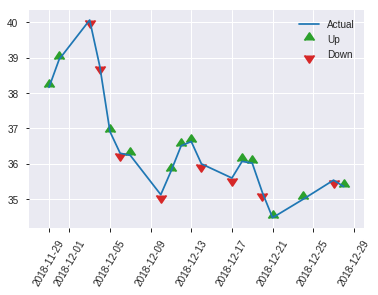


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2112246108709092
RMSE: 0.4595917872100297
LogLoss: 0.6075641081362004
Mean Per-Class Error: 0.2955096313305269
AUC: 0.7426329889016456
pr_auc: 0.6762976008837202
Gini: 0.4852659778032913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26777589321136475: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   74   0.5522   (74.0/134.0)
1      10   107  0.0855   (10.0/117.0)
Total  70   181  0.3347   (84.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267776     0.718121  180
max f2                       0.168242     0.845376  223
max f0point5                 0.358173     0.667145  144
max accuracy                 0.358173     0.697211  144
max precision                0.81055      1         0
max recall                   0.168242     1         223
max specificity              0.81055      1         0
max absolute_mcc             0.35108      0.415389  148
max min_per_class_accuracy   0.394684     0.671642  122
max mean_per_class_accuracy  0.35108      0.70449   148

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 39.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.77712            2.1453    2.1453             1                0.792751  1                           0.792751            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.754649           1.4302    1.78775            0.666667         0.764262  0.833333                    0.778506            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.742813           1.07265   1.60897            0.5              0.747657  0.75                        0.770794            0.00854701      0.0512821                  7.26496   60.8974
    4        0.0438247                   0.731625           1.4302    1.56022            0.666667         0.734357  0.727273                    0.760857            0.017094        0.0683761                  43.0199   56.0218
    5        0.0517928                   0.700058           2.1453    1.65023            1                0.709925  0.769231                    0.753021            0.017094        0.0854701                  114.53    65.023
    6        0.103586                    0.635451           1.65023   1.65023            0.769231         0.672798  0.769231                    0.71291             0.0854701       0.17094                    65.023    65.023
    7        0.151394                    0.57727            1.60897   1.6372             0.75             0.610382  0.763158                    0.680532            0.0769231       0.247863                   60.8974   63.7202
    8        0.203187                    0.548674           1.48521   1.59846            0.692308         0.563324  0.745098                    0.650656            0.0769231       0.324786                   48.5207   59.8458
    9        0.302789                    0.497864           1.20137   1.46784            0.56             0.521687  0.684211                    0.608232            0.119658        0.444444                   20.1368   46.7836
    10       0.40239                     0.443401           1.20137   1.40188            0.56             0.468174  0.653465                    0.573564            0.119658        0.564103                   20.1368   40.1879
    11       0.501992                    0.389201           1.28718   1.37912            0.6              0.417116  0.642857                    0.542523            0.128205        0.692308                   28.7179   37.9121
    12       0.601594                    0.345564           1.20137   1.34969            0.56             0.368749  0.629139                    0.513752            0.119658        0.811966                   20.1368   34.9692
    13       0.701195                    0.287218           0.686496  1.25549            0.32             0.313472  0.585227                    0.485303            0.0683761       0.880342                   -31.3504  25.5488
    14       0.800797                    0.215649           0.42906   1.1527             0.2              0.243415  0.537313                    0.455218            0.042735        0.923077                   -57.094   15.2698
    15       0.900398                    0.16271            0.772308  1.11062            0.36             0.187994  0.517699                    0.425657            0.0769231       1                          -22.7692  11.0619
    16       1                           0.0964378          0         1                  0                0.13491   0.466135                    0.396699            

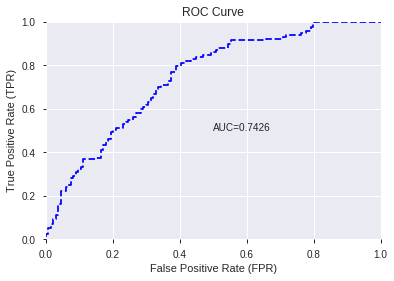

This function is available for GLM models only


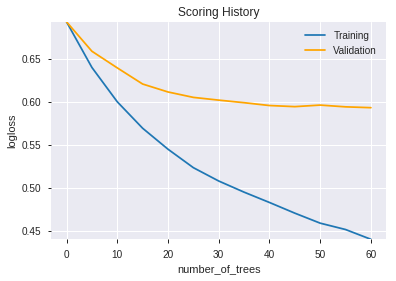

--2019-08-25 16:52:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_165201_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_165201_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'STOCHF_fastk',
 'Volume',
 'STOCHRSI_fastd',
 'PLUS_DI_24',
 'STDDEV_8',
 'TRANGE',
 'COS',
 'HT_PHASOR_inphase',
 'MFI_24',
 'CMO_8',
 'BETA_20',
 'CORREL_30',
 'ULTOSC',
 'ADOSC',
 'MACDFIX_signal_12',
 'PLUS_DM_14',
 'WILLR_14',
 'BETA_30',
 'STOCH_slowd',
 'dayofyear',
 'OBV',
 'HT_DCPERIOD',
 'ADX_12',
 'WILLR_8',
 'day',
 'PLUS_DM_30',
 'CORREL_14',
 'HT_PHASOR_quadrature',
 'DX_12',
 'WILLR_12',
 'DIV',
 'STDDEV_30',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'CDLHAMMER',
 'weekday_name',
 'CDLLONGLINE',
 'month',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'RSI_8',
 'days_in_month',
 'CDLENGULFING']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

25

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_165226_model_8  0.719671  0.705388              0.324212  0.493687  0.243727
1  DeepLearning_grid_1_AutoML_20190825_165226_model_1  0.715525  1.633672              0.346058  0.581056  0.337626
2  DeepLearning_grid_1_AutoML_20190825_165226_model_5  0.709210  0.693970              0.327465  0.487448  0.237606
3  DeepLearning_grid_1_AutoML_20190825_165226_model_4  0.706276  0.798311              0.352437  0.520777  0.271209
4  DeepLearning_grid_1_AutoML_20190825_165226_model_9  0.705320  0.733409              0.329028  0.506186  0.256224
5  DeepLearning_grid_1_AutoML_20190825_165226_model_7  0.702768  1.107135              0.338595  0.549585  0.302044
6               DeepLearning_1_AutoML_20190825_165226  0.699388  1.155569              0.369467  0.578968  0.335204
7  DeepLearning_grid_1_AutoML_20190825_165226_model_3  0.694731  1.607394              0.345038  0.598841  0.358611
8  DeepLearning_grid_1_AutoML_20190825_165226_model_6  0.690330  0.730275              0.334450  0.502094  0.252098
9  DeepLearning_grid_1_AutoML_20190825_165226_model_2  0.689501  1.885828              0.336012  0.601620  0.361947

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.074872
1   CDLCLOSINGMARUBOZU             0.790299           0.790299    0.059172
2                  SUB             0.708948           0.708948    0.053081
3                CCI_8             0.640534           0.640534    0.047958
4         CDLSHORTLINE             0.585011           0.585011    0.043801
5               TRANGE             0.584294           0.584294    0.043748
6          CDLLONGLINE             0.580863           0.580863    0.043491
7          CDLBELTHOLD             0.555882           0.555882    0.041620
8         STOCHF_fastk             0.552377           0.552377    0.041358
9         CDLENGULFING             0.548921           0.548921    0.041099
10                 DIV             0.543169           0.543169    0.040668
11              ULTOSC             0.542849           0.542849    0.040644
12      STOCHRSI_fastk             0.521008           0.521008    0.039009
13         CDLMARUBOZU             0.489146           0.489146    0.036624
14               ADOSC             0.477074           0.477074    0.035720
15              RSI_12             0.453400           0.453400    0.033947
16            WILLR_30             0.438755           0.438755    0.032851
17            WILLR_24             0.436368           0.436368    0.032672
18             WILLR_8             0.435540           0.435540    0.032610
19               CMO_8             0.421749           0.421749    0.031577
20               RSI_8             0.418045           0.418045    0.031300
21              CMO_12             0.416317           0.416317    0.031171
22            WILLR_20             0.414587           0.414587    0.031041
23            WILLR_12             0.413706           0.413706    0.030975
24            WILLR_14             0.387198           0.387198    0.028991

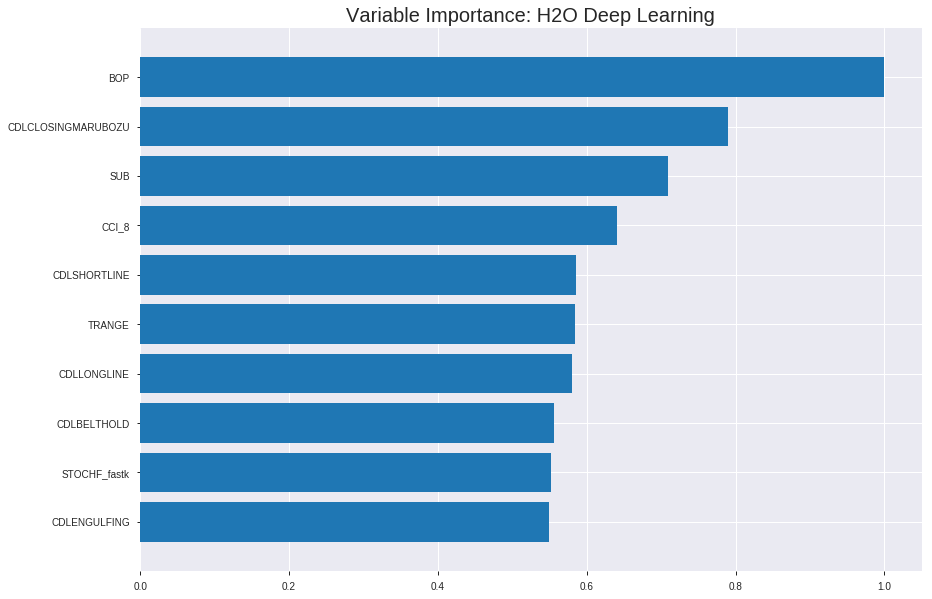

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_165226_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1977979228908776
RMSE: 0.4447447839951331
LogLoss: 0.5770687183934885
Mean Per-Class Error: 0.3103639409524107
AUC: 0.7620282367531122
pr_auc: 0.7489554255930289
Gini: 0.5240564735062243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.389830301706934: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      346  506   0.5939   (506.0/852.0)
1      78   823   0.0866   (78.0/901.0)
Total  424  1329  0.3331   (584.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38983      0.738117  270
max f2                       0.239237     0.8613    330
max f0point5                 0.555919     0.699236  169
max accuracy                 0.51891      0.690245  195
max precision                0.928513     1         0
max recall                   0.079766     1         382
max specificity              0.928513     1         0
max absolute_mcc             0.51891      0.379682  195
max min_per_class_accuracy   0.52591      0.687014  190
max mean_per_class_accuracy  0.51891      0.689636  195

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.911759           1.72944   1.72944            0.888889         0.919933  0.888889                    0.919933            0.017758        0.017758                   72.9436   72.9436
    2        0.0205362                   0.898668           1.72944   1.72944            0.888889         0.903476  0.888889                    0.911704            0.017758        0.0355161                  72.9436   72.9436
    3        0.0302339                   0.883303           1.60227   1.68865            0.823529         0.891937  0.867925                    0.905364            0.0155383       0.0510544                  60.2272   68.8648
    4        0.040502                    0.869076           1.62135   1.67159            0.833333         0.875595  0.859155                    0.897817            0.0166482       0.0677026                  62.1347   67.1586
    5        0.0501997                   0.843226           1.71672   1.6803             0.882353         0.856494  0.863636                    0.889834            0.0166482       0.0843507                  71.672    68.0305
    6        0.100399                    0.76889            1.63609   1.6582             0.840909         0.798101  0.852273                    0.843968            0.082131        0.166482                   63.6086   65.8195
    7        0.150029                    0.724885           1.54307   1.62011            0.793103         0.746345  0.8327                      0.811674            0.0765816       0.243063                   54.3075   62.0114
    8        0.200228                    0.682177           1.54765   1.60195            0.795455         0.703415  0.823362                    0.784532            0.0776915       0.320755                   54.7649   60.1946
    9        0.300057                    0.607877           1.36749   1.52394            0.702857         0.643117  0.78327                     0.737483            0.136515        0.45727                    36.749    52.3943
    10       0.399886                    0.558037           1.15625   1.43215            0.594286         0.579924  0.736091                    0.69815             0.115427        0.572697                   15.6252   43.2151
    11       0.500285                    0.52586            1.09441   1.36437            0.5625           0.541584  0.701254                    0.66673             0.109878        0.682575                   9.4409    36.4372
    12       0.600114                    0.488003           0.922778  1.29091            0.474286         0.509757  0.663498                    0.640617            0.0921199       0.774695                   -7.72221  29.0913
    13       0.699943                    0.426162           0.933896  1.23999            0.48             0.458397  0.637327                    0.614628            0.0932297       0.867925                   -6.61043  23.9993
    14       0.799772                    0.355322           0.733775  1.17681            0.377143         0.393069  0.60485                     0.586973            0.0732519       0.941176                   -26.6225  17.6806
    15       0.899601                    0.219873           0.466948  1.09803            0.24             0.288802  0.564363                    0.553885            0.0466149       0.987791                   -53.3052  9.80331
    16       1                           0.0184286          0.121601  1                  0.0625           0.130144  0.513976                    0.511341         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1986415230625415
RMSE: 0.44569218420625406
LogLoss: 0.5794625937101672
Mean Per-Class Error: 0.2915726534296028
AUC: 0.7633606240330068
pr_auc: 0.7789015010873814
Gini: 0.5267212480660135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3868273949704319: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  106  0.4732   (106.0/224.0)
1      38   239  0.1372   (38.0/277.0)
Total  156  345  0.2874   (144.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386827     0.768489  264
max f2                       0.208864     0.874036  350
max f0point5                 0.497459     0.734725  198
max accuracy                 0.41085      0.720559  247
max precision                0.934388     1         0
max recall                   0.0922214    1         385
max specificity              0.934388     1         0
max absolute_mcc             0.405895     0.431743  251
max min_per_class_accuracy   0.488858     0.696429  203
max mean_per_class_accuracy  0.41085      0.708427  247

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 49.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.912883           1.80866   1.80866            1                0.921344  1                           0.921344            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.891791           1.44693   1.64424            0.8              0.897287  0.909091                    0.910409            0.0144404       0.0361011                  44.6931   64.424
    3        0.0319361                   0.876022           1.80866   1.69562            1                0.883916  0.9375                      0.90213             0.0180505       0.0541516                  80.8664   69.5623
    4        0.0419162                   0.86546            1.44693   1.63641            0.8              0.87109   0.904762                    0.89474             0.0144404       0.0685921                  44.6931   63.6411
    5        0.0518962                   0.858213           1.44693   1.59997            0.8              0.859093  0.884615                    0.887884            0.0144404       0.0830325                  44.6931   59.9972
    6        0.101796                    0.809475           1.59162   1.59588            0.88             0.827901  0.882353                    0.858481            0.0794224       0.162455                   59.1625   59.588
    7        0.151697                    0.752497           1.44693   1.54688            0.8              0.782799  0.855263                    0.833585            0.0722022       0.234657                   44.6931   54.6884
    8        0.201597                    0.708932           1.59162   1.55796            0.88             0.732595  0.861386                    0.808588            0.0794224       0.314079                   59.1625   55.7958
    9        0.301397                    0.610104           1.30224   1.47328            0.72             0.65745   0.81457                     0.758542            0.129964        0.444043                   30.2238   47.3283
    10       0.401198                    0.550646           1.01285   1.35875            0.56             0.575456  0.751244                    0.712998            0.101083        0.545126                   1.2852    35.8748
    11       0.500998                    0.501075           1.30224   1.34749            0.72             0.526541  0.74502                     0.675855            0.129964        0.67509                    30.2238   34.7491
    12       0.600798                    0.432798           0.940505  1.27989            0.52             0.466787  0.707641                    0.641126            0.0938628       0.768953                   -5.94946  27.9885
    13       0.700599                    0.380924           0.976679  1.23669            0.54             0.405078  0.683761                    0.607501            0.0974729       0.866426                   -2.33213  23.6694
    14       0.800399                    0.290528           0.651119  1.16368            0.36             0.34184   0.643392                    0.574376            0.0649819       0.931408                   -34.8881  16.3679
    15       0.9002                      0.205866           0.506426  1.09081            0.28             0.249886  0.603104                    0.538402            0.0505415       0.981949                   -49.3574  9.0813
    16       1                           0.0248925          0.180866  1                  0.1              0.120451  0.552894                    0.49669             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:58:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:58:16  1 min  4.846 sec  749 obs/sec       0.855676  1             1500       0.504111         0.71518             -0.0173084     0.719679        0.708645           1.94562          0.358243                         0.482541           0.666738              0.0580767        0.714439          0.714321             1.20578            0.343313
    2019-08-25 16:58:27  1 min 15.375 sec  1146 obs/sec      7.60297   9             13328      0.473496         0.639799            0.102505       0.753119        0.743808           1.83753          0.346264                         0.469833           0.63265               0.107033         0.748703          0.774305             1.80866            0.299401
    2019-08-25 16:58:36  1 min 25.160 sec  1301 obs/sec      15.2173   18            26676      0.444745         0.577069            0.20819        0.762028        0.748955           1.72944          0.333143                         0.445692           0.579463              0.196441         0.763361          0.778902             1.80866            0.287425
    2019-08-25 16:58:46  1 min 35.029 sec  1408 obs/sec      23.6629   28            41481      0.45434          0.595563            0.173656       0.744852        0.741415           1.72944          0.344552                         0.466105           0.625974              0.121147         0.727364          0.756266             1.80866            0.309381
    2019-08-25 16:58:56  1 min 44.590 sec  1476 obs/sec      32.1027   38            56276      0.455568         0.596201            0.169181       0.768428        0.757973           1.62135          0.334284                         0.467277           0.630062              0.116723         0.760871          0.778215             1.80866            0.291417
    2019-08-25 16:59:05  1 min 54.264 sec  1516 obs/sec      40.5282   48            71046      0.445893         0.576383            0.204094       0.771043        0.765726           1.83753          0.325157                         0.459124           0.620071              0.147278         0.752554          0.7744               1.80866            0.295409
    2019-08-25 16:59:06  1 min 55.205 sec  1515 obs/sec      40.5282   48            71046      0.444745         0.577069            0.20819        0.762028        0.748955           1.72944          0.333143                         0.445692           0.579463              0.196441         0.763361          0.778902             1.80866            0.287425

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.07487249447970291
CDLCLOSINGMARUBOZU  0.7902986407279968     0.7902986407279968   0.05917163061522365
SUB                 0.7089475393295288     0.7089475393295288   0.05308067072484911
CCI_8               0.6405338644981384     0.6405338644981384   0.04795836823369964
CDLSHORTLINE        0.5850110054016113     0.5850110054016113   0.043801233272497596
---                 ---                    ---                  ---
RSI_8               0.4180447459220886     0.4180447459220886   0.031300052931320384
CMO_12              0.4163167178630829     0.4163167178630829   0.031170671160011706
WILLR_20            0.41458696126937866    0.41458696126937866  0.031041159968998356
WILLR_12            0.4137056767940521     0.4137056767940521   0.030975176001984423
WILLR_14            0.38719844818115234    0.38719844818115234  0.02899051367399286


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6733067729083665)

('F1', 0.7098976109215018)

('auc', 0.7196708763872942)

('logloss', 0.7053879448017403)

('mean_per_class_error', 0.324212271973466)

('rmse', 0.4936872917384785)

('mse', 0.24372714202407353)

deeplearning prediction progress: |███████████████████████████████████████| 100%


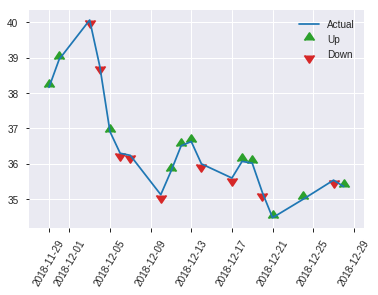


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24372714202407353
RMSE: 0.4936872917384785
LogLoss: 0.7053879448017403
Mean Per-Class Error: 0.324212271973466
AUC: 0.7196708763872942
pr_auc: 0.6607552107139265
Gini: 0.4393417527745884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12618554076599556: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   72   0.5373   (72.0/134.0)
1      13   104  0.1111   (13.0/117.0)
Total  75   176  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.126186     0.709898  175
max f2                       0.0288124    0.82153   237
max f0point5                 0.332442     0.653021  98
max accuracy                 0.332442     0.673307  98
max precision                0.867076     1         0
max recall                   0.0128507    1         249
max specificity              0.867076     1         0
max absolute_mcc             0.126186     0.383157  175
max min_per_class_accuracy   0.278045     0.649573  121
max mean_per_class_accuracy  0.126186     0.675788  175

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 30.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.836411           2.1453    2.1453             1                0.852301   1                           0.852301            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.815806           1.4302    1.78775            0.666667         0.826197   0.833333                    0.839249            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.784877           1.07265   1.60897            0.5              0.808114   0.75                        0.831465            0.00854701      0.0512821                  7.26496   60.8974
    4        0.0438247                   0.761014           2.1453    1.75524            1                0.763446   0.818182                    0.812915            0.025641        0.0769231                  114.53    75.5245
    5        0.0517928                   0.723159           1.07265   1.65023            0.5              0.730068   0.769231                    0.800169            0.00854701      0.0854701                  7.26496   65.023
    6        0.103586                    0.672915           1.65023   1.65023            0.769231         0.698608   0.769231                    0.749389            0.0854701       0.17094                    65.023    65.023
    7        0.151394                    0.549419           1.25142   1.52429            0.583333         0.604859   0.710526                    0.703748            0.0598291       0.230769                   25.1425   52.4291
    8        0.203187                    0.486688           1.32018   1.47226            0.615385         0.507751   0.686275                    0.653788            0.0683761       0.299145                   32.0184   47.2264
    9        0.302789                    0.418789           1.28718   1.41138            0.6              0.447789   0.657895                    0.586025            0.128205        0.42735                    28.7179   41.1381
    10       0.40239                     0.312569           1.4588    1.42312            0.68             0.36585    0.663366                    0.531526            0.145299        0.57265                    45.8803   42.3119
    11       0.501992                    0.267047           0.943932  1.32804            0.44             0.287633   0.619048                    0.483135            0.0940171       0.666667                   -5.60684  32.8042
    12       0.601594                    0.207992           1.11556   1.29286            0.52             0.241274   0.602649                    0.443092            0.111111        0.777778                   11.5556   29.2862
    13       0.701195                    0.126186           1.11556   1.26768            0.52             0.163673   0.590909                    0.403402            0.111111        0.888889                   11.5556   26.7677
    14       0.800797                    0.0792873          0.42906   1.16337            0.2              0.102376   0.542289                    0.365961            0.042735        0.931624                   -57.094   16.3371
    15       0.900398                    0.0485635          0.343248  1.07265            0.16             0.0640183  0.5                         0.33256             0.034188        0.965812                   -65.6752  7.26496
    16       1                           0.00186933         0.343248  1                  0.16             0.0292191  0.466135                    0.

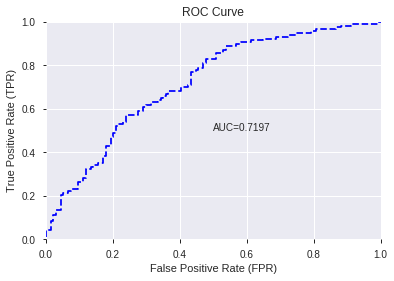

This function is available for GLM models only


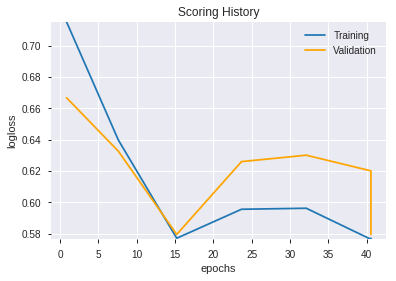

--2019-08-25 17:00:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_165226_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_165226_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CCI_8',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CDLENGULFING',
 'DIV',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'ADOSC',
 'RSI_12',
 'WILLR_30',
 'WILLR_24',
 'WILLR_8',
 'CMO_8',
 'RSI_8',
 'CMO_12',
 'WILLR_20',
 'WILLR_12',
 'WILLR_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id     auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_170014_model_1  0.7124  0.702215               0.33378  0.492847  0.242898

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.439201           1.000000    0.203738
1                  SUB             0.194023           0.441765    0.090004
2         STOCHF_fastk             0.190814           0.434457    0.088516
3   CDLCLOSINGMARUBOZU             0.187493           0.426896    0.086975
4                CCI_8             0.168042           0.382609    0.077952
5          CDLLONGLINE             0.133249           0.303389    0.061812
6         CDLENGULFING             0.121247           0.276064    0.056245
7       STOCHRSI_fastk             0.108075           0.246073    0.050134
8               TRANGE             0.103794           0.236325    0.048148
9              WILLR_8             0.072067           0.164087    0.033431
10              ULTOSC             0.067864           0.154516    0.031481
11         CDLMARUBOZU             0.047752           0.108725    0.022151
12              RSI_12             0.038357           0.087333    0.017793
13              CMO_12             0.038265           0.087125    0.017751
14        CDLSHORTLINE             0.035494           0.080814    0.016465
15               ADOSC             0.031946           0.072736    0.014819
16            WILLR_30             0.028631           0.065190    0.013282
17                 DIV             0.025324           0.057659    0.011747
18            WILLR_20             0.024721           0.056287    0.011468
19               CMO_8             0.024515           0.055817    0.011372
20               RSI_8             0.023948           0.054527    0.011109
21            WILLR_24             0.014959           0.034061    0.006939
22         CDLBELTHOLD             0.014660           0.033378    0.006800
23            WILLR_12             0.011006           0.025059    0.005105
24            WILLR_14             0.010263           0.023368    0.004761

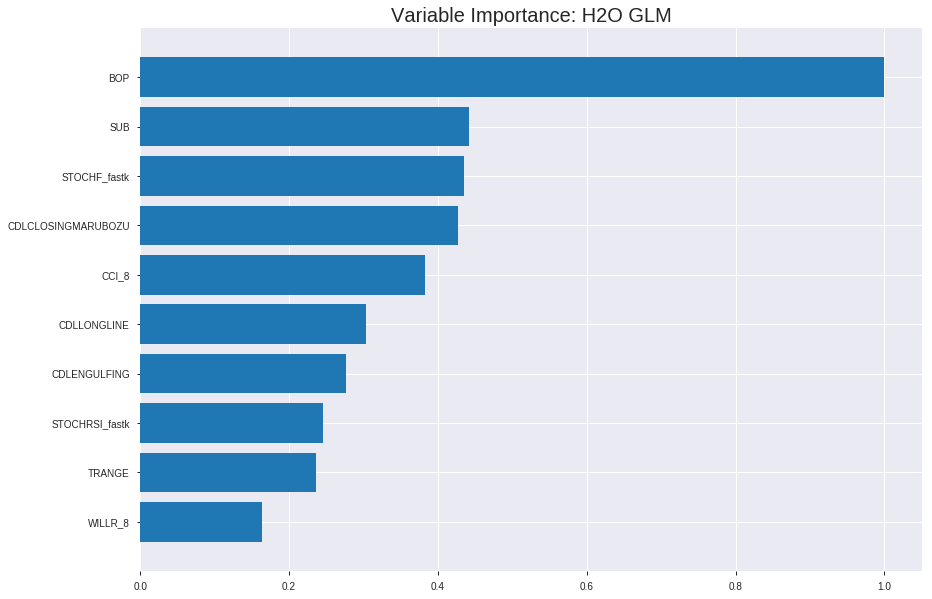

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_170014_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20315540744384664
RMSE: 0.45072764220074923
LogLoss: 0.592006606663553
Null degrees of freedom: 1752
Residual degrees of freedom: 1727
Null deviance: 2428.80418460647
Residual deviance: 2075.575162962417
AIC: 2127.575162962417
AUC: 0.7502260138708686
pr_auc: 0.7372477097755106
Gini: 0.5004520277417372
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3391444237919123: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      276  576   0.6761   (576.0/852.0)
1      50   851   0.0555   (50.0/901.0)
Total  326  1427  0.3571   (626.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339144     0.7311    292
max f2                       0.243992     0.853776  335
max f0point5                 0.533914     0.692989  181
max accuracy                 0.491062     0.68397   208
max precision                0.820898     0.873418  29
max recall                   0.118491     1         387
max specificity              0.921908     0.998826  0
max absolute_mcc             0.491062     0.368293  208
max min_per_class_accuracy   0.524835     0.680355  187
max mean_per_class_accuracy  0.491062     0.681904  208

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.875761           1.62135   1.62135            0.833333         0.898468  0.833333                    0.898468            0.0166482       0.0166482                  62.1347   62.1347
    2        0.0205362                   0.853121           1.62135   1.62135            0.833333         0.863896  0.833333                    0.881182            0.0166482       0.0332963                  62.1347   62.1347
    3        0.0302339                   0.83826            1.83117   1.68865            0.941176         0.845451  0.867925                    0.869721            0.017758        0.0510544                  83.1168   68.8648
    4        0.040502                    0.824411           1.72944   1.69899            0.888889         0.831523  0.873239                    0.860037            0.017758        0.0688124                  72.9436   69.8989
    5        0.0501997                   0.80984            1.60227   1.6803             0.823529         0.818146  0.863636                    0.851945            0.0155383       0.0843507                  60.2272   68.0305
    6        0.100399                    0.757225           1.6803    1.6803             0.863636         0.78095   0.863636                    0.816447            0.0843507       0.168701                   68.0305   68.0305
    7        0.150029                    0.707947           1.45362   1.60532            0.747126         0.729328  0.825095                    0.787628            0.0721421       0.240844                   45.3621   60.5318
    8        0.200228                    0.675915           1.48132   1.57423            0.761364         0.691719  0.809117                    0.763583            0.0743618       0.315205                   48.1321   57.4231
    9        0.300057                    0.62707            1.35637   1.50175            0.697143         0.651789  0.771863                    0.726389            0.135405        0.45061                    35.6372   50.1749
    10       0.399886                    0.574453           1.14513   1.41272            0.588571         0.599214  0.726106                    0.694641            0.114317        0.564928                   14.5134   41.2723
    11       0.500285                    0.52573            1.09441   1.34884            0.5625           0.549424  0.693273                    0.665498            0.109878        0.674806                   9.4409    34.8842
    12       0.600114                    0.477688           0.91166   1.27612            0.468571         0.502762  0.655894                    0.638427            0.09101         0.765816                   -8.83399  27.6117
    13       0.699943                    0.420424           0.900542  1.22255            0.462857         0.450846  0.628362                    0.611673            0.0899001       0.855716                   -9.94577  22.2551
    14       0.799772                    0.348647           0.756011  1.16432            0.388571         0.387901  0.598431                    0.583742            0.0754717       0.931188                   -24.3989  16.4317
    15       0.899601                    0.238229           0.500301  1.09063            0.257143         0.298567  0.560558                    0.552096            0.0499445       0.981132                   -49.9699  9.06306
    16       1                           0.0471178          0.187929  1                  0.0965909        0.172415  0.513976                    0.513976         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20271697363165725
RMSE: 0.4502410172692591
LogLoss: 0.5904408117905252
Null degrees of freedom: 500
Residual degrees of freedom: 475
Null deviance: 691.9613759565244
Residual deviance: 591.6216934141063
AIC: 643.6216934141063
AUC: 0.7532233109850439
pr_auc: 0.7642286721926707
Gini: 0.5064466219700878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3537710753828594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      98   126  0.5625   (126.0/224.0)
1      26   251  0.0939   (26.0/277.0)
Total  124  377  0.3034   (152.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353771     0.767584  291
max f2                       0.203347     0.872204  357
max f0point5                 0.516133     0.730612  185
max accuracy                 0.358022     0.696607  287
max precision                0.902806     1         0
max recall                   0.0907845    1         392
max specificity              0.902806     1         0
max absolute_mcc             0.353771     0.395897  291
max min_per_class_accuracy   0.490911     0.685921  200
max mean_per_class_accuracy  0.516133     0.69364   185

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 49.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.869078           1.80866   1.80866            1                0.883782  1                           0.883782            0.0216606       0.0216606                  80.8664   80.8664
    2        0.0219561                   0.849936           1.44693   1.64424            0.8              0.857242  0.909091                    0.871719            0.0144404       0.0361011                  44.6931   64.424
    3        0.0319361                   0.833323           1.44693   1.58258            0.8              0.837038  0.875                       0.860881            0.0144404       0.0505415                  44.6931   58.2581
    4        0.0419162                   0.816826           1.0852    1.46416            0.6              0.824245  0.809524                    0.852158            0.0108303       0.0613718                  8.51986   46.4157
    5        0.0518962                   0.811575           1.0852    1.39128            0.6              0.814088  0.769231                    0.844837            0.0108303       0.0722022                  8.51986   39.128
    6        0.101796                    0.765882           1.73632   1.56042            0.96             0.790757  0.862745                    0.818327            0.0866426       0.158845                   73.6318   56.0416
    7        0.151697                    0.730629           1.37458   1.49929            0.76             0.746849  0.828947                    0.794815            0.0685921       0.227437                   37.4585   49.9287
    8        0.201597                    0.68782            1.66397   1.54005            0.92             0.70849   0.851485                    0.773447            0.0830325       0.310469                   66.3971   54.0051
    9        0.301397                    0.619423           1.22989   1.43735            0.68             0.652736  0.794702                    0.733477            0.122744        0.433213                   22.9892   43.7349
    10       0.401198                    0.558867           1.15755   1.36775            0.64             0.59061   0.756219                    0.697938            0.115523        0.548736                   15.7545   36.7746
    11       0.500998                    0.502625           1.19372   1.33308            0.66             0.529413  0.737052                    0.664367            0.119134        0.66787                    19.3718   33.3079
    12       0.600798                    0.433698           0.904332  1.26186            0.5              0.466865  0.697674                    0.63156             0.0902527       0.758123                   -9.56679  26.1859
    13       0.700599                    0.385009           0.904332  1.21093            0.5              0.406729  0.669516                    0.599532            0.0902527       0.848375                   -9.56679  21.0929
    14       0.800399                    0.311941           0.759639  1.15466            0.42             0.352134  0.638404                    0.568685            0.0758123       0.924188                   -24.0361  15.4658
    15       0.9002                      0.214576           0.542599  1.0868             0.3              0.270162  0.600887                    0.535589            0.0541516       0.978339                   -45.7401  8.68027
    16       1                           0.0363905          0.21704   1                  0.12             0.147085  0.552894                    0.496816           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:00:14  0.000 sec   2            20        26            1.36817           1.35954
    2019-08-25 17:00:14  0.006 sec   4            12        26            1.35967           1.34898
    2019-08-25 17:00:14  0.012 sec   6            7.6       26            1.3482            1.33482
    2019-08-25 17:00:14  0.018 sec   8            4.7       26            1.33365           1.3171
    2019-08-25 17:00:14  0.025 sec   10           2.9       26            1.31618           1.29634
    2019-08-25 17:00:14  0.034 sec   12           1.8       26            1.29646           1.27377
    2019-08-25 17:00:14  0.041 sec   14           1.1       26            1.27551           1.25107
    2019-08-25 17:00:14  0.047 sec   16           0.7       26            1.25468           1.23003
    2019-08-25 17:00:14  0.053 sec   18           0.43      26            1.23544           1.21231
    2019-08-25 17:00:14  0.065 sec   20           0.27      26            1.21871           1.19874
    2019-08-25 17:00:14  0.071 sec   22           0.17      26            1.20474           1.18929
    2019-08-25 17:00:14  0.076 sec   24           0.1       26            1.19328           1.1835
    2019-08-25 17:00:14  0.081 sec   26           0.065     26            1.18401           1.18088
    2019-08-25 17:00:14  0.086 sec   28           0.04      26            1.17676           1.181
    2019-08-25 17:00:14  0.102 sec   30           0.025     26            1.17138           1.18327
    2019-08-25 17:00:14  0.110 sec   32           0.015     26            1.16764           1.18715
    2019-08-25 17:00:14  0.116 sec   34           0.0096    26            1.16519           1.19186
    2019-08-25 17:00:15  0.125 sec   36           0.006     26            1.16369           1.19682

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6693227091633466)

('F1', 0.7086092715231788)

('auc', 0.7123995407577498)

('logloss', 0.7022150379517502)

('mean_per_class_error', 0.3216290343156014)

('rmse', 0.4928471265311529)

('mse', 0.24289829013001424)

glm prediction progress: |████████████████████████████████████████████████| 100%


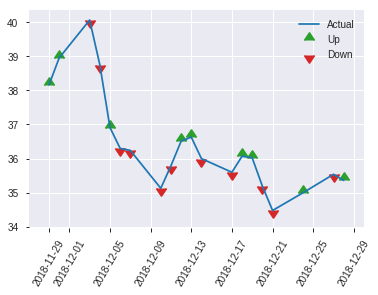


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24289829013001424
RMSE: 0.4928471265311529
LogLoss: 0.7022150379517502
Null degrees of freedom: 250
Residual degrees of freedom: 225
Null deviance: 349.1066907598522
Residual deviance: 352.5119490517787
AIC: 404.5119490517787
AUC: 0.7123995407577498
pr_auc: 0.6745711967182669
Gini: 0.4247990815154996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1454450906558103: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   78   0.5821   (78.0/134.0)
1      10   107  0.0855   (10.0/117.0)
Total  66   185  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.145445     0.708609  184
max f2                       0.017745     0.819328  245
max f0point5                 0.231497     0.641562  149
max accuracy                 0.231497     0.669323  149
max precision                0.771348     1         0
max recall                   0.017745     1         245
max specificity              0.771348     1         0
max absolute_mcc             0.145445     0.376705  184
max min_per_class_accuracy   0.283479     0.649254  122
max mean_per_class_accuracy  0.203891     0.678371  155

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 29.82 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0119522                   0.726144           2.1453   2.1453             1                0.746536   1                           0.746536            0.025641        0.025641                   114.53   114.53
    2        0.0239044                   0.681569           2.1453   2.1453             1                0.699142   1                           0.722839            0.025641        0.0512821                  114.53   114.53
    3        0.0318725                   0.655783           2.1453   2.1453             1                0.665547   1                           0.708516            0.017094        0.0683761                  114.53   114.53
    4        0.0438247                   0.646763           1.4302   1.95027            0.666667         0.650439   0.909091                    0.692677            0.017094        0.0854701                  43.0199  95.0272
    5        0.0517928                   0.628249           2.1453   1.98028            1                0.639953   0.923077                    0.684565            0.017094        0.102564                   114.53   98.0276
    6        0.103586                    0.562939           1.48521  1.73274            0.692308         0.588597   0.807692                    0.636581            0.0769231       0.179487                   48.5207  73.2742
    7        0.151394                    0.510614           1.07265  1.52429            0.5              0.534987   0.710526                    0.604499            0.0512821       0.230769                   7.26496  52.4291
    8        0.203187                    0.474283           1.48521  1.51433            0.692308         0.491165   0.705882                    0.57561             0.0769231       0.307692                   48.5207  51.4329
    9        0.302789                    0.409208           1.02974  1.35493            0.48             0.431226   0.631579                    0.528115            0.102564        0.410256                   2.97436  35.4926
    10       0.40239                     0.347065           1.4588   1.38064            0.68             0.369753   0.643564                    0.488917            0.145299        0.555556                   45.8803  38.0638
    11       0.501992                    0.280045           1.11556  1.32804            0.52             0.31282    0.619048                    0.453977            0.111111        0.666667                   11.5556  32.8042
    12       0.601594                    0.228265           1.20137  1.30707            0.56             0.253397   0.609272                    0.420768            0.119658        0.786325                   20.1368  30.707
    13       0.701195                    0.169104           0.85812  1.2433             0.4              0.193866   0.579545                    0.388538            0.0854701       0.871795                   -14.188  24.3298
    14       0.800797                    0.117071           0.42906  1.14202            0.2              0.136786   0.532338                    0.357225            0.042735        0.91453                    -57.094  14.2025
    15       0.900398                    0.0638854          0.42906  1.06316            0.2              0.0888761  0.495575                    0.327541            0.042735        0.957265                   -57.094  6.31571
    16       1                           0.000569694        0.42906  1                  0.2              0.0324667  0.466135                    0.298151            0.042735        1 

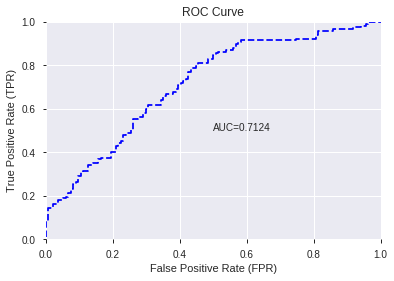

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


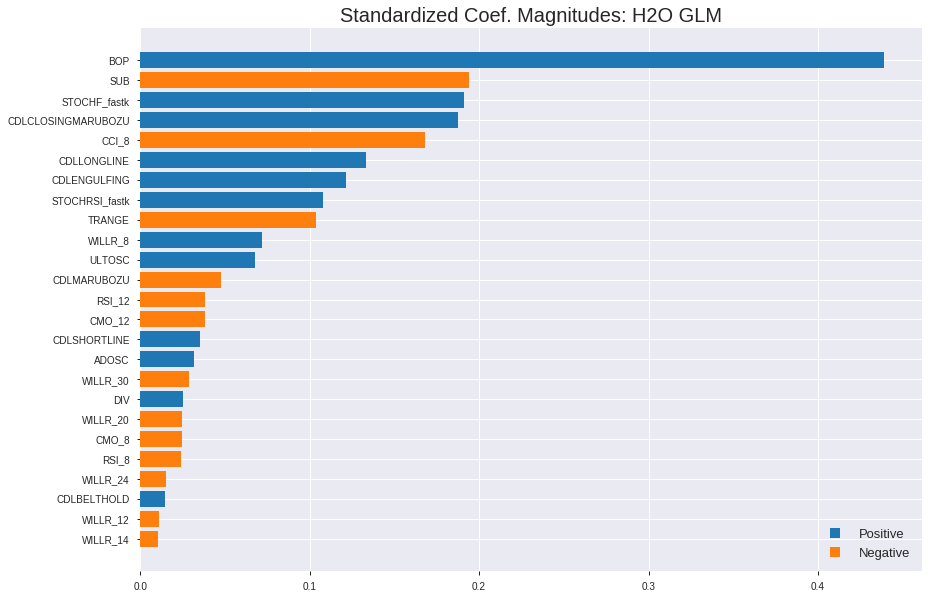

'log_likelihood'
--2019-08-25 17:00:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_170014_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_170014_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'CDLLONGLINE',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'TRANGE',
 'WILLR_8',
 'ULTOSC',
 'CDLMARUBOZU',
 'RSI_12',
 'CMO_12',
 'CDLSHORTLINE',
 'ADOSC',
 'WILLR_30',
 'DIV',
 'WILLR_20',
 'CMO_8',
 'RSI_8',
 'WILLR_24',
 'CDLBELTHOLD',
 'WILLR_12',
 'WILLR_14']

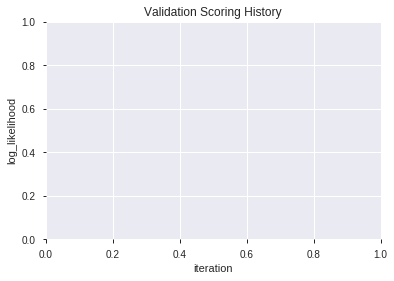

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_170028  0.760492  0.591994              0.320959  0.451622  0.203963
1  XGBoost_grid_1_AutoML_20190825_170028_model_3  0.758005  0.598042              0.321501  0.455138  0.207151
2  XGBoost_grid_1_AutoML_20190825_170028_model_7  0.752519  0.605064              0.326317  0.458669  0.210377
3               XGBoost_3_AutoML_20190825_170028  0.750542  0.598842              0.313018  0.455686  0.207650
4               XGBoost_1_AutoML_20190825_170028  0.748118  0.600002              0.320481  0.455839  0.207789
5  XGBoost_grid_1_AutoML_20190825_170028_model_4  0.747863  0.597929              0.316750  0.454300  0.206389
6  XGBoost_grid_1_AutoML_20190825_170028_model_6  0.745184  0.612424              0.324691  0.462088  0.213525
7  XGBoost_grid_1_AutoML_20190825_170028_model_1  0.737594  0.612602              0.313560  0.462970  0.214341
8  XGBoost_grid_1_AutoML_20190825_170028_model_2  0.737211  0.605100              0.337990  0.458802  0.210500
9  XGBoost_grid_1_AutoML_20190825_170028_model_5  0.718268  0.653215              0.368925  0.478037  0.228520

variable  relative_importance  scaled_importance  percentage
0                  BOP          1917.664795           1.000000    0.326156
1         STOCHF_fastk           460.605652           0.240191    0.078340
2                  SUB           432.007538           0.225278    0.073476
3                CCI_8           424.161438           0.221186    0.072141
4                  DIV           274.542053           0.143165    0.046694
5               TRANGE           232.115265           0.121041    0.039478
6              WILLR_8           225.846039           0.117771    0.038412
7             WILLR_30           219.302292           0.114359    0.037299
8               ULTOSC           210.677612           0.109862    0.035832
9                ADOSC           191.607407           0.099917    0.032589
10            WILLR_14           185.657684           0.096814    0.031577
11      STOCHRSI_fastk           156.665924           0.081696    0.026646
12            WILLR_12           154.136246           0.080377    0.026215
13              CMO_12           145.701477           0.075979    0.024781
14               CMO_8           142.072495           0.074086    0.024164
15            WILLR_24           134.040939           0.069898    0.022798
16            WILLR_20           106.973129           0.055783    0.018194
17               RSI_8            73.951889           0.038564    0.012578
18         CDLLONGLINE            63.288448           0.033003    0.010764
19  CDLCLOSINGMARUBOZU            52.877838           0.027574    0.008993
20              RSI_12            50.506889           0.026338    0.008590
21         CDLBELTHOLD            18.320004           0.009553    0.003116
22        CDLSHORTLINE             6.875614           0.003585    0.001169

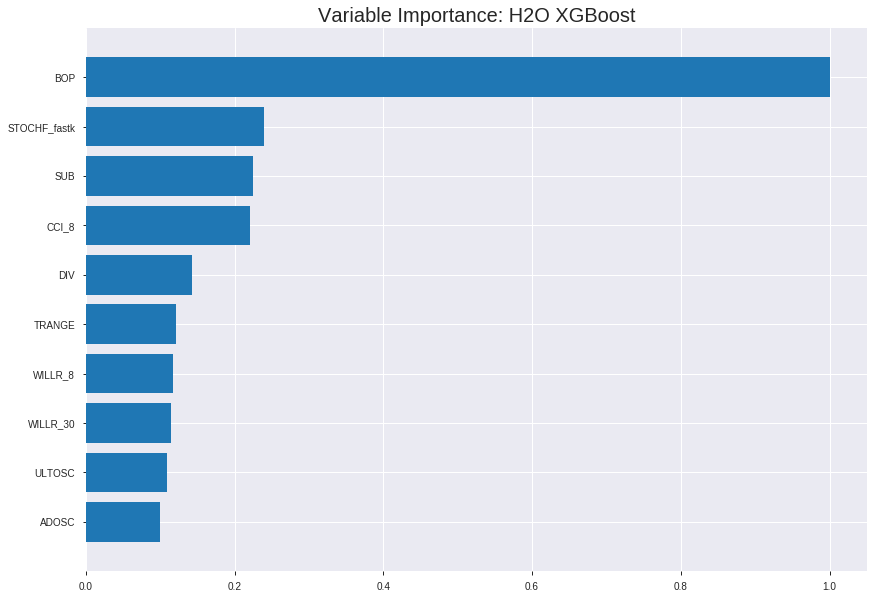

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_170028


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16265435099280254
RMSE: 0.4033042908187347
LogLoss: 0.5003709498885341
Mean Per-Class Error: 0.21857365056041023
AUC: 0.8633560519610448
pr_auc: 0.8649784544505432
Gini: 0.7267121039220896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5010228991508484: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      617  235  0.2758   (235.0/852.0)
1      152  749  0.1687   (152.0/901.0)
Total  769  984  0.2208   (387.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501023     0.794695  208
max f2                       0.257787     0.872781  325
max f0point5                 0.608416     0.810735  147
max accuracy                 0.532359     0.781517  190
max precision                0.894452     1         0
max recall                   0.142459     1         378
max specificity              0.894452     1         0
max absolute_mcc             0.532359     0.562772  190
max min_per_class_accuracy   0.534828     0.780244  189
max mean_per_class_accuracy  0.532359     0.781426  190

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.870777           1.94562    1.94562            1                0.879089  1                           0.879089            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.862623           1.72944    1.83753            0.888889         0.866323  0.944444                    0.872706            0.017758        0.0377358                  72.9436   83.7526
    3        0.0302339                   0.853767           1.71672    1.79878            0.882353         0.857683  0.924528                    0.867887            0.0166482       0.054384                   71.672    79.8777
    4        0.040502                    0.847942           1.94562    1.836              1                0.850546  0.943662                    0.863491            0.0199778       0.0743618                  94.5616   83.6004
    5        0.0501997                   0.834496           1.94562    1.85718            1                0.840808  0.954545                    0.859109            0.0188679       0.0932297                  94.5616   85.7179
    6        0.100399                    0.787817           1.87929    1.86823            0.965909         0.809609  0.960227                    0.834359            0.0943396       0.187569                   87.9288   86.8234
    7        0.150029                    0.748881           1.81144    1.84944            0.931034         0.766625  0.95057                     0.811952            0.0899001       0.277469                   81.1436   84.9445
    8        0.200228                    0.714615           1.76874    1.82921            0.909091         0.731296  0.940171                    0.791731            0.0887902       0.36626                    76.8742   82.9212
    9        0.300057                    0.651716           1.60096    1.75327            0.822857         0.681359  0.901141                    0.75501             0.159822        0.526082                   60.0964   75.3274
    10       0.399886                    0.597135           1.36749    1.65697            0.702857         0.623655  0.851641                    0.722218            0.136515        0.662597                   36.749    65.6965
    11       0.500285                    0.539946           1.05019    1.5352             0.539773         0.571046  0.789054                    0.69188             0.105438        0.768036                   5.01904   53.5195
    12       0.600114                    0.471207           0.856071   1.42222            0.44             0.505838  0.730989                    0.660932            0.0854606       0.853496                   -14.3929  42.2223
    13       0.699943                    0.397366           0.667068   1.31452            0.342857         0.432305  0.675632                    0.628324            0.0665927       0.920089                   -33.2932  31.452
    14       0.799772                    0.29648            0.466948   1.20872            0.24             0.350489  0.621255                    0.593645            0.0466149       0.966704                   -53.3052  20.8724
    15       0.899601                    0.183984           0.277945   1.10544            0.142857         0.240406  0.568167                    0.554446            0.0277469       0.994451                   -72.2055  10.5436
    16       1                           0.0869764          0.0552732  1                  0.0284091        0.145084  0.513976                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20425188238886044
RMSE: 0.4519423440980724
LogLoss: 0.5945266572756133
Mean Per-Class Error: 0.29328100825167613
AUC: 0.7506043708096958
pr_auc: 0.7566628660234911
Gini: 0.5012087416193916
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33137550950050354: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  112  0.5      (112.0/224.0)
1      33   244  0.1191   (33.0/277.0)
Total  145  356  0.2894   (145.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331376     0.770932  285
max f2                       0.157635     0.869289  373
max f0point5                 0.375146     0.731861  261
max accuracy                 0.375146     0.720559  261
max precision                0.879349     1         0
max recall                   0.124788     1         394
max specificity              0.879349     1         0
max absolute_mcc             0.375146     0.431743  261
max min_per_class_accuracy   0.497803     0.66426   203
max mean_per_class_accuracy  0.375146     0.706719  261

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.870895           1.20578   1.20578            0.666667         0.875413  0.666667                    0.875413            0.0144404       0.0144404                  20.5776   20.5776
    2        0.0239521                   0.863933           1.50722   1.3565             0.833333         0.86478   0.75                        0.870096            0.0180505       0.032491                   50.722    35.6498
    3        0.0319361                   0.859225           1.80866   1.46954            1                0.862014  0.8125                      0.868076            0.0144404       0.0469314                  80.8664   46.954
    4        0.0419162                   0.858582           1.0852    1.37803            0.6              0.858892  0.761905                    0.865889            0.0108303       0.0577617                  8.51986   37.803
    5        0.0518962                   0.851985           1.80866   1.46084            1                0.854682  0.807692                    0.863734            0.0180505       0.0758123                  80.8664   46.0844
    6        0.101796                    0.820599           1.51928   1.48949            0.84             0.835877  0.823529                    0.850079            0.0758123       0.151625                   51.9278   48.9488
    7        0.151697                    0.771854           1.59162   1.52309            0.88             0.797194  0.842105                    0.832682            0.0794224       0.231047                   59.1625   52.3086
    8        0.201597                    0.733557           1.44693   1.50424            0.8              0.753558  0.831683                    0.813097            0.0722022       0.303249                   44.6931   50.4236
    9        0.301397                    0.63779            1.33841   1.44933            0.74             0.685227  0.801325                    0.770756            0.133574        0.436823                   33.8412   44.9327
    10       0.401198                    0.569798           1.22989   1.39474            0.68             0.603636  0.771144                    0.729184            0.122744        0.559567                   22.9892   39.4741
    11       0.500998                    0.504524           0.904332  1.29705            0.5              0.539374  0.717131                    0.691373            0.0902527       0.649819                   -9.56679  29.705
    12       0.600798                    0.417204           1.0852    1.26186            0.6              0.465967  0.697674                    0.65393             0.108303        0.758123                   8.51986   26.1859
    13       0.700599                    0.336302           1.12137   1.24185            0.62             0.377105  0.68661                     0.614496            0.111913        0.870036                   12.1372   24.1846
    14       0.800399                    0.267489           0.542599  1.15466            0.3              0.300544  0.638404                    0.57535             0.0541516       0.924188                   -45.7401  15.4658
    15       0.9002                      0.191296           0.470253  1.07878            0.26             0.232482  0.596452                    0.537338            0.0469314       0.971119                   -52.9747  7.8782
    16       1                           0.101497           0.289386  1                  0.16             0.147636  0.552894                    0.498446            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:00:29  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.486024                         0.5                0.693147              0.5               0                    1                  0.447106
    2019-08-25 17:00:29  0.036 sec   5                  0.476046         0.646051            0.800446        0.79088            1.84322          0.27895                          0.478927           0.651614              0.75328           0.742497             1.20578            0.307385
    2019-08-25 17:00:29  0.068 sec   10                 0.459916         0.614712            0.815119        0.818639           1.83753          0.305762                         0.468391           0.630841              0.753207          0.75717              1.50722            0.295409
    2019-08-25 17:00:29  0.102 sec   15                 0.447657         0.590543            0.819761        0.823274           1.86102          0.301768                         0.460224           0.614323              0.754392          0.758772             1.50722            0.297405
    2019-08-25 17:00:29  0.143 sec   20                 0.438139         0.571561            0.82542         0.829497           1.94562          0.258414                         0.454334           0.602135              0.757849          0.764187             1.55028            0.297405
    2019-08-25 17:00:29  0.181 sec   25                 0.430735         0.556414            0.830977        0.8353             1.94562          0.25328                          0.452252           0.597139              0.754803          0.760525             1.50722            0.313373
    2019-08-25 17:00:29  0.232 sec   30                 0.424888         0.544493            0.837338        0.838605           1.83753          0.252139                         0.451658           0.595155              0.753191          0.75678              1.20578            0.291417
    2019-08-25 17:00:29  0.270 sec   35                 0.419684         0.533821            0.842395        0.845748           1.94562          0.255562                         0.451589           0.59451               0.750693          0.758076             1.50722            0.291417
    2019-08-25 17:00:29  0.310 sec   40                 0.414856         0.523723            0.847538        0.851089           1.94562          0.254421                         0.450696           0.592709              0.750524          0.7564               1.20578            0.291417
    2019-08-25 17:00:29  0.349 sec   45                 0.41074          0.515309            0.852763        0.854192           1.94562          0.247005                         0.451342           0.593625              0.75021           0.754659             1.20578            0.291417
    2019-08-25 17:00:30  0.395 sec   50                 0.406831         0.507594            0.858587        0.85881            1.94562          0.237307                         0.45182            0.594566              0.749275          0.74909              1.20578            0.287425
    2019-08-25 17:00:30  0.440 sec   55                 0.403304         0.500371            0.863356        0.864978           1.94562          0.220764                         0.451942           0.594527              0.750604          0

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1917.664794921875      1.0                    0.32615572992044417
STOCHF_fastk        460.60565185546875     0.24019090983741695    0.07833964151827832
SUB                 432.0075378417969      0.22527792082630202    0.07347568470206257
CCI_8               424.16143798828125     0.22118643420450415    0.07214122289647036
DIV                 274.54205322265625     0.14316477725912521    0.04669401242584779
---                 ---                    ---                    ---
CDLLONGLINE         63.288448333740234     0.03300287333914298    0.010764076243400145
CDLCLOSINGMARUBOZU  52.877838134765625     0.0275740777401714     0.008993443452228675
RSI_12              50.50688934326172      0.026337704836115194   0.008590193345252364
CDLBELTHOLD         18.320003509521484     0.009553287705981918   0.003115859524884538
CDLSHORTLINE        6.875614166259766      0.0035854098090901624  0.0011694019533477224


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.7213114754098361)

('auc', 0.7604924097461411)

('logloss', 0.5919940205072292)

('mean_per_class_error', 0.30418420716928174)

('rmse', 0.4516221664130444)

('mse', 0.20396258119561161)

xgboost prediction progress: |████████████████████████████████████████████| 100%


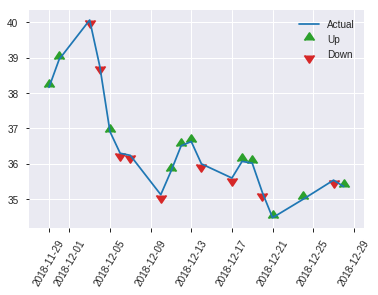


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20396258119561161
RMSE: 0.4516221664130444
LogLoss: 0.5919940205072292
Mean Per-Class Error: 0.30418420716928174
AUC: 0.7604924097461411
pr_auc: 0.7069644962253522
Gini: 0.5209848194922821
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22556747496128082: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   78   0.5821   (78.0/134.0)
1      7    110  0.0598   (7.0/117.0)
Total  63   188  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.225567     0.721311  187
max f2                       0.19388      0.83958   198
max f0point5                 0.487246     0.683168  96
max accuracy                 0.487246     0.697211  96
max precision                0.869173     1         0
max recall                   0.111164     1         247
max specificity              0.869173     1         0
max absolute_mcc             0.225567     0.411982  187
max min_per_class_accuracy   0.426095     0.679104  122
max mean_per_class_accuracy  0.439056     0.695816  116

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 40.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.845126           2.1453    2.1453             1                0.859017  1                           0.859017            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.83514            1.4302    1.78775            0.666667         0.83822   0.833333                    0.848619            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.826973           2.1453    1.87714            1                0.829674  0.875                       0.843882            0.017094        0.0598291                  114.53    87.7137
    4        0.0438247                   0.812067           2.1453    1.95027            1                0.818337  0.909091                    0.836916            0.025641        0.0854701                  114.53    95.0272
    5        0.0517928                   0.772525           2.1453    1.98028            1                0.781246  0.923077                    0.828351            0.017094        0.102564                   114.53    98.0276
    6        0.103586                    0.663188           1.32018   1.65023            0.615385         0.725785  0.769231                    0.777068            0.0683761       0.17094                    32.0184   65.023
    7        0.151394                    0.6315             1.60897   1.6372             0.75             0.645089  0.763158                    0.73539             0.0769231       0.247863                   60.8974   63.7202
    8        0.203187                    0.602407           1.81525   1.68259            0.846154         0.617906  0.784314                    0.705444            0.0940171       0.34188                    81.5253   68.2588
    9        0.302789                    0.539956           1.20137   1.52429            0.56             0.570227  0.710526                    0.660964            0.119658        0.461538                   20.1368   52.4291
    10       0.40239                     0.473894           1.37299   1.48684            0.64             0.511951  0.693069                    0.62408             0.136752        0.598291                   37.2991   48.6841
    11       0.501992                    0.407537           1.02974   1.39615            0.48             0.444157  0.650794                    0.588381            0.102564        0.700855                   2.97436   39.6147
    12       0.601594                    0.305231           0.943932  1.32128            0.44             0.352341  0.615894                    0.549301            0.0940171       0.794872                   -5.60684  32.1277
    13       0.701195                    0.249233           0.943932  1.26768            0.44             0.274488  0.590909                    0.510265            0.0940171       0.888889                   -5.60684  26.7677
    14       0.800797                    0.189992           0.686496  1.19539            0.32             0.21795   0.557214                    0.473908            0.0683761       0.957265                   -31.3504  19.5391
    15       0.900398                    0.143303           0.257436  1.09163            0.12             0.163683  0.50885                     0.439591            0.025641        0.982906                   -74.2564  9.16345
    16       1                           0.0955837          0.171624  1                  0.08             0.12764   0.466135                    0.40852            

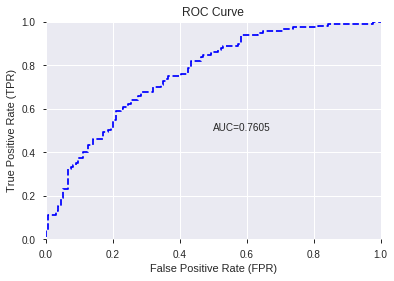

This function is available for GLM models only


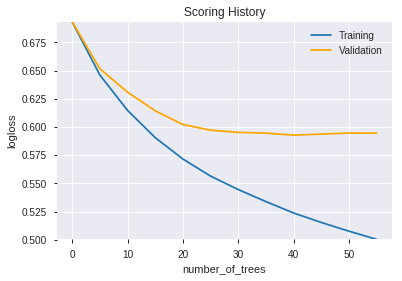

--2019-08-25 17:00:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


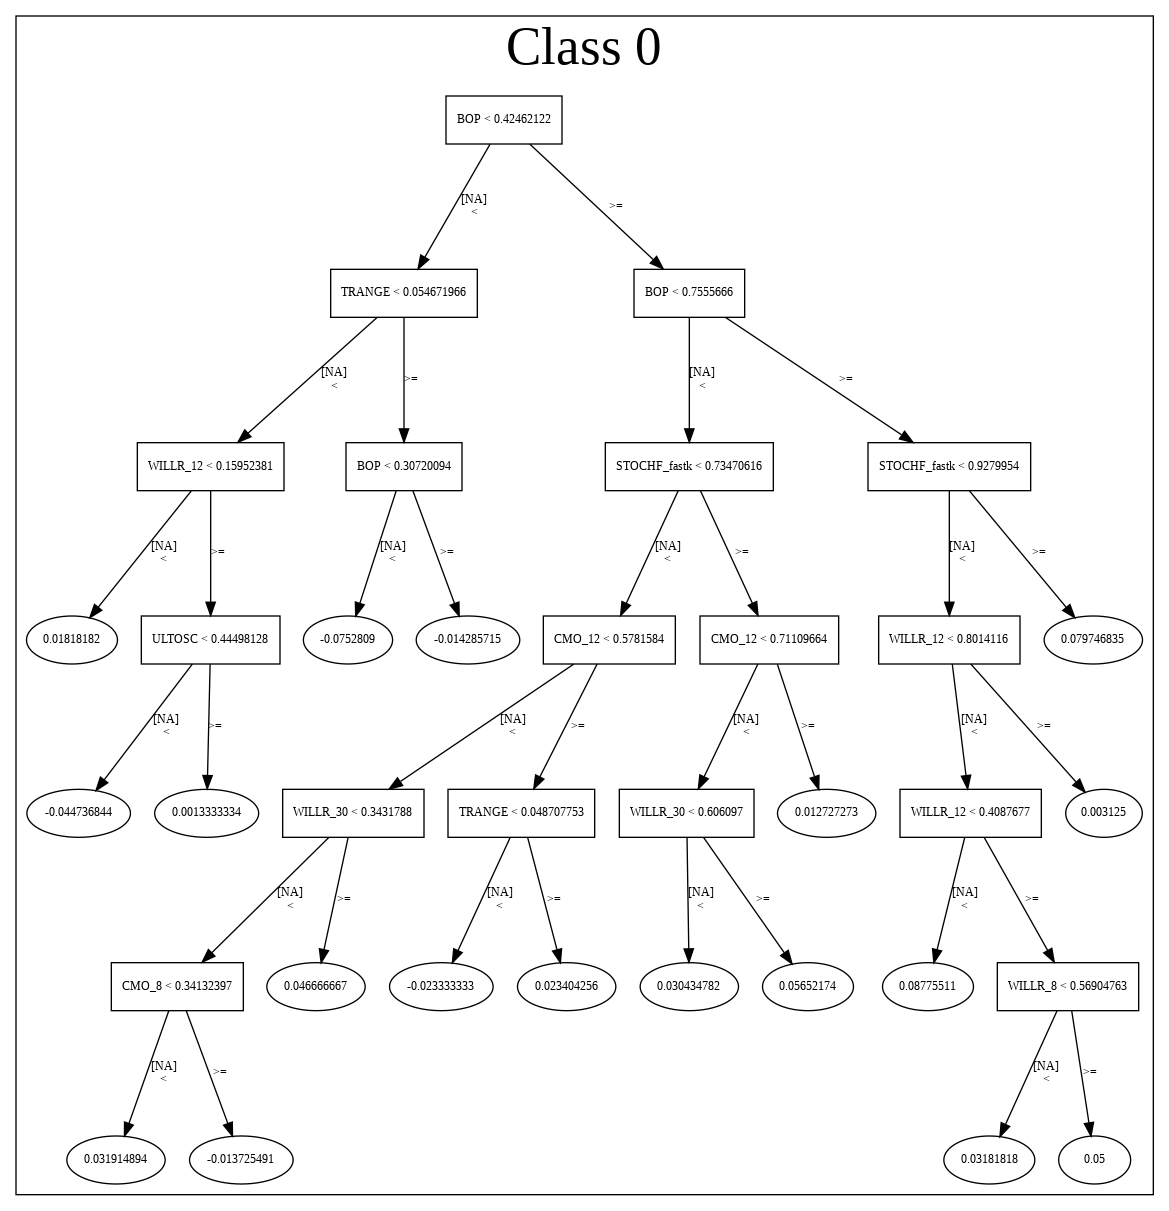

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_170028',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_170028',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b69b',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'DIV',
 'TRANGE',
 'WILLR_8',
 'WILLR_30',
 'ULTOSC',
 'ADOSC',
 'WILLR_14',
 'STOCHRSI_fastk',
 'WILLR_12',
 'CMO_12',
 'CMO_8',
 'WILLR_24',
 'WILLR_20',
 'RSI_8',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'RSI_12',
 'CDLBELTHOLD',
 'CDLSHORTLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

76

['BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_upperband_14_5_5',
 'BBANDS_upperband_14_7_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_upperband_20_1_3',
 'MAVP_20_2',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_lowerband_20_6_4',
 'BBANDS_lowerband_24_1_5',
 'BBANDS_lowerband_24_7_2',
 'BOP',
 'CCI_8',
 'CMO_8',
 'DX_8',
 'MACDFIX_signal_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'ROCR_8',
 'WILLR_8',
 'CCI_12',
 'MACDFIX_signal_12',
 'MACDFIX_hist_12',
 'MOM_12',
 'PLUS_DM_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'aroonup_14',
 'MFI_14',
 'MINUS_DI_14',
 'MOM_14',
 'PLUS_DI_14',
 'aroondown_20',
 'DX_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'MINUS_DI_24',
 'PLUS_DI_24',
 'ROCP_24',
 'RSI_24',
 'WILLR_24',
 'aroonup_30',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_170158_model_9  0.700791  0.630323              0.354063  0.469664  0.220584
1  DeepLearning_grid_1_AutoML_20190825_170158_model_8  0.677063  0.705373              0.381203  0.503136  0.253145
2  DeepLearning_grid_1_AutoML_20190825_170158_model_7  0.673173  0.897714              0.355211  0.549895  0.302385
3  DeepLearning_grid_1_AutoML_20190825_170158_model_5  0.655568  0.747215              0.394566  0.514984  0.265209
4  DeepLearning_grid_1_AutoML_20190825_170158_model_3  0.635859  1.901460              0.420685  0.646533  0.418005
5  DeepLearning_grid_1_AutoML_20190825_170158_model_4  0.634265  0.965931              0.438800  0.534425  0.285610
6  DeepLearning_grid_1_AutoML_20190825_170158_model_6  0.626738  0.863031              0.396734  0.540884  0.292556
7  DeepLearning_grid_1_AutoML_20190825_170158_model_2  0.619339  4.726799              0.428690  0.667862  0.446040
8  DeepLearning_grid_1_AutoML_20190825_170158_model_1  0.593060  1.723743              0.470691  0.603442  0.364142
9               DeepLearning_1_AutoML_20190825_170158  0.524493  1.217388              0.485075  0.602498  0.363004

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.024330
1                     TRANGE             0.736603           0.736603    0.017921
2         CDLCLOSINGMARUBOZU             0.723453           0.723453    0.017601
3                CDLLONGLINE             0.721445           0.721445    0.017552
4               CDLENGULFING             0.634791           0.634791    0.015444
..                       ...                  ...                ...         ...
71  BBANDS_middleband_14_2_3             0.498706           0.498706    0.012133
72           MACDFIX_hist_12             0.496748           0.496748    0.012086
73                   ROCP_24             0.495275           0.495275    0.012050
74                   ROCP_20             0.493783           0.493783    0.012014
75                     CCI_8             0.490681           0.490681    0.011938

[76 rows x 4 columns]

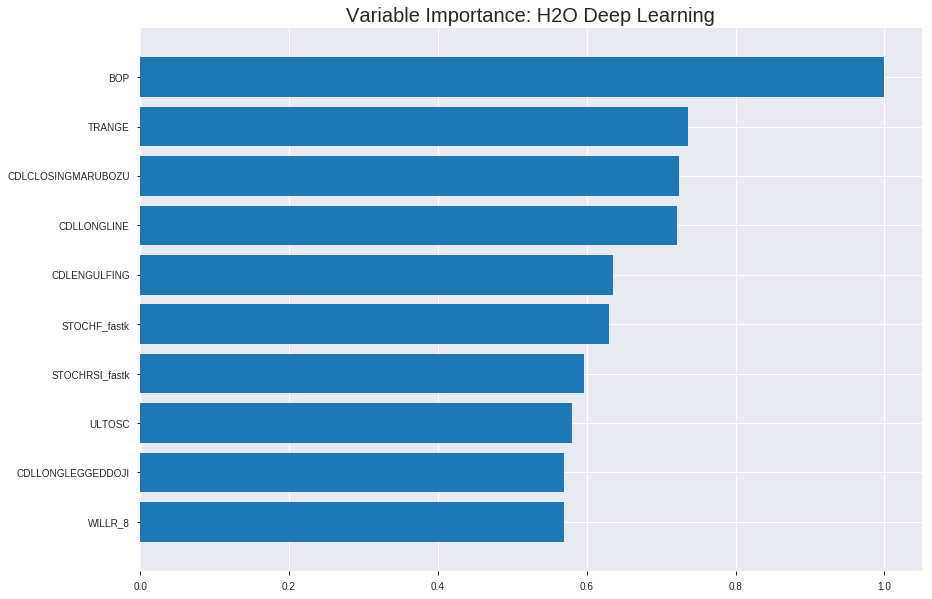

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_170158_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20449389303782856
RMSE: 0.452210009882387
LogLoss: 0.5954716749741127
Mean Per-Class Error: 0.3072948419335845
AUC: 0.757893550723505
pr_auc: 0.75235798996677
Gini: 0.5157871014470099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5001886961976316: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      449  403   0.473    (403.0/852.0)
1      146  755   0.162    (146.0/901.0)
Total  595  1158  0.3132   (549.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500189     0.733366  213
max f2                       0.259764     0.84873   334
max f0point5                 0.590267     0.708793  145
max accuracy                 0.529957     0.693668  192
max precision                0.849769     1         0
max recall                   0.0951835    1         387
max specificity              0.849769     1         0
max absolute_mcc             0.529957     0.389782  192
max min_per_class_accuracy   0.565939     0.690344  165
max mean_per_class_accuracy  0.574502     0.692705  159

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 52.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.803156           1.72944   1.72944            0.888889         0.823379  0.888889                    0.823379            0.017758        0.017758                   72.9436   72.9436
    2        0.0205362                   0.781751           1.94562   1.83753            1                0.789383  0.944444                    0.806381            0.0199778       0.0377358                  94.5616   83.7526
    3        0.0302339                   0.76071            1.71672   1.79878            0.882353         0.769474  0.924528                    0.794543            0.0166482       0.054384                   71.672    79.8777
    4        0.040502                    0.753573           1.83753   1.8086             0.944444         0.756634  0.929577                    0.784932            0.0188679       0.0732519                  83.7526   80.8601
    5        0.0501997                   0.746287           1.48782   1.74663            0.764706         0.750107  0.897727                    0.778205            0.0144284       0.0876804                  48.7824   74.6633
    6        0.100399                    0.718778           1.54765   1.64714            0.795455         0.730837  0.846591                    0.754521            0.0776915       0.165372                   54.7649   64.7141
    7        0.150029                    0.691248           1.38653   1.56093            0.712644         0.70477   0.802281                    0.738063            0.0688124       0.234184                   38.6531   56.0931
    8        0.200228                    0.668928           1.56976   1.56314            0.806818         0.680459  0.803419                    0.723621            0.0788013       0.312986                   56.9758   56.3144
    9        0.300057                    0.630193           1.40084   1.50915            0.72             0.649599  0.775665                    0.698994            0.139845        0.45283                    40.0844   50.9147
    10       0.399886                    0.59955            1.26743   1.4488             0.651429         0.615101  0.74465                     0.678051            0.126526        0.579356                   26.743    44.8804
    11       0.500285                    0.566664           1.05019   1.36881            0.539773         0.583023  0.703535                    0.65898             0.105438        0.684795                   5.01904   36.8809
    12       0.600114                    0.529348           1.01172   1.30941            0.52             0.549356  0.673004                    0.640744            0.100999        0.785794                   1.17203   30.9407
    13       0.699943                    0.471083           0.756011  1.23048            0.388571         0.504446  0.632437                    0.621305            0.0754717       0.861265                   -24.3989  23.0479
    14       0.799772                    0.382564           0.678186  1.16154            0.348571         0.430158  0.597004                    0.597445            0.0677026       0.928968                   -32.1814  16.1541
    15       0.899601                    0.268555           0.466948  1.08446            0.24             0.326667  0.557387                    0.567397            0.0466149       0.975583                   -53.3052  8.44619
    16       1                           0.0524064          0.243202  1                  0.125            0.168863  0.513976                    0.527385         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2094149340218698
RMSE: 0.4576187649363494
LogLoss: 0.606892667568175
Mean Per-Class Error: 0.31305602114492004
AUC: 0.7530460288808664
pr_auc: 0.7663814831553358
Gini: 0.5060920577617327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3745477528533676: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      84   140  0.625    (140.0/224.0)
1      17   260  0.0614   (17.0/277.0)
Total  101  400  0.3134   (157.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374548     0.768095  306
max f2                       0.244185     0.871091  358
max f0point5                 0.514583     0.723525  177
max accuracy                 0.483901     0.688623  209
max precision                0.787237     1         0
max recall                   0.129249     1         389
max specificity              0.787237     1         0
max absolute_mcc             0.374548     0.388676  306
max min_per_class_accuracy   0.504359     0.678571  192
max mean_per_class_accuracy  0.514583     0.686944  177

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 48.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.749914           1.50722   1.50722            0.833333         0.769895  0.833333                    0.769895            0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.73686            1.44693   1.47982            0.8              0.740669  0.818182                    0.756611            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.717213           1.80866   1.58258            1                0.721513  0.875                       0.745643            0.0180505       0.0505415                  80.8664   58.2581
    4        0.0419162                   0.706763           1.44693   1.55028            0.8              0.709774  0.857143                    0.737102            0.0144404       0.0649819                  44.6931   55.0284
    5        0.0518962                   0.699031           1.80866   1.59997            1                0.702431  0.884615                    0.730435            0.0180505       0.0830325                  80.8664   59.9972
    6        0.101796                    0.645679           1.51928   1.56042            0.84             0.667547  0.862745                    0.699607            0.0758123       0.158845                   51.9278   56.0416
    7        0.151697                    0.624238           1.66397   1.59448            0.92             0.633356  0.881579                    0.677814            0.0830325       0.241877                   66.3971   59.448
    8        0.201597                    0.605808           1.30224   1.52214            0.72             0.61621   0.841584                    0.662566            0.0649819       0.306859                   30.2238   52.2143
    9        0.301397                    0.565383           1.33841   1.4613             0.74             0.583319  0.807947                    0.636325            0.133574        0.440433                   33.8412   46.1305
    10       0.401198                    0.537511           1.15755   1.38574            0.64             0.551231  0.766169                    0.615157            0.115523        0.555957                   15.7545   38.5743
    11       0.500998                    0.509261           1.04903   1.31867            0.58             0.523783  0.729084                    0.596955            0.104693        0.66065                    4.90253   31.8668
    12       0.600798                    0.471917           0.904332  1.24984            0.5              0.49041   0.69103                     0.579257            0.0902527       0.750903                   -9.56679  24.9841
    13       0.700599                    0.430508           0.868159  1.19547            0.48             0.452702  0.660969                    0.561229            0.0866426       0.837545                   -13.1841  19.547
    14       0.800399                    0.37419            1.01285   1.1727             0.56             0.404912  0.648379                    0.541738            0.101083        0.938628                   1.2852    17.27
    15       0.9002                      0.266007           0.32556   1.07878            0.18             0.324268  0.596452                    0.517628            0.032491        0.971119                   -67.444   7.8782
    16       1                           0.0521008          0.289386  1                  0.16             0.175766  0.552894                    0.48351             0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:09:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:09:43  2 min 26.583 sec  478 obs/sec       0.67085   1             1176       0.503687         0.783363            -0.015596      0.718882        0.707994           1.83753          0.361666                         0.487578           0.707874              0.0383091        0.711772          0.739133             1.80866            0.327345
    2019-08-25 17:09:54  2 min 38.055 sec  722 obs/sec       5.32573   8             9336       0.45221          0.595472            0.181385       0.757894        0.752358           1.72944          0.313177                         0.457619           0.606893              0.15286          0.753046          0.766381             1.50722            0.313373
    2019-08-25 17:10:05  2 min 48.436 sec  838 obs/sec       10.6383   16            18649      0.446117         0.583519            0.203296       0.766978        0.758644           1.72944          0.345123                         0.487181           0.666077              0.0398742        0.743723          0.757142             1.20578            0.331337
    2019-08-25 17:10:16  2 min 59.392 sec  941 obs/sec       17.2904   26            30310      0.448406         0.588848            0.195099       0.779268        0.770333           1.51326          0.299487                         0.486972           0.665681              0.0406965        0.748517          0.767227             1.50722            0.335329
    2019-08-25 17:10:26  3 min  9.344 sec  1020 obs/sec      23.9715   36            42022      0.439108         0.569448            0.228133       0.78503         0.77309            1.62135          0.301768                         0.48237            0.656528              0.0587424        0.755351          0.770391             1.50722            0.309381
    2019-08-25 17:10:36  3 min 19.755 sec  1086 obs/sec      31.3446   47            54947      0.436864         0.565101            0.236002       0.786967        0.774725           1.62135          0.292641                         0.492959           0.678737              0.0169634        0.752434          0.768538             1.50722            0.297405
    2019-08-25 17:10:37  3 min 20.780 sec  1085 obs/sec      31.3446   47            54947      0.45221          0.595472            0.181385       0.757894        0.752358           1.72944          0.313177                         0.457619           0.606893              0.15286          0.753046          0.766381             1.50722            0.313373

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.02432962774129458
TRANGE                    0.7366032004356384     0.7366032004356384   0.01792128165964528
CDLCLOSINGMARUBOZU        0.7234525680541992     0.7234525680541992   0.01760133166924225
CDLLONGLINE               0.7214454412460327     0.7214454412460327   0.01755249902116999
CDLENGULFING              0.6347914934158325     0.6347914934158325   0.015444240728147655
---                       ---                    ---                  ---
BBANDS_middleband_14_2_3  0.49870628118515015    0.49870628118515015  0.012133338173480085
MACDFIX_hist_12           0.49674829840660095    0.49674829840660095  0.012085701181354118
ROCP_24                   0.4952746033668518     0.4952746033668518   0.012049846729632828
ROCP_20                   0.49378347396850586    0.49378347396850586  0.01201356810645697
CCI_8                     0.4906805455684662     0.4906805455684662   0.011938075013576115


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6613545816733067)

('F1', 0.6910299003322259)

('auc', 0.7007909172088277)

('logloss', 0.6303225843990367)

('mean_per_class_error', 0.3290917208827657)

('rmse', 0.46966370526890694)

('mse', 0.22058399604691867)

deeplearning prediction progress: |███████████████████████████████████████| 100%


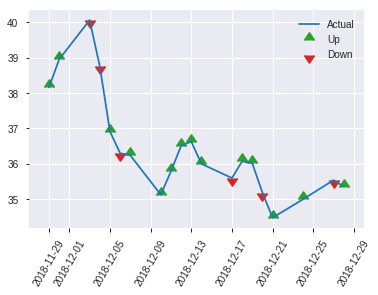


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22058399604691867
RMSE: 0.46966370526890694
LogLoss: 0.6303225843990367
Mean Per-Class Error: 0.3290917208827657
AUC: 0.7007909172088277
pr_auc: 0.6412453844344038
Gini: 0.4015818344176554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.365946524645819: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   80   0.597    (80.0/134.0)
1      13   104  0.1111   (13.0/117.0)
Total  67   184  0.3705   (93.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365947     0.69103   183
max f2                       0.293778     0.82232   212
max f0point5                 0.448113     0.634807  145
max accuracy                 0.448113     0.661355  145
max precision                0.654885     1         0
max recall                   0.161126     1         245
max specificity              0.654885     1         0
max absolute_mcc             0.430316     0.353076  157
max min_per_class_accuracy   0.476889     0.641026  121
max mean_per_class_accuracy  0.430316     0.670908  157

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 43.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.618743           1.4302    1.4302             0.666667         0.638654  0.666667                    0.638654            0.017094        0.017094                   43.0199   43.0199
    2        0.0239044                   0.613421           2.1453    1.78775            1                0.615545  0.833333                    0.6271              0.025641        0.042735                   114.53    78.7749
    3        0.0318725                   0.609362           1.07265   1.60897            0.5              0.612345  0.75                        0.623411            0.00854701      0.0512821                  7.26496   60.8974
    4        0.0438247                   0.59987            2.1453    1.75524            1                0.604042  0.818182                    0.618129            0.025641        0.0769231                  114.53    75.5245
    5        0.0517928                   0.595019           2.1453    1.81525            1                0.598006  0.846154                    0.615033            0.017094        0.0940171                  114.53    81.5253
    6        0.103586                    0.565015           1.32018   1.56772            0.615385         0.575757  0.730769                    0.595395            0.0683761       0.162393                   32.0184   56.7719
    7        0.151394                    0.549691           1.60897   1.58075            0.75             0.556734  0.736842                    0.583186            0.0769231       0.239316                   60.8974   58.0747
    8        0.203187                    0.526431           1.15516   1.47226            0.538462         0.538198  0.686275                    0.571719            0.0598291       0.299145                   15.5161   47.2264
    9        0.302789                    0.508557           1.11556   1.35493            0.52             0.517619  0.631579                    0.553923            0.111111        0.410256                   11.5556   35.4926
    10       0.40239                     0.493742           1.11556   1.29568            0.52             0.500325  0.60396                     0.540656            0.111111        0.521368                   11.5556   29.5676
    11       0.501992                    0.474188           1.37299   1.31102            0.64             0.482645  0.611111                    0.529146            0.136752        0.65812                    37.2991   31.1016
    12       0.601594                    0.442648           1.20137   1.29286            0.56             0.461106  0.602649                    0.517881            0.119658        0.777778                   20.1368   29.2862
    13       0.701195                    0.387478           0.772308  1.21892            0.36             0.415979  0.568182                    0.503406            0.0769231       0.854701                   -22.7692  21.892
    14       0.800797                    0.317535           0.600684  1.14202            0.28             0.349     0.532338                    0.484202            0.0598291       0.91453                    -39.9316  14.2025
    15       0.900398                    0.248888           0.514872  1.07265            0.24             0.286612  0.5                         0.462344            0.0512821       0.965812                   -48.5128  7.26496
    16       1                           0.0457309          0.343248  1                  0.16             0.189867  0.466135                    0.435205          

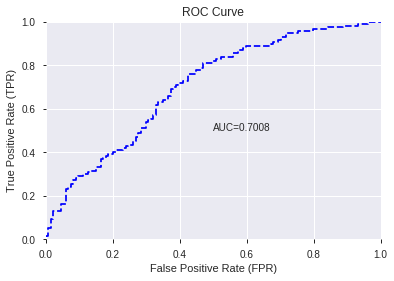

This function is available for GLM models only


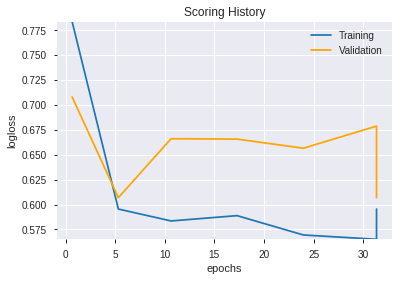

--2019-08-25 17:10:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


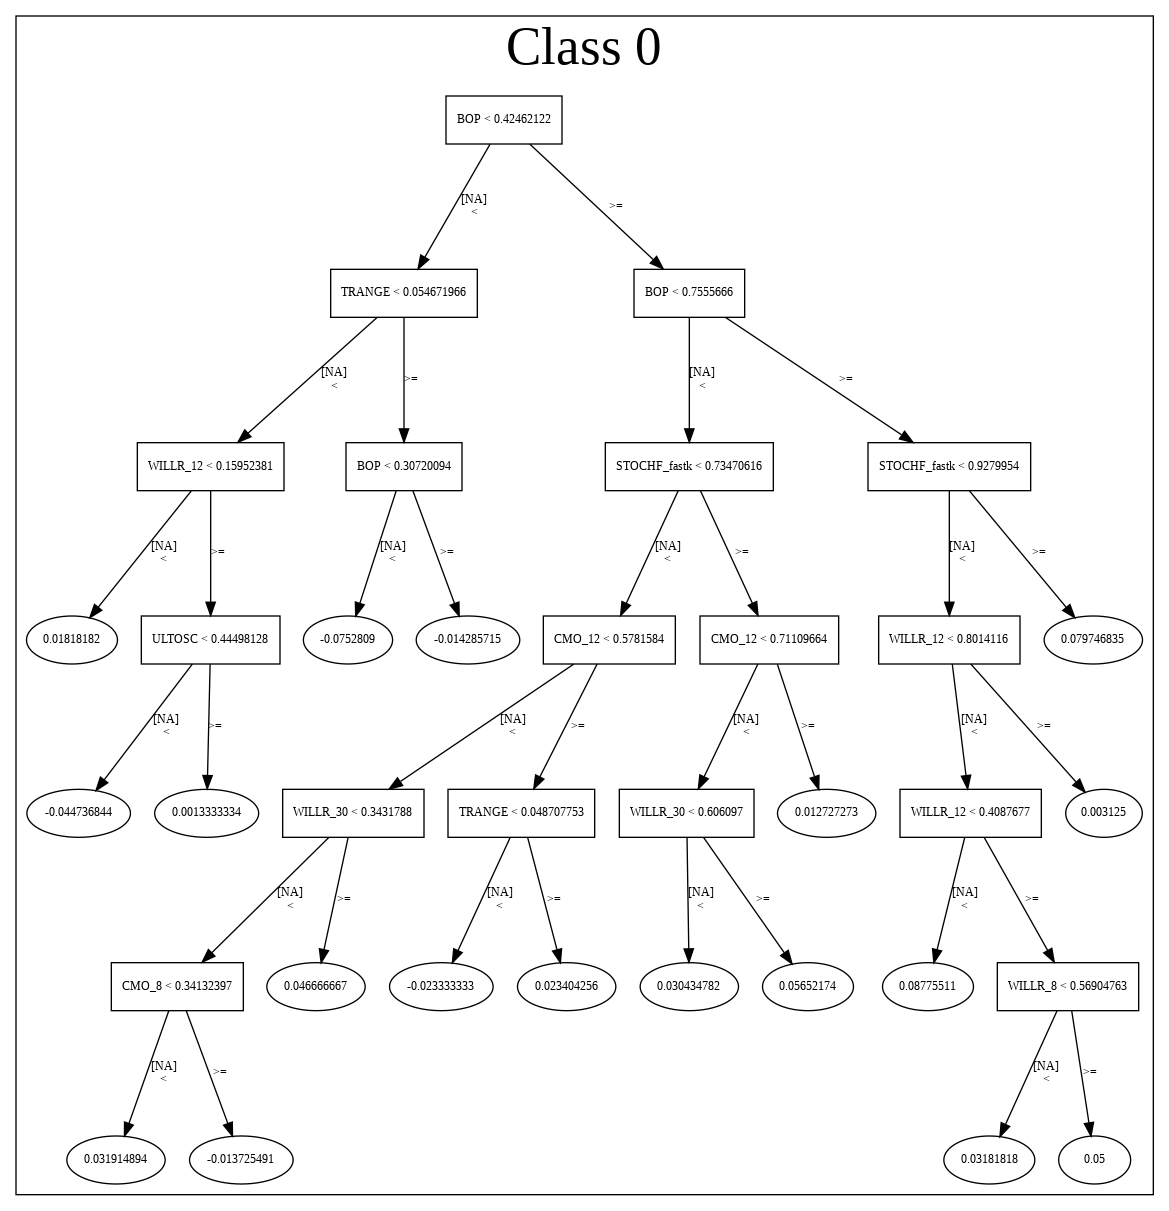

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_170158_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_170158_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLLONGLEGGEDDOJI',
 'WILLR_8',
 'DX_20',
 'MINUS_DI_14',
 'STOCHRSI_fastd',
 'MFI_14',
 'aroonup_30',
 'MACDFIX_signal_8',
 'MACDFIX_hist_8',
 'BBANDS_upperband_20_1_3',
 'CMO_24',
 'CORREL_8',
 'BBANDS_lowerband_14_3_2',
 'WILLR_20',
 'LINEARREG_ANGLE_8',
 'STOCH_slowd',
 'BETA_8',
 'AVGPRICE',
 'HT_DCPERIOD',
 'PLUS_DI_24',
 'RSI_12',
 'ROC_20',
 'ROCR_12',
 'aroondown_20',
 'CMO_8',
 'MAVP_20_2',
 'MFI_8',
 'DX_8',
 'PLUS_DI_14',
 'BBANDS_upperband_20_0_5',
 'ATR_12',
 'CCI_24',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_lowerband_20_5_3',
 'ROCR_20',
 'MACDFIX_signal_12',
 'MOM_12',
 'BBANDS_upperband_14_4_5',
 'PLUS_DM_12',
 'BBANDS_upperband_14_2_3',
 'MINUS_DI_8',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_20_6_4',
 'STOCH_slowk',
 'BBANDS_lowerband_24_7_2',
 'BBANDS_lowerband_20_3_4',
 'MINUS_DI_24',
 'PLUS_DI_20',
 'CDLSPINNINGTOP',
 'ROCR_8',
 'STOCHF_fas

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_171053_model_1  0.698814  0.794007               0.34558  0.529614  0.280491

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.291858           1.000000    0.104409
1                    TRANGE             0.151337           0.518529    0.054139
2              STOCHF_fastk             0.144628           0.495543    0.051739
3        CDLCLOSINGMARUBOZU             0.133961           0.458995    0.047923
4               CDLLONGLINE             0.124375           0.426149    0.044494
..                      ...                  ...                ...         ...
71  BBANDS_upperband_14_4_5             0.003815           0.013070    0.001365
72          MACDFIX_hist_12             0.002249           0.007707    0.000805
73  BBANDS_upperband_14_7_4             0.001111           0.003806    0.000397
74  BBANDS_upperband_20_1_3             0.000586           0.002006    0.000209
75  BBANDS_upperband_14_2_3             0.000131           0.000449    0.000047

[76 rows x 4 columns]

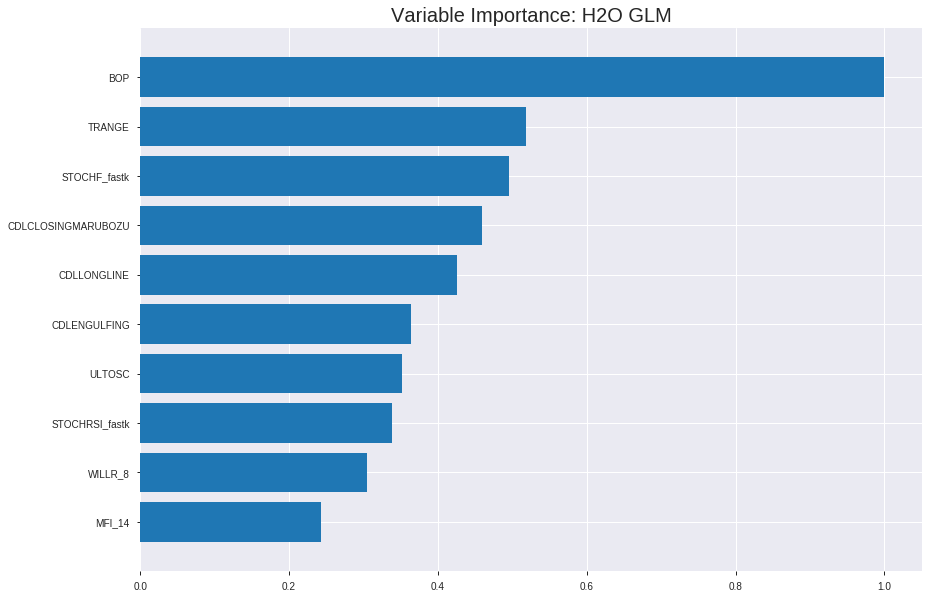

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_171053_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20138421673068324
RMSE: 0.4487585283096949
LogLoss: 0.5897035260422824
Null degrees of freedom: 1752
Residual degrees of freedom: 1676
Null deviance: 2428.80418460647
Residual deviance: 2067.500562304242
AIC: 2221.500562304242
AUC: 0.7655428501456389
pr_auc: 0.7543773554243025
Gini: 0.5310857002912779
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4516462732319206: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      460  392   0.4601   (392.0/852.0)
1      146  755   0.162    (146.0/901.0)
Total  606  1147  0.3069   (538.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451646     0.737305  235
max f2                       0.28074      0.851516  333
max f0point5                 0.562511     0.717197  168
max accuracy                 0.519764     0.702795  194
max precision                0.77218      0.895238  41
max recall                   0.146145     1         385
max specificity              0.90501      0.998826  0
max absolute_mcc             0.519764     0.404786  194
max min_per_class_accuracy   0.530314     0.691454  186
max mean_per_class_accuracy  0.519764     0.702036  194

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.856371           1.51326   1.51326            0.777778         0.871838  0.777778                    0.871838            0.0155383       0.0155383                  51.3257   51.3257
    2        0.0205362                   0.834713           1.83753   1.67539            0.944444         0.844228  0.861111                    0.858033            0.0188679       0.0344062                  83.7526   67.5392
    3        0.0302339                   0.809664           1.71672   1.68865            0.882353         0.822235  0.867925                    0.846551            0.0166482       0.0510544                  71.672    68.8648
    4        0.040502                    0.793468           1.72944   1.69899            0.888889         0.802502  0.873239                    0.835383            0.017758        0.0688124                  72.9436   69.8989
    5        0.0501997                   0.783196           1.71672   1.70241            0.882353         0.789133  0.875                       0.826449            0.0166482       0.0854606                  71.672    70.2414
    6        0.100399                    0.722078           1.70241   1.70241            0.875            0.752115  0.875                       0.789282            0.0854606       0.170921                   70.2414   70.2414
    7        0.150029                    0.685391           1.49835   1.63491            0.770115         0.701307  0.840304                    0.76018             0.0743618       0.245283                   49.8348   63.4909
    8        0.200228                    0.656399           1.4371    1.58532            0.738636         0.66974   0.814815                    0.737506            0.0721421       0.317425                   43.7103   58.5317
    9        0.300057                    0.615231           1.41196   1.52764            0.725714         0.636045  0.785171                    0.70375             0.140954        0.45838                    41.1961   52.7641
    10       0.399886                    0.575909           1.25631   1.45991            0.645714         0.594851  0.750357                    0.676564            0.125416        0.583796                   25.6312   45.9906
    11       0.500285                    0.531048           1.02808   1.37325            0.528409         0.552413  0.705815                    0.651649            0.103219        0.687014                   2.80812   37.3245
    12       0.600114                    0.481612           1.01172   1.31311            0.52             0.508529  0.674905                    0.627841            0.100999        0.788013                   1.17203   31.3106
    13       0.699943                    0.426988           0.767129  1.23524            0.394286         0.453477  0.634882                    0.602972            0.0765816       0.864595                   -23.2871  23.5236
    14       0.799772                    0.36183            0.655951  1.16293            0.337143         0.393709  0.597718                    0.576852            0.0654828       0.930078                   -34.4049  16.2929
    15       0.899601                    0.279154           0.489183  1.08816            0.251429         0.32106   0.55929                     0.548467            0.0488346       0.978912                   -51.0817  8.81632
    16       1                           0.0786434          0.210038  1                  0.107955         0.204934  0.513976                    0.513976         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.22494094182705007
RMSE: 0.474279392159358
LogLoss: 0.6405485957438368
Null degrees of freedom: 500
Residual degrees of freedom: 424
Null deviance: 691.9613759565244
Residual deviance: 641.8296929353245
AIC: 795.8296929353245
AUC: 0.7430457065497679
pr_auc: 0.76344416811413
Gini: 0.48609141309953574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19370361495882782: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   170  0.7589   (170.0/224.0)
1      7    270  0.0253   (7.0/277.0)
Total  61   440  0.3533   (177.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.193704     0.753138  345
max f2                       0.160015     0.873168  362
max f0point5                 0.406576     0.720894  206
max accuracy                 0.406576     0.684631  206
max precision                0.84285      1         0
max recall                   0.0694352    1         395
max specificity              0.84285      1         0
max absolute_mcc             0.406576     0.369494  206
max min_per_class_accuracy   0.402341     0.6787    208
max mean_per_class_accuracy  0.406576     0.685759  206

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 41.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.796052           1.50722   1.50722            0.833333         0.817826  0.833333                    0.817826            0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.759317           1.44693   1.47982            0.8              0.772902  0.818182                    0.797406            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.742682           1.80866   1.58258            1                0.750948  0.875                       0.782888            0.0180505       0.0505415                  80.8664   58.2581
    4        0.0419162                   0.726667           1.80866   1.63641            1                0.73139   0.904762                    0.770627            0.0180505       0.0685921                  80.8664   63.6411
    5        0.0518962                   0.720193           1.44693   1.59997            0.8              0.72328   0.884615                    0.761522            0.0144404       0.0830325                  44.6931   59.9972
    6        0.101796                    0.653549           1.59162   1.59588            0.88             0.686341  0.882353                    0.724668            0.0794224       0.162455                   59.1625   59.588
    7        0.151697                    0.610491           1.59162   1.59448            0.88             0.63138   0.881579                    0.693981            0.0794224       0.241877                   59.1625   59.448
    8        0.201597                    0.578809           1.30224   1.52214            0.72             0.593861  0.841584                    0.669199            0.0649819       0.306859                   30.2238   52.2143
    9        0.301397                    0.506196           1.30224   1.44933            0.72             0.540061  0.801325                    0.626438            0.129964        0.436823                   30.2238   44.9327
    10       0.401198                    0.463659           1.19372   1.38574            0.66             0.482066  0.766169                    0.590524            0.119134        0.555957                   19.3718   38.5743
    11       0.500998                    0.408095           1.0852    1.32587            0.6              0.440716  0.733068                    0.560682            0.108303        0.66426                    8.51986   32.5873
    12       0.600798                    0.355893           0.831986  1.24383            0.46             0.379279  0.687708                    0.530549            0.0830325       0.747292                   -16.8014  24.3832
    13       0.700599                    0.293687           0.868159  1.19032            0.48             0.325509  0.65812                     0.501341            0.0866426       0.833935                   -13.1841  19.0318
    14       0.800399                    0.23779            0.795812  1.14113            0.44             0.265129  0.630923                    0.471888            0.0794224       0.913357                   -20.4188  14.1127
    15       0.9002                      0.182769           0.614946  1.08279            0.34             0.209062  0.59867                     0.44275             0.0613718       0.974729                   -38.5054  8.27924
    16       1                           0.0316668          0.253213  1                  0.14             0.120808  0.552894                    0.41062             


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:10:53  0.000 sec   2            20        76            1.36947           1.36903
    2019-08-25 17:10:53  0.026 sec   4            12        77            1.3615            1.36384
    2019-08-25 17:10:53  0.045 sec   6            7.6       77            1.35037           1.35725
    2019-08-25 17:10:53  0.064 sec   8            4.7       77            1.33541           1.34903
    2019-08-25 17:10:53  0.082 sec   10           2.9       77            1.31626           1.33901
    2019-08-25 17:10:53  0.101 sec   12           1.8       77            1.29324           1.32716
    2019-08-25 17:10:53  0.127 sec   14           1.1       77            1.26773           1.31429
    2019-08-25 17:10:53  0.160 sec   16           0.7       77            1.24184           1.30187
    2019-08-25 17:10:53  0.197 sec   18           0.43      77            1.21769           1.29158
    2019-08-25 17:10:53  0.218 sec   20           0.27      77            1.19671           1.28453
    2019-08-25 17:10:53  0.236 sec   22           0.17      77            1.17941           1.2811
    2019-08-25 17:10:54  0.254 sec   24           0.1       77            1.16564           1.28125
    2019-08-25 17:10:54  0.271 sec   26           0.065     77            1.15497           1.28443
    2019-08-25 17:10:54  0.294 sec   28           0.04      77            1.14686           1.29033
    2019-08-25 17:10:54  0.312 sec   30           0.025     77            1.14083           1.29745
    2019-08-25 17:10:54  0.330 sec   32           0.015     77            1.13645           1.30659

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6573705179282868)

('F1', 0.6875)

('auc', 0.6988136241867585)

('logloss', 0.794006707750053)

('mean_per_class_error', 0.339328996045414)

('rmse', 0.529613964641189)

('mse', 0.2804909515429586)

glm prediction progress: |████████████████████████████████████████████████| 100%


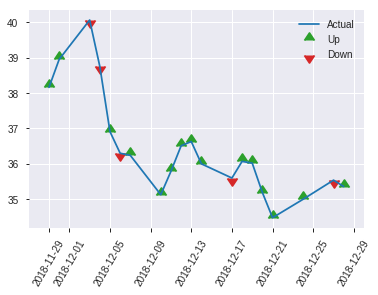


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2804909515429586
RMSE: 0.529613964641189
LogLoss: 0.794006707750053
Null degrees of freedom: 250
Residual degrees of freedom: 174
Null deviance: 349.1066907598522
Residual deviance: 398.5913672905267
AIC: 552.5913672905267
AUC: 0.6988136241867585
pr_auc: 0.6571333416627587
Gini: 0.39762724837351704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12902632197056388: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   72   0.5373   (72.0/134.0)
1      18   99   0.1538   (18.0/117.0)
Total  80   171  0.3586   (90.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.129026     0.6875    170
max f2                       0.0525315    0.820257  232
max f0point5                 0.209999     0.632184  122
max accuracy                 0.209999     0.657371  122
max precision                0.605343     1         0
max recall                   0.0207237    1         247
max specificity              0.605343     1         0
max absolute_mcc             0.129026     0.330626  170
max min_per_class_accuracy   0.209999     0.656716  122
max mean_per_class_accuracy  0.189808     0.660671  134

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 22.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.554677           2.1453    2.1453             1                0.592814   1                           0.592814            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.508957           2.1453    2.1453             1                0.519075   1                           0.555945            0.025641        0.0512821                  114.53    114.53
    3        0.0318725                   0.499099           1.07265   1.87714            0.5              0.501493   0.875                       0.542332            0.00854701      0.0598291                  7.26496   87.7137
    4        0.0438247                   0.4911             1.4302    1.75524            0.666667         0.493321   0.818182                    0.528965            0.017094        0.0769231                  43.0199   75.5245
    5        0.0517928                   0.465957           1.07265   1.65023            0.5              0.476374   0.769231                    0.520874            0.00854701      0.0854701                  7.26496   65.023
    6        0.103586                    0.424465           1.81525   1.73274            0.846154         0.442238   0.807692                    0.481556            0.0940171       0.179487                   81.5253   73.2742
    7        0.151394                    0.369054           1.25142   1.58075            0.583333         0.393274   0.736842                    0.453677            0.0598291       0.239316                   25.1425   58.0747
    8        0.203187                    0.331601           1.15516   1.47226            0.538462         0.343878   0.686275                    0.425689            0.0598291       0.299145                   15.5161   47.2264
    9        0.302789                    0.283808           1.28718   1.41138            0.6              0.30636    0.657895                    0.386436            0.128205        0.42735                    28.7179   41.1381
    10       0.40239                     0.249876           1.02974   1.31692            0.48             0.265494   0.613861                    0.3565              0.102564        0.529915                   2.97436   31.6916
    11       0.501992                    0.205262           1.37299   1.32804            0.64             0.229343   0.619048                    0.331271            0.136752        0.666667                   37.2991   32.8042
    12       0.601594                    0.16608            0.85812   1.25024            0.4              0.18344    0.582781                    0.306795            0.0854701       0.752137                   -14.188   25.0241
    13       0.701195                    0.125724           1.02974   1.21892            0.48             0.140948   0.568182                    0.283237            0.102564        0.854701                   2.97436   21.892
    14       0.800797                    0.0941647          0.514872  1.13135            0.24             0.108675   0.527363                    0.261526            0.0512821       0.905983                   -48.5128  13.1352
    15       0.900398                    0.0651948          0.600684  1.07265            0.28             0.0755237  0.5                         0.24095             0.0598291       0.965812                   -39.9316  7.26496
    16       1                           0.00383487         0.343248  1                  0.16             0.0404978  0.466135                    0.2

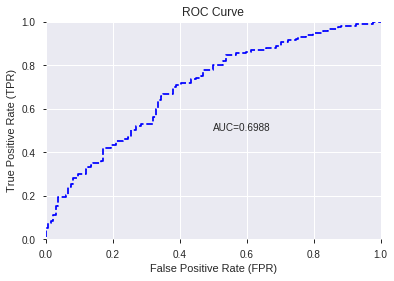

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


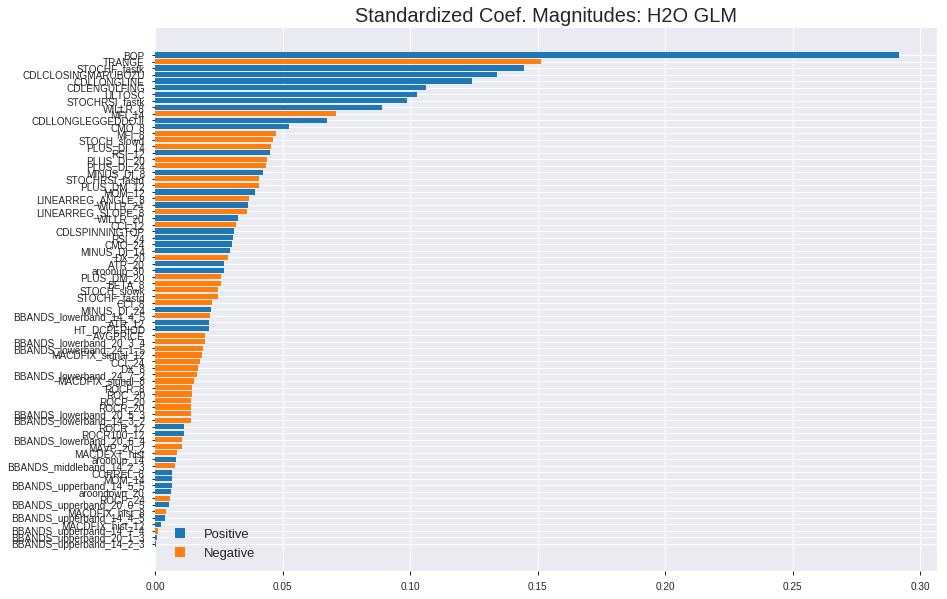

'log_likelihood'
--2019-08-25 17:10:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


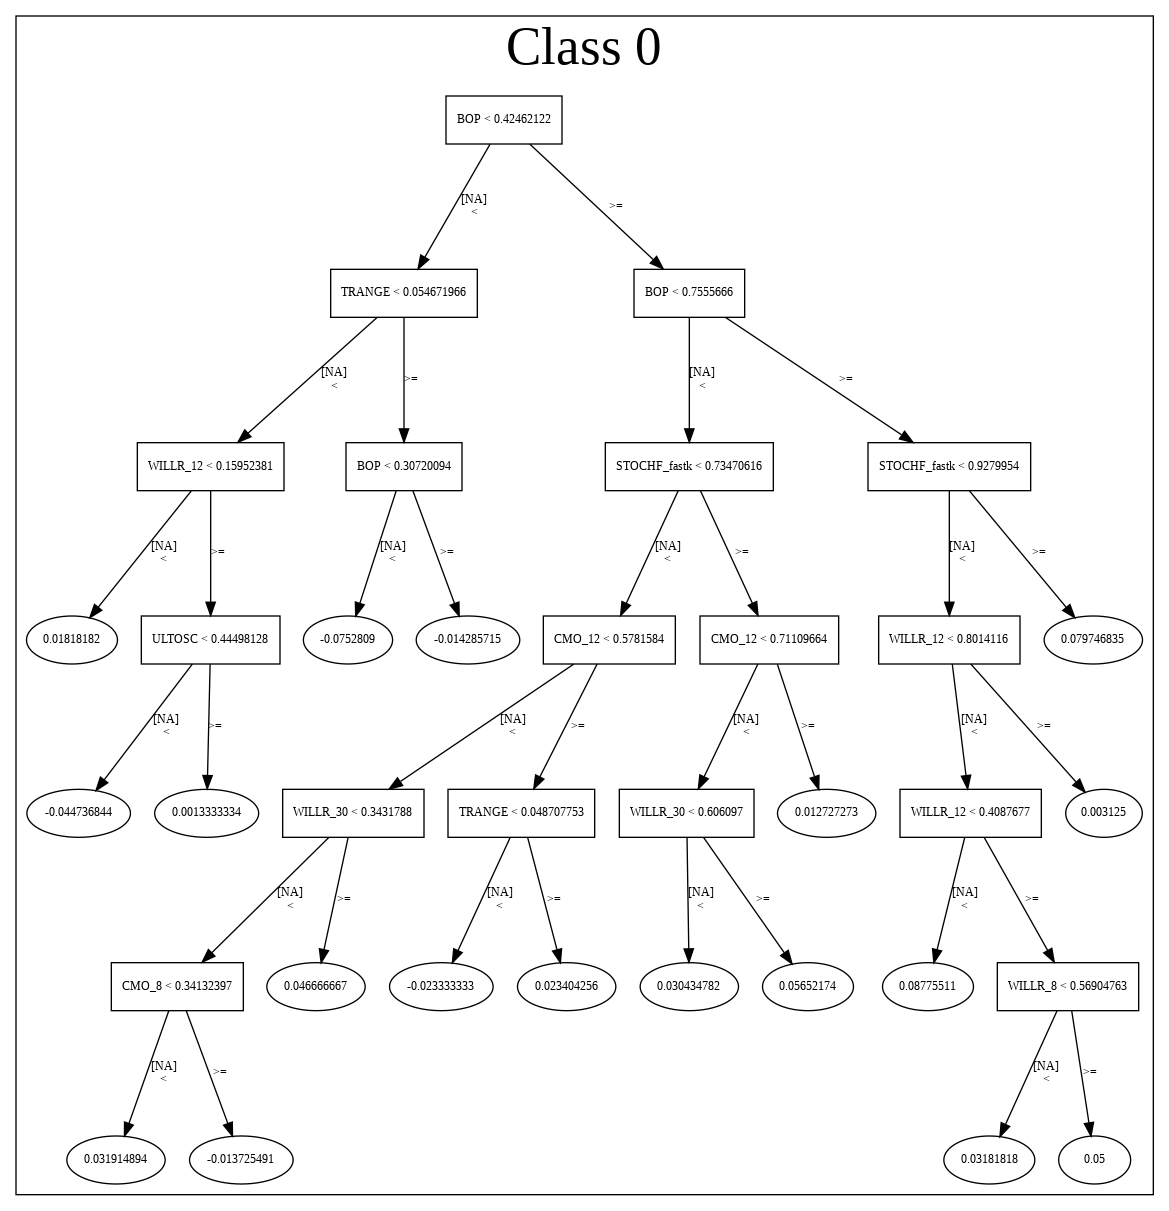

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_171053_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_171053_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'ULTOSC',
 'STOCHRSI_fastk',
 'WILLR_8',
 'MFI_14',
 'CDLLONGLEGGEDDOJI',
 'CMO_8',
 'MFI_8',
 'STOCH_slowd',
 'PLUS_DI_14',
 'RSI_12',
 'PLUS_DI_20',
 'PLUS_DI_24',
 'MINUS_DI_8',
 'STOCHRSI_fastd',
 'PLUS_DM_12',
 'MOM_12',
 'LINEARREG_ANGLE_8',
 'WILLR_24',
 'LINEARREG_SLOPE_8',
 'WILLR_20',
 'CCI_12',
 'CDLSPINNINGTOP',
 'RSI_24',
 'CMO_24',
 'MINUS_DI_14',
 'DX_20',
 'ATR_20',
 'aroonup_30',
 'PLUS_DM_20',
 'BETA_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_8',
 'MINUS_DI_24',
 'BBANDS_lowerband_14_4_5',
 'ATR_12',
 'HT_DCPERIOD',
 'AVGPRICE',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_lowerband_24_1_5',
 'MACDFIX_signal_12',
 'CCI_24',
 'DX_8',
 'BBANDS_lowerband_24_7_2',
 'MACDFIX_signal_8',
 'ROCR_8',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_lowerband_14_3_2',
 'ROCR_12',
 'ROCR100_12',
 'BBANDS_lowerband_20_6_4',
 'MAVP_20_2',
 'MACDEXT_hist',
 'aroonup_14',
 'BB

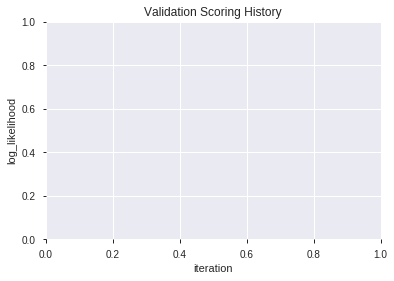

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190825_171108  0.753285  0.621885              0.287983  0.467199  0.218275
1  XGBoost_grid_1_AutoML_20190825_171108_model_4  0.748182  0.612975              0.318312  0.461839  0.213295
2               XGBoost_3_AutoML_20190825_171108  0.741612  0.614034              0.301282  0.463408  0.214747
3               XGBoost_2_AutoML_20190825_171108  0.735808  0.627616              0.326317  0.469510  0.220440
4  XGBoost_grid_1_AutoML_20190825_171108_model_7  0.735043  0.617162              0.292863  0.464530  0.215788
5  XGBoost_grid_1_AutoML_20190825_171108_model_2  0.729430  0.625382              0.307182  0.467963  0.218989
6  XGBoost_grid_1_AutoML_20190825_171108_model_3  0.727644  0.631942              0.303929  0.472136  0.222913
7  XGBoost_grid_1_AutoML_20190825_171108_model_5  0.727644  0.622565              0.340700  0.467334  0.218401
8  XGBoost_grid_1_AutoML_20190825_171108_model_1  0.723179  0.628251              0.313018  0.470721  0.221578
9  XGBoost_grid_1_AutoML_20190825_171108_model_6  0.720372  0.654209              0.318376  0.482256  0.232571

variable  relative_importance  scaled_importance  percentage
0                 BOP          1816.763794           1.000000    0.194631
1              TRANGE           527.075195           0.290118    0.056466
2        STOCHF_fastk           414.247223           0.228014    0.044379
3      STOCHRSI_fastd           245.636337           0.135205    0.026315
4      STOCHRSI_fastk           238.838165           0.131464    0.025587
..                ...                  ...                ...         ...
71       STOCHF_fastd            13.651011           0.007514    0.001462
72            ROCR_20            13.183714           0.007257    0.001412
73             RSI_24            11.972452           0.006590    0.001283
74  CDLLONGLEGGEDDOJI             9.971346           0.005489    0.001068
75       CDLENGULFING             8.332064           0.004586    0.000893

[76 rows x 4 columns]

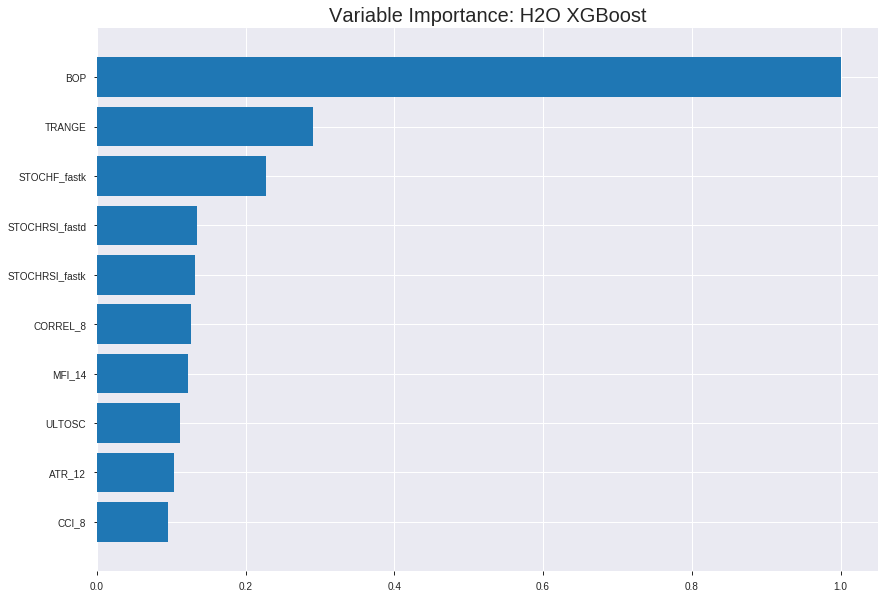

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190825_171108


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11861466449845214
RMSE: 0.3444047974382066
LogLoss: 0.4006770847803736
Mean Per-Class Error: 0.11149322870258915
AUC: 0.954308723223544
pr_auc: 0.9586300248109413
Gini: 0.908617446447088
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5419429689645767: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      784  68   0.0798   (68.0/852.0)
1      129  772  0.1432   (129.0/901.0)
Total  913  840  0.1124   (197.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.541943     0.886847  181
max f2                       0.356655     0.915595  268
max f0point5                 0.588373     0.912446  161
max accuracy                 0.541943     0.887621  181
max precision                0.940901     1         0
max recall                   0.223325     1         331
max specificity              0.940901     1         0
max absolute_mcc             0.541943     0.777384  181
max min_per_class_accuracy   0.51199      0.877913  194
max mean_per_class_accuracy  0.541943     0.888507  181

Gains/Lift Table: Avg response rate: 51.40 %, avg score: 51.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.888829           1.94562    1.94562            1                0.903387  1                           0.903387            0.0199778       0.0199778                  94.5616   94.5616
    2        0.0205362                   0.878806           1.94562    1.94562            1                0.884136  1                           0.893762            0.0199778       0.0399556                  94.5616   94.5616
    3        0.0302339                   0.867225           1.94562    1.94562            1                0.872359  1                           0.886897            0.0188679       0.0588235                  94.5616   94.5616
    4        0.040502                    0.859778           1.94562    1.94562            1                0.863271  1                           0.880907            0.0199778       0.0788013                  94.5616   94.5616
    5        0.0501997                   0.853517           1.94562    1.94562            1                0.856779  1                           0.876246            0.0188679       0.0976693                  94.5616   94.5616
    6        0.100399                    0.822926           1.94562    1.94562            1                0.837986  1                           0.857116            0.0976693       0.195339                   94.5616   94.5616
    7        0.150029                    0.788352           1.94562    1.94562            1                0.806693  1                           0.840436            0.0965594       0.291898                   94.5616   94.5616
    8        0.200228                    0.761407           1.9014     1.93453            0.977273         0.775452  0.994302                    0.824144            0.0954495       0.387347                   90.1397   93.453
    9        0.300057                    0.686844           1.87891    1.91602            0.965714         0.726782  0.984791                    0.791751            0.187569        0.574917                   87.8909   91.6025
    10       0.399886                    0.616708           1.71214    1.86513            0.88             0.650518  0.958631                    0.756493            0.170921        0.745838                   71.2142   86.5127
    11       0.500285                    0.518399           1.23812    1.7393             0.636364         0.568784  0.893957                    0.718823            0.124306        0.870144                   23.8119   73.9296
    12       0.600114                    0.437629           0.700422   1.56648            0.36             0.477763  0.805133                    0.678723            0.0699223       0.940067                   -29.9578  56.648
    13       0.699943                    0.350051           0.411359   1.40173            0.211429         0.392558  0.720456                    0.637909            0.0410655       0.981132                   -58.8641  40.1731
    14       0.799772                    0.258003           0.166767   1.24758            0.0857143        0.306845  0.641227                    0.596585            0.0166482       0.99778                    -83.3233  24.7581
    15       0.899601                    0.171522           0.0222356  1.1116             0.0114286        0.213272  0.571338                    0.554048            0.00221976      1                          -97.7764  11.1604
    16       1                           0.0602625          0          1                  0                0.134001  0.513976                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20963126380737335
RMSE: 0.4578550685614099
LogLoss: 0.606347193142988
Mean Per-Class Error: 0.29025109592573495
AUC: 0.7653026689014956
pr_auc: 0.7746998130622264
Gini: 0.5306053378029911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24964918196201324: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   150  0.6696   (150.0/224.0)
1      15   262  0.0542   (15.0/277.0)
Total  89   412  0.3293   (165.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249649     0.760522  325
max f2                       0.223094     0.869565  342
max f0point5                 0.37781      0.740741  229
max accuracy                 0.37781      0.712575  229
max precision                0.865775     1         0
max recall                   0.116464     1         394
max specificity              0.865775     1         0
max absolute_mcc             0.37781      0.419153  229
max min_per_class_accuracy   0.396058     0.705357  219
max mean_per_class_accuracy  0.37781      0.709749  229

Gains/Lift Table: Avg response rate: 55.29 %, avg score: 44.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.850272           1.50722   1.50722            0.833333         0.85732   0.833333                    0.85732             0.0180505       0.0180505                  50.722    50.722
    2        0.0219561                   0.829887           1.44693   1.47982            0.8              0.841343  0.818182                    0.850058            0.0144404       0.032491                   44.6931   47.9816
    3        0.0319361                   0.824871           1.80866   1.58258            1                0.826551  0.875                       0.842712            0.0180505       0.0505415                  80.8664   58.2581
    4        0.0419162                   0.799795           1.80866   1.63641            1                0.80858   0.904762                    0.834585            0.0180505       0.0685921                  80.8664   63.6411
    5        0.0518962                   0.790919           1.0852    1.53041            0.6              0.79387   0.846154                    0.826755            0.0108303       0.0794224                  8.51986   53.0408
    6        0.101796                    0.750608           1.59162   1.56042            0.88             0.767977  0.862745                    0.797943            0.0794224       0.158845                   59.1625   56.0416
    7        0.151697                    0.711161           1.44693   1.52309            0.8              0.728392  0.842105                    0.775064            0.0722022       0.231047                   44.6931   52.3086
    8        0.201597                    0.667641           1.51928   1.52214            0.84             0.686868  0.841584                    0.753233            0.0758123       0.306859                   51.9278   52.2143
    9        0.301397                    0.571465           1.37458   1.47328            0.76             0.617813  0.81457                     0.708392            0.137184        0.444043                   37.4585   47.3283
    10       0.401198                    0.489646           1.22989   1.41274            0.68             0.525336  0.781095                    0.662856            0.122744        0.566787                   22.9892   41.2738
    11       0.500998                    0.408049           1.15755   1.3619             0.64             0.442368  0.752988                    0.618934            0.115523        0.68231                    15.7545   36.1903
    12       0.600798                    0.359516           0.940505  1.2919             0.52             0.379782  0.714286                    0.579208            0.0938628       0.776173                   -5.94946  29.1903
    13       0.700599                    0.293951           0.795812  1.22123            0.44             0.328858  0.675214                    0.543545            0.0794224       0.855596                   -20.4188  22.1235
    14       0.800399                    0.254747           0.723466  1.15917            0.4              0.274419  0.640898                    0.509988            0.0722022       0.927798                   -27.6534  15.9169
    15       0.9002                      0.198825           0.470253  1.08279            0.26             0.229155  0.59867                     0.478854            0.0469314       0.974729                   -52.9747  8.27924
    16       1                           0.0737915          0.253213  1                  0.14             0.147771  0.552894                    0.445812          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:11:09  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.486024                         0.5                0.693147              0.5               0                    1                  0.447106
    2019-08-25 17:11:09  0.120 sec   5                  0.470839         0.636203            0.865695        0.866065           1.94562          0.216201                         0.486258           0.665885              0.721506          0.752747             1.50722            0.38523
    2019-08-25 17:11:09  0.217 sec   10                 0.446304         0.589701            0.886395        0.892262           1.94562          0.198517                         0.473371           0.640411              0.754456          0.780762             1.50722            0.343313
    2019-08-25 17:11:09  0.321 sec   15                 0.426711         0.553004            0.902234        0.90836            1.94562          0.171135                         0.466957           0.627245              0.755327          0.783198             1.80866            0.327345
    2019-08-25 17:11:09  0.423 sec   20                 0.412003         0.5255              0.91189         0.918288           1.94562          0.169424                         0.464155           0.621134              0.758501          0.782938             1.80866            0.331337
    2019-08-25 17:11:09  0.499 sec   25                 0.398911         0.500952            0.919568        0.925961           1.94562          0.167142                         0.459607           0.611565              0.761564          0.781901             1.80866            0.307385
    2019-08-25 17:11:09  0.575 sec   30                 0.387288         0.47924             0.926844        0.933742           1.94562          0.15231                          0.458832           0.609547              0.761145          0.777855             1.80866            0.313373
    2019-08-25 17:11:09  0.653 sec   35                 0.377261         0.460601            0.9333          0.939678           1.94562          0.147747                         0.458663           0.608838              0.758123          0.772093             1.80866            0.325349
    2019-08-25 17:11:09  0.729 sec   40                 0.367585         0.44265             0.939332        0.944668           1.94562          0.131204                         0.458653           0.608397              0.763844          0.775555             1.50722            0.289421
    2019-08-25 17:11:10  0.804 sec   45                 0.359238         0.427274            0.94438         0.949548           1.94562          0.12607                          0.460295           0.611331              0.761805          0.771334             1.50722            0.297405
    2019-08-25 17:11:10  0.882 sec   50                 0.351534         0.413506            0.949747        0.954384           1.94562          0.122076                         0.458021           0.606728              0.762458          0.773641             1.80866            0.335329
    2019-08-25 17:11:10  0.956 sec   55                 0.344405         0.400677            0.954309        0.95863            1.94562          0.112379                         0.457855           0.606347              0.765303          0.

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                1816.7637939453125     1.0                   0.19463147389659075
TRANGE             527.0751953125         0.29011762402414204   0.05646602076719572
STOCHF_fastk       414.2472229003906      0.22801380360008436   0.04437866266345219
STOCHRSI_fastd     245.63633728027344     0.13520543402444504   0.026315232903005997
STOCHRSI_fastk     238.83816528320312     0.13146352105825407   0.025586938867203483
---                ---                    ---                   ---
STOCHF_fastd       13.651010513305664     0.007513915985556337  0.0014624445430039843
ROCR_20            13.183713912963867     0.007256702250948049  0.0014123826547307265
RSI_24             11.972452163696289     0.0065899883097608    0.0012826191376900473
CDLLONGLEGGEDDOJI  9.971345901489258      0.005488520816366187  0.0010682388960014705
CDLENGULFING       8.332063674926758      0.004586211868980897  0.0008926211756617901


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7311827956989246)

('auc', 0.7532848577624698)

('logloss', 0.6218847080502978)

('mean_per_class_error', 0.2742058936088787)

('rmse', 0.46719943789864377)

('mse', 0.21827531477280868)

xgboost prediction progress: |████████████████████████████████████████████| 100%


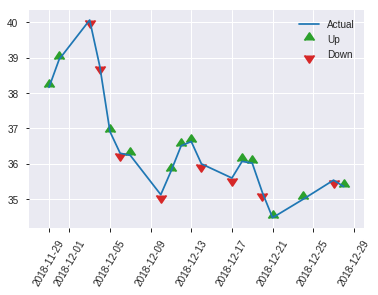


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21827531477280868
RMSE: 0.46719943789864377
LogLoss: 0.6218847080502978
Mean Per-Class Error: 0.2742058936088787
AUC: 0.7532848577624698
pr_auc: 0.6950819518778304
Gini: 0.5065697155249396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25122079253196716: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   60   0.4478   (60.0/134.0)
1      15   102  0.1282   (15.0/117.0)
Total  89   162  0.2988   (75.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251221     0.731183  161
max f2                       0.169798     0.832106  210
max f0point5                 0.30662      0.690936  138
max accuracy                 0.30662      0.721116  138
max precision                0.824893     1         0
max recall                   0.119715     1         240
max specificity              0.824893     1         0
max absolute_mcc             0.30662      0.453181  138
max min_per_class_accuracy   0.329224     0.701493  122
max mean_per_class_accuracy  0.30662      0.725794  138

Gains/Lift Table: Avg response rate: 46.61 %, avg score: 35.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.793523           2.1453    2.1453             1                0.809863  1                           0.809863            0.025641        0.025641                   114.53    114.53
    2        0.0239044                   0.764652           1.4302    1.78775            0.666667         0.781113  0.833333                    0.795488            0.017094        0.042735                   43.0199   78.7749
    3        0.0318725                   0.734309           2.1453    1.87714            1                0.753914  0.875                       0.785094            0.017094        0.0598291                  114.53    87.7137
    4        0.0438247                   0.693575           2.1453    1.95027            1                0.706978  0.909091                    0.76379             0.025641        0.0854701                  114.53    95.0272
    5        0.0517928                   0.668891           2.1453    1.98028            1                0.676692  0.923077                    0.75039             0.017094        0.102564                   114.53    98.0276
    6        0.103586                    0.576553           1.48521   1.73274            0.692308         0.626526  0.807692                    0.688458            0.0769231       0.179487                   48.5207   73.2742
    7        0.151394                    0.531814           1.25142   1.58075            0.583333         0.552696  0.736842                    0.645586            0.0598291       0.239316                   25.1425   58.0747
    8        0.203187                    0.497089           1.15516   1.47226            0.538462         0.517192  0.686275                    0.612858            0.0598291       0.299145                   15.5161   47.2264
    9        0.302789                    0.437441           1.20137   1.38315            0.56             0.463364  0.644737                    0.563682            0.119658        0.418803                   20.1368   38.3153
    10       0.40239                     0.387016           1.63043   1.44436            0.76             0.412804  0.673267                    0.526336            0.162393        0.581197                   63.0427   44.436
    11       0.501992                    0.326109           1.37299   1.4302             0.64             0.351588  0.666667                    0.491664            0.136752        0.717949                   37.2991   43.0199
    12       0.601594                    0.28799            1.02974   1.3639             0.48             0.306646  0.635762                    0.461032            0.102564        0.820513                   2.97436   36.3899
    13       0.701195                    0.22096            0.686496  1.26768            0.32             0.251023  0.590909                    0.431201            0.0683761       0.888889                   -31.3504  26.7677
    14       0.800797                    0.17487            0.514872  1.17404            0.24             0.193839  0.547264                    0.401678            0.0512821       0.940171                   -48.5128  17.4044
    15       0.900398                    0.150961           0.343248  1.08214            0.16             0.164449  0.504425                    0.375436            0.034188        0.974359                   -65.6752  8.2142
    16       1                           0.0802428          0.257436  1                  0.12             0.120057  0.466135                    0.35                

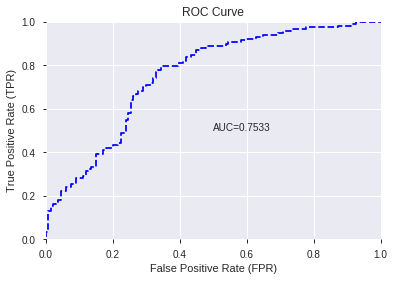

This function is available for GLM models only


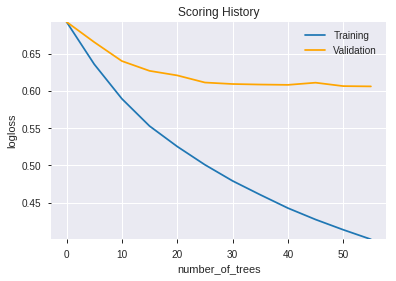

--2019-08-25 17:11:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

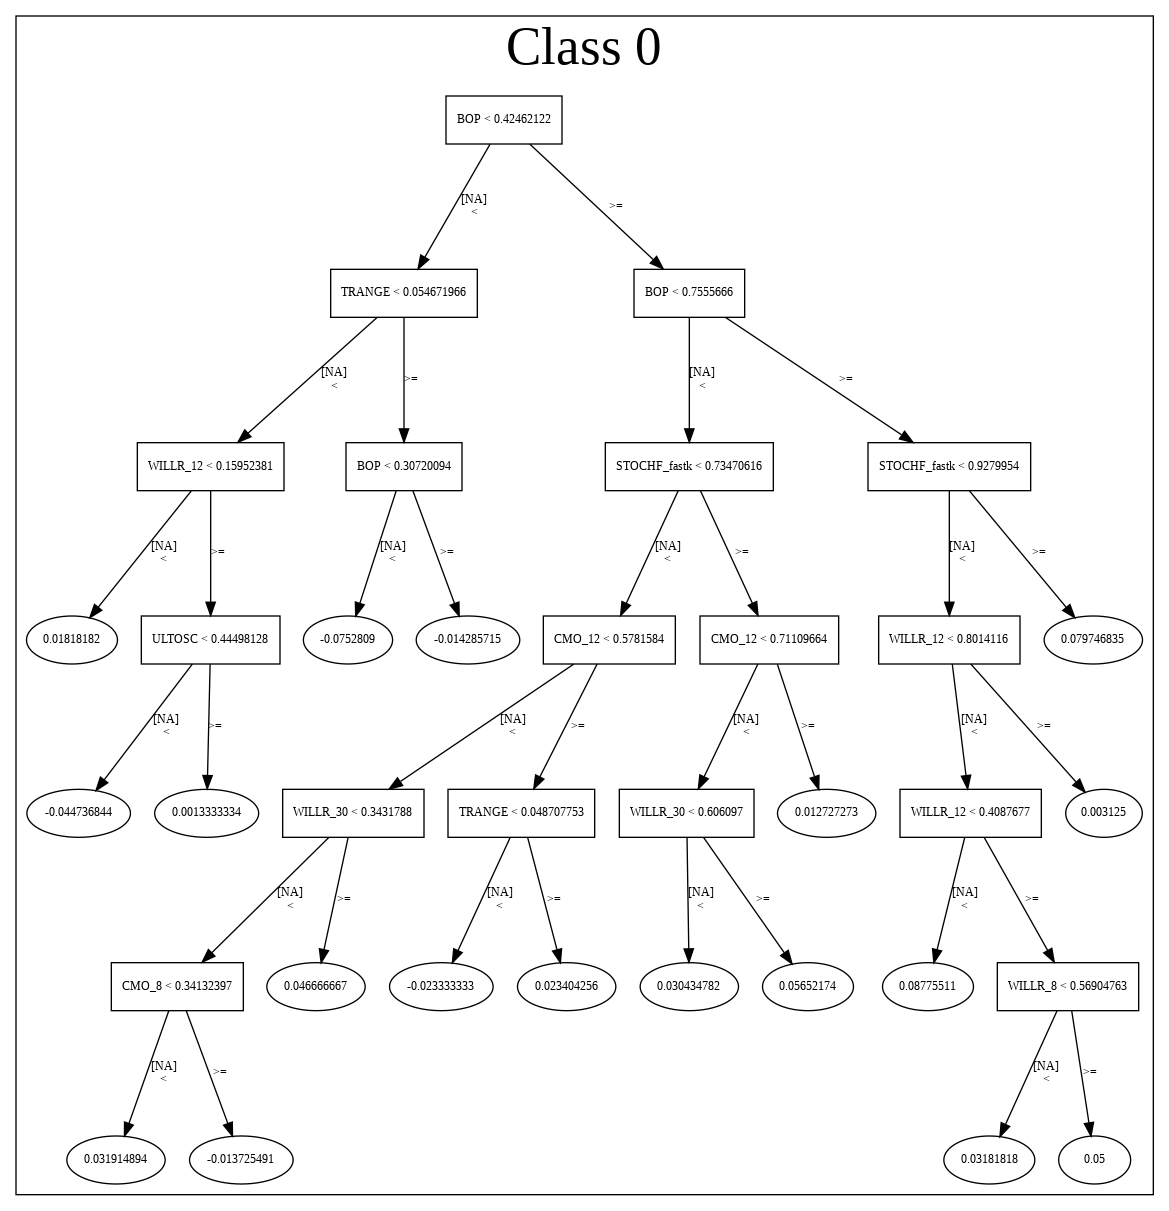

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190825_171108',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190825_171108',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b69b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b69b',
   'ty

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'CORREL_8',
 'MFI_14',
 'ULTOSC',
 'ATR_12',
 'CCI_8',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_8',
 'HT_DCPERIOD',
 'WILLR_8',
 'PLUS_DM_12',
 'STOCH_slowk',
 'PLUS_DI_14',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_20_6_4',
 'ROCR_8',
 'PLUS_DM_20',
 'ATR_20',
 'MINUS_DI_14',
 'BBANDS_upperband_14_7_4',
 'MOM_14',
 'MACDEXT_hist',
 'CDLCLOSINGMARUBOZU',
 'ROC_20',
 'BETA_8',
 'STOCH_slowd',
 'BBANDS_lowerband_24_1_5',
 'BBANDS_upperband_20_1_3',
 'ROCP_24',
 'MINUS_DI_24',
 'BBANDS_upperband_14_5_5',
 'MACDFIX_hist_12',
 'BBANDS_lowerband_14_4_5',
 'CCI_24',
 'CMO_24',
 'DX_8',
 'DX_20',
 'PLUS_DI_20',
 'MACDFIX_signal_8',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_14_2_3',
 'WILLR_20',
 'AVGPRICE',
 'MACDFIX_signal_12',
 'WILLR_24',
 'ROCR_12',
 'PLUS_DI_24',
 'aroonup_30',
 'RSI_12',
 'BBANDS_upperband_20_0_5',
 'CCI_12',
 'BBANDS_lowerband_20_3_4',
 'CMO_8',
 'aroonup_14',
 'BBANDS_middleband_14_2_3',
 'MA

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.673
GLM             0.669
XGBoost         0.721
dtype: float64

DeepLearning    GLM  XGBoost
All          0.466  0.466    0.693
DLF          0.665  0.665    0.697
Fwe          0.673  0.669    0.697
RFE          0.661  0.657    0.721
XGBF         0.661  0.665    0.697





F1


DeepLearning    0.710
GLM             0.709
XGBoost         0.731
dtype: float64

DeepLearning    GLM  XGBoost
All          0.636  0.636    0.714
DLF          0.694  0.680    0.718
Fwe          0.710  0.709    0.721
RFE          0.691  0.688    0.731
XGBF         0.679  0.680    0.718





auc


DeepLearning    0.720
GLM             0.712
XGBoost         0.760
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.746
DLF          0.708  0.709    0.743
Fwe          0.720  0.712    0.760
RFE          0.701  0.699    0.753
XGBF         0.698  0.709    0.743





logloss


DeepLearning     0.707
GLM             16.100
XGBoost          0.622
dtype: float64

DeepLearning     GLM  XGBoost
All          0.693  16.100    0.613
DLF          0.637   0.678    0.608
Fwe          0.705   0.702    0.592
RFE          0.630   0.794    0.622
XGBF         0.707   0.678    0.608





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.304
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.301
DLF          0.332  0.339    0.296
Fwe          0.324  0.322    0.304
RFE          0.329  0.339    0.274
XGBF         0.340  0.339    0.296





rmse


DeepLearning    0.500
GLM             0.683
XGBoost         0.467
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.683    0.462
DLF          0.473  0.479    0.460
Fwe          0.494  0.493    0.452
RFE          0.470  0.530    0.467
XGBF         0.498  0.479    0.460





mse


DeepLearning    0.250
GLM             0.466
XGBoost         0.218
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.466    0.214
DLF          0.223  0.230    0.211
Fwe          0.244  0.243    0.204
RFE          0.221  0.280    0.218
XGBF         0.248  0.230    0.211

{'F1':       DeepLearning    GLM  XGBoost
 All          0.636    NaN      NaN
 DLF          0.694    NaN      NaN
 DLF            NaN  0.680      NaN
 DLF            NaN    NaN    0.718
 All            NaN  0.636      NaN
 All            NaN    NaN    0.714
 XGBF         0.679    NaN      NaN
 XGBF           NaN  0.680      NaN
 XGBF           NaN    NaN    0.718
 Fwe          0.710    NaN      NaN
 Fwe            NaN  0.709      NaN
 Fwe            NaN    NaN    0.721
 RFE          0.691    NaN      NaN
 RFE            NaN  0.688      NaN
 RFE            NaN    NaN    0.731,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.466    NaN      NaN
 DLF          0.665    NaN      NaN
 DLF            NaN  0.665      NaN
 DLF            NaN    NaN    0.697
 All            NaN  0.466      NaN
 All            NaN    NaN    0.693
 XGBF         0.661    NaN      NaN
 XGBF           NaN  0.665      NaN
 XGBF           NaN    NaN    0.697
 Fwe          0.673    NaN      NaN
 Fwe     